In [1]:
import os, sys
# sys.path.append(os.path.dirname(os.path.abspath(__file__)))
sys.path.append('/home/dahye/UnOpticalFlow/')
from core.dataset import KITTI_2012, KITTI_2015
from core.evaluation import eval_flow_avg, load_gt_flow_kitti
from core.evaluation import eval_depth
from core.visualize import Visualizer_debug
from core.networks import Model_flow
from core.evaluation import load_gt_flow_kitti, load_gt_mask
import torch
from tqdm import tqdm
import pdb
import cv2
import numpy as np
import yaml

def test_kitti_2012(cfg, model, gt_flows, noc_masks):
    dataset = KITTI_2012(cfg.gt_2012_dir)
    flow_list = []
    for idx, inputs in enumerate(tqdm(dataset)):
        # img, K, K_inv = inputs
        img = inputs
        img = img[None,:,:,:]
        # K = K[None,:,:]
        # K_inv = K_inv[None,:,:]
        img_h = int(img.shape[2] / 2)
        img1, img2 = img[:,:,:img_h,:], img[:,:,img_h:,:]
        img1, img2 = img1.cuda(), img2.cuda()
        if cfg.mode == 'flow' or cfg.mode == 'flowposenet':
            flow = model.inference_flow(img1, img2)
        
        #pdb.set_trace()
        flow = flow[0].detach().cpu().numpy()
        flow = flow.transpose(1,2,0)
        flow_list.append(flow)
        
    eval_flow_res = eval_flow_avg(gt_flows, noc_masks, flow_list, cfg, write_img=False)
    
    print('CONFIG: {0}, mode: {1}'.format(cfg.config_file, cfg.mode))
    print('[EVAL] [KITTI 2012]')
    print(eval_flow_res)
    return eval_flow_res

def test_kitti_2015(cfg, model, gt_flows, noc_masks, gt_masks, depth_save_dir=None):
    dataset = KITTI_2015(cfg.gt_2015_dir)
    visualizer = Visualizer_debug(depth_save_dir)
    pred_flow_list = []
    pred_disp_list = []
    img_list = []
    for idx, inputs in enumerate(tqdm(dataset)):
        # img, K, K_inv = inputs
        img = inputs
        img = img[None,:,:,:]
        
        img_h = int(img.shape[2] / 2)
        img1, img2 = img[:,:,:img_h,:], img[:,:,img_h:,:]
        img_list.append(img1)
        img1, img2 = img1.cuda(), img2.cuda()
        if cfg.mode == 'flow' or cfg.mode == 'flowposenet':
            flow = model.inference_flow(img1, img2)
        # else:
        #     flow, disp1, disp2, Rt, _, _ = model.inference(img1, img2, K, K_inv)
        #     disp = disp1[0].detach().cpu().numpy()
        #     disp = disp.transpose(1,2,0)
        #     pred_disp_list.append(disp)

        flow = flow[0].detach().cpu().numpy()
        flow = flow.transpose(1,2,0)
        pred_flow_list.append(flow)
        
    #pdb.set_trace()
    eval_flow_res = eval_flow_avg(gt_flows, noc_masks, pred_flow_list, cfg, moving_masks=gt_masks, write_img=False)
    print('CONFIG: {0}, mode: {1}'.format(cfg.config_file, cfg.mode))
    print('[EVAL] [KITTI 2015]')
    print(eval_flow_res)
    ## depth evaluation
    return eval_flow_res

def disp2depth(disp, min_depth=0.001, max_depth=80.0):
    min_disp = 1 / max_depth
    max_disp = 1 / min_depth
    scaled_disp = min_disp + (max_disp - min_disp) * disp
    depth = 1 / scaled_disp
    return scaled_disp, depth

def resize_depths(gt_depth_list, pred_disp_list):
    gt_disp_list = []
    pred_depth_list = []
    pred_disp_resized = []
    for i in range(len(pred_disp_list)):
        h, w = gt_depth_list[i].shape
        pred_disp = cv2.resize(pred_disp_list[i], (w,h))
        pred_depth = 1.0 / (pred_disp + 1e-4)
        pred_depth_list.append(pred_depth)
        pred_disp_resized.append(pred_disp)
    
    return pred_depth_list, pred_disp_resized


def test_eigen_depth(cfg, model):
    print('Evaluate depth using eigen split. Using model in ' + cfg.model_dir)
    filenames = open('./data/eigen/test_files.txt').readlines()
    pred_disp_list = []
    for i in range(len(filenames)):
        path1, idx, _ = filenames[i].strip().split(' ')
        img = cv2.imread(os.path.join(os.path.join(cfg.raw_base_dir, path1), 'image_02/data/'+str(idx)+'.png'))
        #img_resize = cv2.resize(img, (832,256))
        img_resize = cv2.resize(img, (cfg.img_hw[1], cfg.img_hw[0]))
        img_input = torch.from_numpy(img_resize / 255.0).float().cuda().unsqueeze(0).permute(0,3,1,2)
        disp = model.infer_depth(img_input)
        disp = disp[0].detach().cpu().numpy()
        disp = disp.transpose(1,2,0)
        pred_disp_list.append(disp)
        #print(i)
    
    gt_depths = np.load('./data/eigen/gt_depths.npz', allow_pickle=True)['data']
    pred_depths, pred_disp_resized = resize_depths(gt_depths, pred_disp_list)
    eval_depth_res = eval_depth(gt_depths, pred_depths)
    abs_rel, sq_rel, rms, log_rms, a1, a2, a3 = eval_depth_res
    sys.stderr.write(
        "{:>10}, {:>10}, {:>10}, {:>10}, {:>10}, {:>10}, {:>10} \n".
        format('abs_rel', 'sq_rel', 'rms', 'log_rms',
                'a1', 'a2', 'a3'))
    sys.stderr.write(
        "{:10.4f}, {:10.4f}, {:10.3f}, {:10.3f}, {:10.3f}, {:10.3f}, {:10.3f} \n".
        format(abs_rel, sq_rel, rms, log_rms, a1, a2, a3))

    return eval_depth_res


def resize_disp(pred_disp_list, gt_depths):
    pred_depths = []
    h, w = gt_depths[0].shape[0], gt_depths[0].shape[1]
    for i in range(len(pred_disp_list)):
        disp = pred_disp_list[i]
        resize_disp = cv2.resize(disp, (w,h))
        depth = 1.0 / resize_disp
        pred_depths.append(depth)
    
    return pred_depths

import h5py
import scipy.io as sio
def load_nyu_test_data(data_dir):
    data = h5py.File(os.path.join(data_dir, 'nyu_depth_v2_labeled.mat'), 'r')
    splits = sio.loadmat(os.path.join(data_dir, 'splits.mat'))
    test = np.array(splits['testNdxs']).squeeze(1)
    images = np.transpose(data['images'], [0,1,3,2])
    depths = np.transpose(data['depths'], [0,2,1])
    images = images[test-1]
    depths = depths[test-1]
    return images, depths

def test_nyu(cfg, model, test_images, test_gt_depths):
    leng = test_images.shape[0]
    print('Test nyu depth on '+str(leng)+' images. Using depth model in '+cfg.model_dir)
    pred_disp_list = []
    crop_imgs = []
    crop_gt_depths = []
    for i in range(leng):
        img = test_images[i]
        img_crop = img[:,45:472,41:602]
        crop_imgs.append(img_crop)
        gt_depth_crop = test_gt_depths[i][45:472,41:602]
        crop_gt_depths.append(gt_depth_crop)
        #img = np.transpose(cv2.resize(np.transpose(img_crop, [1,2,0]), (576,448)), [2,0,1])
        img = np.transpose(cv2.resize(np.transpose(img_crop, [1,2,0]), (cfg.img_hw[1],cfg.img_hw[0])), [2,0,1])
        img_t = torch.from_numpy(img).float().cuda().unsqueeze(0) / 255.0
        disp = model.infer_depth(img_t)
        disp = np.transpose(disp[0].cpu().detach().numpy(), [1,2,0])
        pred_disp_list.append(disp)
    
    pred_depths = resize_disp(pred_disp_list, crop_gt_depths)
    eval_depth_res = eval_depth(crop_gt_depths, pred_depths, nyu=True)
    abs_rel, sq_rel, rms, log_rms, a1, a2, a3 = eval_depth_res
    sys.stderr.write(
        "{:>10}, {:>10}, {:>10}, {:>10}, {:>10}, {:>10}, {:>10} \n".
        format('abs_rel', 'sq_rel', 'rms', 'log10', 
                'a1', 'a2', 'a3'))
    sys.stderr.write(
        "{:10.4f}, {:10.4f}, {:10.3f}, {:10.3f}, {:10.3f}, {:10.3f}, {:10.3f} \n".
        format(abs_rel, sq_rel, rms, log_rms, a1, a2, a3))
    
    return eval_depth_res

def test_single_image(img_path, model, training_hw, save_dir='./'):
    img = cv2.imread(img_path)
    h, w = img.shape[0:2]
    img_resized = cv2.resize(img, (training_hw[1], training_hw[0]))
    img_t = torch.from_numpy(np.transpose(img_resized, [2,0,1])).float().cuda().unsqueeze(0) / 255.0
    disp = model.infer_depth(img_t)
    disp = np.transpose(disp[0].cpu().detach().numpy(), [1,2,0])
    disp_resized = cv2.resize(disp, (w,h))
    depth = 1.0 / (1e-6 + disp_resized)

    visualizer = Visualizer_debug(dump_dir=save_dir)
    visualizer.save_disp_color_img(disp_resized, name='demo')
    print('Depth prediction saved in ' + save_dir)


# if __name__ == '__main__':
#     import argparse
#     arg_parser = argparse.ArgumentParser(
#         description="TrianFlow testing."
#     )
#     arg_parser.add_argument('-c', '--config_file', default=None, help='config file.')
#     arg_parser.add_argument('-g', '--gpu', type=str, default=0, help='gpu id.')
#     arg_parser.add_argument('--mode', type=str, default='depth', help='mode for testing.')
#     arg_parser.add_argument('--task', type=str, default='kitti_depth', help='To test on which task, kitti_depth or kitti_flow or nyuv2 or demo')
#     arg_parser.add_argument('--image_path', type=str, default=None, help='Set this only when task==demo. Depth demo for single image.')
#     arg_parser.add_argument('--pretrained_model', type=str, default=None, help='directory for loading flow pretrained models')
#     arg_parser.add_argument('--result_dir', type=str, default=None, help='directory for saving predictions')

#     args = arg_parser.parse_args()
#     if not os.path.exists(args.config_file):
#         raise ValueError('config file not found.')
#     with open(args.config_file, 'r') as f:
#         cfg = yaml.safe_load(f)
#     cfg['img_hw'] = (cfg['img_hw'][0], cfg['img_hw'][1])
#     #cfg['log_dump_dir'] = os.path.join(args.model_dir, 'log.pkl')
#     cfg['model_dir'] = args.result_dir

#     # copy attr into cfg
#     for attr in dir(args):
#         if attr[:2] != '__':
#             cfg[attr] = getattr(args, attr)
    
#     class pObject(object):
#         def __init__(self):
#             pass
#     cfg_new = pObject()
#     for attr in list(cfg.keys()):
#         setattr(cfg_new, attr, cfg[attr])

#     if args.mode == 'flow':
#         model = Model_flow(cfg_new)
#     elif args.mode == 'depth' or args.mode == 'flow_3stage':
#         model = Model_depth_pose(cfg_new)
#     elif args.mode == 'flowposenet':
#         model = Model_flowposenet(cfg_new)
    
#     if args.task == 'demo':
#         model = Model_depth_pose(cfg_new)

#     model.cuda()
#     weights = torch.load(args.pretrained_model)
#     model.load_state_dict(weights['model_state_dict'])
#     model.eval()
#     print('Model Loaded.')

#     if args.task == 'kitti_depth':
#         depth_res = test_eigen_depth(cfg_new, model)
#     elif args.task == 'kitti_flow':
#         gt_flows_2015, noc_masks_2015 = load_gt_flow_kitti(cfg_new.gt_2015_dir, 'kitti_2015')
#         gt_masks_2015 = load_gt_mask(cfg_new.gt_2015_dir)
#         flow_res = test_kitti_2015(cfg_new, model, gt_flows_2015, noc_masks_2015, gt_masks_2015)
#     elif args.task == 'nyuv2':
#         test_images, test_gt_depths = load_nyu_test_data(cfg_new.nyu_test_dir)
#         depth_res = test_nyu(cfg_new, model, test_images, test_gt_depths)
#     elif args.task == 'demo':
#         test_single_image(args.image_path, model, training_hw=cfg['img_hw'], save_dir=args.result_dir)



In [2]:
import os, sys
import yaml
sys.path.append('/home/dahye/UnOpticalFlow/')
from core.dataset import KITTI_RAW, KITTI_Prepared, SINTEL_RAW, SINTEL_Prepared, NYU_Prepare, NYU_v2, KITTI_Odo
from core.networks import get_model
from core.config import generate_loss_weights_dict
from core.visualize import Visualizer
from core.evaluation import load_gt_flow_kitti, load_gt_mask
# from test import test_kitti_2012, test_kitti_2015, test_eigen_depth, test_nyu, load_nyu_test_data

from collections import OrderedDict
import torch
import torch.utils.data
from tqdm import tqdm
import shutil
import pickle
import pdb
import random
import numpy as np
import torch.backends.cudnn as cudnn


def save_model(iter_, model_dir, filename, model, optimizer):
    torch.save({"iteration": iter_, "model_state_dict": model.state_dict(), 'optimizer_state_dict': optimizer.state_dict()}, os.path.join(model_dir, filename))

def load_model(model_dir, filename, model, optimizer):
    data = torch.load(os.path.join(model_dir, filename))
    iter_ = data['iteration']
    model.load_state_dict(data['model_state_dict'])
    optimizer.load_state_dict(data['optimizer_state_dict'])
    return iter_, model, optimizer

def train(cfg):
    # load model and optimizer
    model = get_model(cfg.mode)(cfg)
    if cfg.multi_gpu:
        model = torch.nn.DataParallel(model)
    model = model.cuda()
    optimizer = torch.optim.Adam([{'params': filter(lambda p: p.requires_grad, model.parameters()), 'lr': cfg.lr}])
    # Load Pretrained Models
    if cfg.resume:
        if cfg.iter_start > 0:
            cfg.iter_start, model, optimizer = load_model(cfg.model_dir, 'iter_{}.pth'.format(cfg.iter_start), model, optimizer)
        else:
            cfg.iter_start, model, optimizer = load_model(cfg.model_dir, 'last.pth', model, optimizer)
    elif cfg.flow_pretrained_model:
        data = torch.load(cfg.flow_pretrained_model)['model_state_dict']
        renamed_dict = OrderedDict()
        for k, v in data.items():
            if cfg.multi_gpu:
                name = 'module.model_flow.' + k
            elif cfg.mode == 'flowposenet':
                name = 'model_flow.' + k
            else:
                name = 'model_pose.model_flow.' + k
            renamed_dict[name] = v
        missing_keys, unexp_keys = model.load_state_dict(renamed_dict, strict=False)
        print(missing_keys)
        print(unexp_keys)
        print('Load Flow Pretrained Model from ' + cfg.flow_pretrained_model)
    if cfg.depth_pretrained_model and not cfg.resume:
        data = torch.load(cfg.depth_pretrained_model)['model_state_dict']
        if cfg.multi_gpu:
            renamed_dict = OrderedDict()
            for k, v in data.items():
                name = 'module.' + k
                renamed_dict[name] = v
            missing_keys, unexp_keys = model.load_state_dict(renamed_dict, strict=False)
        else:
            missing_keys, unexp_keys = model.load_state_dict(data, strict=False)
        print(missing_keys)
        print('##############')
        print(unexp_keys)
        print('Load Depth Pretrained Model from ' + cfg.depth_pretrained_model)
    loss_weights_dict = generate_loss_weights_dict(cfg)
    visualizer = Visualizer(loss_weights_dict, cfg.log_dump_dir)

    # load dataset
    data_dir = os.path.join(cfg.prepared_base_dir, cfg.prepared_save_dir)
    if not os.path.exists(os.path.join(data_dir, 'train.txt')):
        if cfg.dataset == 'kitti_depth':
            kitti_raw_dataset = KITTI_RAW(cfg.raw_base_dir, cfg.static_frames_txt, cfg.test_scenes_txt)
            kitti_raw_dataset.prepare_data_mp(data_dir, stride=1)
        elif cfg.dataset == 'sintel_raw':
            sintel_raw_dataset = SINTEL_RAW(cfg.raw_base_dir)
            sintel_raw_dataset.prepare_data_mp(data_dir, cfg.stride)
        elif cfg.dataset == 'kitti_odo':
            kitti_raw_dataset = KITTI_Odo(cfg.raw_base_dir)
            kitti_raw_dataset.prepare_data_mp(data_dir, stride=1)
        elif cfg.dataset == 'nyuv2':
            nyu_raw_dataset = NYU_Prepare(cfg.raw_base_dir, cfg.nyu_test_dir)
            nyu_raw_dataset.prepare_data_mp(data_dir, stride=10)
        else:
            raise NotImplementedError
        
    # data_dir : prepared_base_dir + preapared_save_dir
    if cfg.dataset == 'kitti_depth':
        dataset = KITTI_Prepared(data_dir, num_scales=cfg.num_scales, img_hw=cfg.img_hw, num_iterations=(cfg.num_iterations - cfg.iter_start) * cfg.batch_size)
    elif cfg.dataset == 'sintel_raw':
        dataset = SINTEL_Prepared(data_dir, num_scales=cfg.num_scales, img_hw=cfg.img_hw, num_iterations=(cfg.num_iterations - cfg.iter_start) * cfg.batch_size)
    elif cfg.dataset == 'kitti_odo':
        dataset = KITTI_Prepared(data_dir, num_scales=cfg.num_scales, img_hw=cfg.img_hw, num_iterations=(cfg.num_iterations - cfg.iter_start) * cfg.batch_size)
    elif cfg.dataset == 'nyuv2':
        dataset = NYU_v2(data_dir, num_scales=cfg.num_scales, img_hw=cfg.img_hw, num_iterations=(cfg.num_iterations - cfg.iter_start) * cfg.batch_size)
    else:
        raise NotImplementedError
    
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=cfg.batch_size, shuffle=True, num_workers=cfg.num_workers, drop_last=False)
    if cfg.dataset == 'kitti_depth' or cfg.dataset == 'kitti_odo' or cfg.dataset == 'sintel_raw':
        gt_flows_2012, noc_masks_2012 = load_gt_flow_kitti(cfg.gt_2012_dir, 'kitti_2012')
        gt_flows_2015, noc_masks_2015 = load_gt_flow_kitti(cfg.gt_2015_dir, 'kitti_2015')
        gt_masks_2015 = load_gt_mask(cfg.gt_2015_dir)
    elif cfg.dataset == 'nyuv2':
        test_images, test_gt_depths = load_nyu_test_data(cfg.nyu_test_dir)

    # training
    print('starting iteration: {}.'.format(cfg.iter_start))
    for iter_, inputs in enumerate(tqdm(dataloader)):
        if (iter_ + 1) % cfg.test_interval == 0 and (not cfg.no_test):
            model.eval()
            if args.multi_gpu:
                model_eval = model.module
            else:
                model_eval = model
            if cfg.dataset == 'kitti_depth' or cfg.dataset == 'kitti_odo' or cfg.dataset == 'sintel_raw':
                if not (cfg.mode == 'depth' or cfg.mode == 'flowposenet'):
                    eval_2012_res = test_kitti_2012(cfg, model_eval, gt_flows_2012, noc_masks_2012)
                    eval_2015_res = test_kitti_2015(cfg, model_eval, gt_flows_2015, noc_masks_2015, gt_masks_2015, depth_save_dir=os.path.join(cfg.model_dir, 'results'))
                    visualizer.add_log_pack({'eval_2012_res': eval_2012_res, 'eval_2015_res': eval_2015_res})
            elif cfg.dataset == 'nyuv2':
                if not cfg.mode == 'flow':
                    eval_nyu_res = test_nyu(cfg, model_eval, test_images, test_gt_depths)
                    visualizer.add_log_pack({'eval_nyu_res': eval_nyu_res})
            visualizer.dump_log(os.path.join(cfg.model_dir, 'log.pkl'))
        model.train()
        iter_ = iter_ + cfg.iter_start
        optimizer.zero_grad()
        inputs = inputs.cuda()
        #inputs = [k.cuda() for k in inputs]
        loss_pack = model(inputs)

        if iter_ % cfg.log_interval == 0:
            visualizer.print_loss(loss_pack, iter_=iter_)

        loss_list = []
        for key in list(loss_pack.keys()):
            loss_list.append((loss_weights_dict[key] * loss_pack[key].mean()).unsqueeze(0))
        loss = torch.cat(loss_list, 0).sum()
        loss.backward()
        optimizer.step()
        if (iter_ + 1) % cfg.save_interval == 0:
            save_model(iter_, cfg.model_dir, 'iter_{}.pth'.format(iter_), model, optimizer)
            save_model(iter_, cfg.model_dir, 'last.pth'.format(iter_), model, optimizer)
    
    if cfg.dataset == 'kitti_depth':
        if cfg.mode == 'depth' or cfg.mode == 'depth_pose':
            eval_depth_res = test_eigen_depth(cfg, model_eval)

In [3]:
from types import SimpleNamespace 
args  = SimpleNamespace()
args.config_file = './config/flying.yaml'
args.gpu = '7'
args.batch_size = 8
args.iter_start = 0
args.lr = 0.0001
args.num_workers = 4
args.log_interval = 100
args.test_interval = 2000
args.save_interval = 2000
args.mode = 'flow'
args.model_dir = None
args.prepared_save_dir = 'data_s1'
args.flow_pretrained_model = None
args.depth_pretrained_model = None
args.resume = False
args.multi_gpu = False
args.no_test = False

In [4]:
__file__ = '/home/dahye/UnOpticalFlow/train.py'

In [5]:
# import argparse
# arg_parser = argparse.ArgumentParser(
#     description="TrianFlow training pipeline."
# )
# arg_parser.add_argument('-c', '--config_file', default='./config/kitti.yaml', help='config file.')
# arg_parser.add_argument('-g', '--gpu', type=str, default=7, help='gpu id.')
# arg_parser.add_argument('--batch_size', type=int, default=8, help='batch size.')
# arg_parser.add_argument('--iter_start', type=int, default=0, help='starting iteration.')
# arg_parser.add_argument('--lr', type=float, default=0.0001, help='learning rate')
# arg_parser.add_argument('--num_workers', type=int, default=4, help='number of workers.')
# arg_parser.add_argument('--log_interval', type=int, default=100, help='interval for printing loss.')
# arg_parser.add_argument('--test_interval', type=int, default=2000, help='interval for evaluation.')
# arg_parser.add_argument('--save_interval', type=int, default=2000, help='interval for saving models.')
# arg_parser.add_argument('--mode', type=str, default='flow', help='training mode.')
# arg_parser.add_argument('--model_dir', type=str, default=None, help='directory for saving models')
# arg_parser.add_argument('--prepared_save_dir', type=str, default='data_s1', help='directory name for generated training dataset')
# arg_parser.add_argument('--flow_pretrained_model', type=str, default=None, help='directory for loading flow pretrained models')
# arg_parser.add_argument('--depth_pretrained_model', type=str, default=None, help='directory for loading depth pretrained models')
# arg_parser.add_argument('--resume', action='store_true', help='to resume training.')
# arg_parser.add_argument('--multi_gpu', action='store_true', help='to use multiple gpu for training.')
# arg_parser.add_argument('--no_test', action='store_true', help='without evaluation.')
# args = arg_parser.parse_args()
    #args.config_file = 'config/debug.yaml'
if args.config_file is None:
    raise ValueError('config file needed. -c --config_file.')

# set model
if args.model_dir is None:
    args.model_dir = os.path.join('models', os.path.splitext(os.path.split(args.config_file)[1])[0])
args.model_dir = os.path.join(os.path.dirname(os.path.abspath(__file__)), args.model_dir, args.mode)
if not os.path.exists(args.model_dir):
    os.makedirs(args.model_dir)
if not os.path.exists(args.config_file):
    raise ValueError('config file not found.')
with open(args.config_file, 'r') as f:
    cfg = yaml.safe_load(f)
cfg['img_hw'] = (cfg['img_hw'][0], cfg['img_hw'][1])
cfg['log_dump_dir'] = os.path.join(args.model_dir, 'log.pkl')
shutil.copy(args.config_file, args.model_dir)

# copy attr into cfg
for attr in dir(args):
    if attr[:2] != '__':
        cfg[attr] = getattr(args, attr)

# set gpu
num_gpus = len(args.gpu.split(','))
if (args.multi_gpu and num_gpus <= 1) or ((not args.multi_gpu) and num_gpus > 1):
    raise ValueError('Error! the number of gpus used in the --gpu argument does not match the argument --multi_gpu.')
if args.multi_gpu:
    cfg['batch_size'] = cfg['batch_size'] * num_gpus
    cfg['num_iterations'] = int(cfg['num_iterations'] / num_gpus)
os.environ['CUDA_VISIBLE_DEVICES'] = str(args.gpu)

class pObject(object):
    def __init__(self):
        pass
cfg_new = pObject()
for attr in list(cfg.keys()):
    setattr(cfg_new, attr, cfg[attr])
with open(os.path.join(args.model_dir, 'config.pkl'), 'wb') as f:
    pickle.dump(cfg_new, f)



In [6]:
cfg = cfg_new

In [7]:
model = get_model(cfg.mode)(cfg)
if cfg.multi_gpu:
    model = torch.nn.DataParallel(model)
model = model.cuda()
optimizer = torch.optim.Adam([{'params': filter(lambda p: p.requires_grad, model.parameters()), 'lr': cfg.lr}])
# Load Pretrained Models
if cfg.resume:
    if cfg.iter_start > 0:
        cfg.iter_start, model, optimizer = load_model(cfg.model_dir, 'iter_{}.pth'.format(cfg.iter_start), model, optimizer)
    else:
        cfg.iter_start, model, optimizer = load_model(cfg.model_dir, 'last.pth', model, optimizer)
elif cfg.flow_pretrained_model:
    data = torch.load(cfg.flow_pretrained_model)['model_state_dict']
    renamed_dict = OrderedDict()
    for k, v in data.items():
        if cfg.multi_gpu:
            name = 'module.model_flow.' + k
        elif cfg.mode == 'flowposenet':
            name = 'model_flow.' + k
        else:
            name = 'model_pose.model_flow.' + k
        renamed_dict[name] = v
    missing_keys, unexp_keys = model.load_state_dict(renamed_dict, strict=False)
    print(missing_keys)
    print(unexp_keys)
    print('Load Flow Pretrained Model from ' + cfg.flow_pretrained_model)
if cfg.depth_pretrained_model and not cfg.resume:
    data = torch.load(cfg.depth_pretrained_model)['model_state_dict']
    if cfg.multi_gpu:
        renamed_dict = OrderedDict()
        for k, v in data.items():
            name = 'module.' + k
            renamed_dict[name] = v
        missing_keys, unexp_keys = model.load_state_dict(renamed_dict, strict=False)
    else:
        missing_keys, unexp_keys = model.load_state_dict(data, strict=False)
    print(missing_keys)
    print('##############')
    print(unexp_keys)
    print('Load Depth Pretrained Model from ' + cfg.depth_pretrained_model)
loss_weights_dict = generate_loss_weights_dict(cfg)
visualizer = Visualizer(loss_weights_dict, cfg.log_dump_dir)

this is paper method.


KeyboardInterrupt: 

In [8]:
from core.dataset import KITTI_RAW, KITTI_Prepared, SINTEL_RAW, SINTEL_Prepared, NYU_Prepare, NYU_v2, KITTI_Odo, FLYING_RAW, Flying_Prepared

In [9]:
data_dir = os.path.join(cfg.prepared_base_dir, cfg.prepared_save_dir)
if not os.path.exists(os.path.join(data_dir, 'train.txt')):
    if cfg.dataset == 'kitti_depth':
        kitti_raw_dataset = KITTI_RAW(cfg.raw_base_dir, cfg.static_frames_txt, cfg.test_scenes_txt)
        kitti_raw_dataset.prepare_data_mp(data_dir, stride=1)
    elif cfg.dataset == 'sintel_raw':
        sintel_raw_dataset = SINTEL_RAW(cfg.raw_base_dir)
        sintel_raw_dataset.prepare_data_mp(data_dir, cfg.stride)
    elif cfg.dataset == 'kitti_odo':
        kitti_raw_dataset = KITTI_Odo(cfg.raw_base_dir)
        kitti_raw_dataset.prepare_data_mp(data_dir, stride=1)
    elif cfg.dataset == 'nyuv2':
        nyu_raw_dataset = NYU_Prepare(cfg.raw_base_dir, cfg.nyu_test_dir)
        nyu_raw_dataset.prepare_data_mp(data_dir, stride=10)
    elif cfg.dataset == 'flying_chairs':
        flying_raw_dataset = FLYING_RAW(cfg.raw_base_dir)
        flying_raw_dataset.prepare_data_mp(data_dir, stride=1)
    else:
        raise NotImplementedError

# data_dir : prepared_base_dir + preapared_save_dir
if cfg.dataset == 'kitti_depth':
    dataset = KITTI_Prepared(data_dir, num_scales=cfg.num_scales, img_hw=cfg.img_hw, num_iterations=(cfg.num_iterations - cfg.iter_start) * cfg.batch_size)
elif cfg.dataset == 'sintel_raw':
    dataset = SINTEL_Prepared(data_dir, num_scales=cfg.num_scales, img_hw=cfg.img_hw, num_iterations=(cfg.num_iterations - cfg.iter_start) * cfg.batch_size)
elif cfg.dataset == 'kitti_odo':
    dataset = KITTI_Prepared(data_dir, num_scales=cfg.num_scales, img_hw=cfg.img_hw, num_iterations=(cfg.num_iterations - cfg.iter_start) * cfg.batch_size)
elif cfg.dataset == 'nyuv2':
    dataset = NYU_v2(data_dir, num_scales=cfg.num_scales, img_hw=cfg.img_hw, num_iterations=(cfg.num_iterations - cfg.iter_start) * cfg.batch_size)
elif cfg.dataset == 'flying_chairs':
    dataset = Flying_Prepared(data_dir, num_scales=cfg.num_scales, img_hw=cfg.img_hw, num_iterations=(cfg.num_iterations - cfg.iter_start) * cfg.batch_size)
else:
    raise NotImplementedError

Preparing sequence data....
/data/FlyingChairs_release/data/00001.png
/data/FlyingChairs_release/data/00001.png
/data/FlyingChairs_release/data/00002.png
/data/FlyingChairs_release/data/00002.png
/data/FlyingChairs_release/data/00003.png
/data/FlyingChairs_release/data/00003.png
/data/FlyingChairs_release/data/00004.png
/data/FlyingChairs_release/data/00004.png
/data/FlyingChairs_release/data/00005.png
/data/FlyingChairs_release/data/00005.png
/data/FlyingChairs_release/data/00006.png
/data/FlyingChairs_release/data/00006.png
/data/FlyingChairs_release/data/00007.png
/data/FlyingChairs_release/data/00007.png
/data/FlyingChairs_release/data/00008.png
/data/FlyingChairs_release/data/00008.png
/data/FlyingChairs_release/data/00009.png
/data/FlyingChairs_release/data/00009.png
/data/FlyingChairs_release/data/00010.png
/data/FlyingChairs_release/data/00010.png
/data/FlyingChairs_release/data/00011.png
/data/FlyingChairs_release/data/00011.png
/data/FlyingChairs_release/data/00012.png
/data/

/data/FlyingChairs_release/data/00098.png
/data/FlyingChairs_release/data/00098.png
/data/FlyingChairs_release/data/00099.png
/data/FlyingChairs_release/data/00099.png
/data/FlyingChairs_release/data/00100.png
/data/FlyingChairs_release/data/00100.png
/data/FlyingChairs_release/data/00101.png
/data/FlyingChairs_release/data/00101.png
/data/FlyingChairs_release/data/00102.png
/data/FlyingChairs_release/data/00102.png
/data/FlyingChairs_release/data/00103.png
/data/FlyingChairs_release/data/00103.png
/data/FlyingChairs_release/data/00104.png
/data/FlyingChairs_release/data/00104.png
/data/FlyingChairs_release/data/00105.png
/data/FlyingChairs_release/data/00105.png
/data/FlyingChairs_release/data/00106.png
/data/FlyingChairs_release/data/00106.png
/data/FlyingChairs_release/data/00107.png
/data/FlyingChairs_release/data/00107.png
/data/FlyingChairs_release/data/00108.png
/data/FlyingChairs_release/data/00108.png
/data/FlyingChairs_release/data/00109.png
/data/FlyingChairs_release/data/00

/data/FlyingChairs_release/data/00195.png
/data/FlyingChairs_release/data/00196.png
/data/FlyingChairs_release/data/00196.png
/data/FlyingChairs_release/data/00197.png
/data/FlyingChairs_release/data/00197.png
/data/FlyingChairs_release/data/00198.png
/data/FlyingChairs_release/data/00198.png
/data/FlyingChairs_release/data/00199.png
/data/FlyingChairs_release/data/00199.png
/data/FlyingChairs_release/data/00200.png
/data/FlyingChairs_release/data/00200.png
/data/FlyingChairs_release/data/00201.png
/data/FlyingChairs_release/data/00201.png
/data/FlyingChairs_release/data/00202.png
/data/FlyingChairs_release/data/00202.png
/data/FlyingChairs_release/data/00203.png
/data/FlyingChairs_release/data/00203.png
/data/FlyingChairs_release/data/00204.png
/data/FlyingChairs_release/data/00204.png
/data/FlyingChairs_release/data/00205.png
/data/FlyingChairs_release/data/00205.png
/data/FlyingChairs_release/data/00206.png
/data/FlyingChairs_release/data/00206.png
/data/FlyingChairs_release/data/00

/data/FlyingChairs_release/data/00293.png
/data/FlyingChairs_release/data/00293.png
/data/FlyingChairs_release/data/00294.png
/data/FlyingChairs_release/data/00294.png
/data/FlyingChairs_release/data/00295.png
/data/FlyingChairs_release/data/00295.png
/data/FlyingChairs_release/data/00296.png
/data/FlyingChairs_release/data/00296.png
/data/FlyingChairs_release/data/00297.png
/data/FlyingChairs_release/data/00297.png
/data/FlyingChairs_release/data/00298.png
/data/FlyingChairs_release/data/00298.png
/data/FlyingChairs_release/data/00299.png
/data/FlyingChairs_release/data/00299.png
/data/FlyingChairs_release/data/00300.png
/data/FlyingChairs_release/data/00300.png
/data/FlyingChairs_release/data/00301.png
/data/FlyingChairs_release/data/00301.png
/data/FlyingChairs_release/data/00302.png
/data/FlyingChairs_release/data/00302.png
/data/FlyingChairs_release/data/00303.png
/data/FlyingChairs_release/data/00303.png
/data/FlyingChairs_release/data/00304.png
/data/FlyingChairs_release/data/00

/data/FlyingChairs_release/data/00390.png
/data/FlyingChairs_release/data/00391.png
/data/FlyingChairs_release/data/00391.png
/data/FlyingChairs_release/data/00392.png
/data/FlyingChairs_release/data/00392.png
/data/FlyingChairs_release/data/00393.png
/data/FlyingChairs_release/data/00393.png
/data/FlyingChairs_release/data/00394.png
/data/FlyingChairs_release/data/00394.png
/data/FlyingChairs_release/data/00395.png
/data/FlyingChairs_release/data/00395.png
/data/FlyingChairs_release/data/00396.png
/data/FlyingChairs_release/data/00396.png
/data/FlyingChairs_release/data/00397.png
/data/FlyingChairs_release/data/00397.png
/data/FlyingChairs_release/data/00398.png
/data/FlyingChairs_release/data/00398.png
/data/FlyingChairs_release/data/00399.png
/data/FlyingChairs_release/data/00399.png
/data/FlyingChairs_release/data/00400.png
/data/FlyingChairs_release/data/00400.png
/data/FlyingChairs_release/data/00401.png
/data/FlyingChairs_release/data/00401.png
/data/FlyingChairs_release/data/00

/data/FlyingChairs_release/data/00488.png
/data/FlyingChairs_release/data/00488.png
/data/FlyingChairs_release/data/00489.png
/data/FlyingChairs_release/data/00489.png
/data/FlyingChairs_release/data/00490.png
/data/FlyingChairs_release/data/00490.png
/data/FlyingChairs_release/data/00491.png
/data/FlyingChairs_release/data/00491.png
/data/FlyingChairs_release/data/00492.png
/data/FlyingChairs_release/data/00492.png
/data/FlyingChairs_release/data/00493.png
/data/FlyingChairs_release/data/00493.png
/data/FlyingChairs_release/data/00494.png
/data/FlyingChairs_release/data/00494.png
/data/FlyingChairs_release/data/00495.png
/data/FlyingChairs_release/data/00495.png
/data/FlyingChairs_release/data/00496.png
/data/FlyingChairs_release/data/00496.png
/data/FlyingChairs_release/data/00497.png
/data/FlyingChairs_release/data/00497.png
/data/FlyingChairs_release/data/00498.png
/data/FlyingChairs_release/data/00498.png
/data/FlyingChairs_release/data/00499.png
/data/FlyingChairs_release/data/00

/data/FlyingChairs_release/data/00585.png
/data/FlyingChairs_release/data/00586.png
/data/FlyingChairs_release/data/00586.png
/data/FlyingChairs_release/data/00587.png
/data/FlyingChairs_release/data/00587.png
/data/FlyingChairs_release/data/00588.png
/data/FlyingChairs_release/data/00588.png
/data/FlyingChairs_release/data/00589.png
/data/FlyingChairs_release/data/00589.png
/data/FlyingChairs_release/data/00590.png
/data/FlyingChairs_release/data/00590.png
/data/FlyingChairs_release/data/00591.png
/data/FlyingChairs_release/data/00591.png
/data/FlyingChairs_release/data/00592.png
/data/FlyingChairs_release/data/00592.png
/data/FlyingChairs_release/data/00593.png
/data/FlyingChairs_release/data/00593.png
/data/FlyingChairs_release/data/00594.png
/data/FlyingChairs_release/data/00594.png
/data/FlyingChairs_release/data/00595.png
/data/FlyingChairs_release/data/00595.png
/data/FlyingChairs_release/data/00596.png
/data/FlyingChairs_release/data/00596.png
/data/FlyingChairs_release/data/00

/data/FlyingChairs_release/data/00683.png
/data/FlyingChairs_release/data/00683.png
/data/FlyingChairs_release/data/00684.png
/data/FlyingChairs_release/data/00684.png
/data/FlyingChairs_release/data/00685.png
/data/FlyingChairs_release/data/00685.png
/data/FlyingChairs_release/data/00686.png
/data/FlyingChairs_release/data/00686.png
/data/FlyingChairs_release/data/00687.png
/data/FlyingChairs_release/data/00687.png
/data/FlyingChairs_release/data/00688.png
/data/FlyingChairs_release/data/00688.png
/data/FlyingChairs_release/data/00689.png
/data/FlyingChairs_release/data/00689.png
/data/FlyingChairs_release/data/00690.png
/data/FlyingChairs_release/data/00690.png
/data/FlyingChairs_release/data/00691.png
/data/FlyingChairs_release/data/00691.png
/data/FlyingChairs_release/data/00692.png
/data/FlyingChairs_release/data/00692.png
/data/FlyingChairs_release/data/00693.png
/data/FlyingChairs_release/data/00693.png
/data/FlyingChairs_release/data/00694.png
/data/FlyingChairs_release/data/00

/data/FlyingChairs_release/data/00780.png
/data/FlyingChairs_release/data/00781.png
/data/FlyingChairs_release/data/00781.png
/data/FlyingChairs_release/data/00782.png
/data/FlyingChairs_release/data/00782.png
/data/FlyingChairs_release/data/00783.png
/data/FlyingChairs_release/data/00783.png
/data/FlyingChairs_release/data/00784.png
/data/FlyingChairs_release/data/00784.png
/data/FlyingChairs_release/data/00785.png
/data/FlyingChairs_release/data/00785.png
/data/FlyingChairs_release/data/00786.png
/data/FlyingChairs_release/data/00786.png
/data/FlyingChairs_release/data/00787.png
/data/FlyingChairs_release/data/00787.png
/data/FlyingChairs_release/data/00788.png
/data/FlyingChairs_release/data/00788.png
/data/FlyingChairs_release/data/00789.png
/data/FlyingChairs_release/data/00789.png
/data/FlyingChairs_release/data/00790.png
/data/FlyingChairs_release/data/00790.png
/data/FlyingChairs_release/data/00791.png
/data/FlyingChairs_release/data/00791.png
/data/FlyingChairs_release/data/00

/data/FlyingChairs_release/data/00878.png
/data/FlyingChairs_release/data/00878.png
/data/FlyingChairs_release/data/00879.png
/data/FlyingChairs_release/data/00879.png
/data/FlyingChairs_release/data/00880.png
/data/FlyingChairs_release/data/00880.png
/data/FlyingChairs_release/data/00881.png
/data/FlyingChairs_release/data/00881.png
/data/FlyingChairs_release/data/00882.png
/data/FlyingChairs_release/data/00882.png
/data/FlyingChairs_release/data/00883.png
/data/FlyingChairs_release/data/00883.png
/data/FlyingChairs_release/data/00884.png
/data/FlyingChairs_release/data/00884.png
/data/FlyingChairs_release/data/00885.png
/data/FlyingChairs_release/data/00885.png
/data/FlyingChairs_release/data/00886.png
/data/FlyingChairs_release/data/00886.png
/data/FlyingChairs_release/data/00887.png
/data/FlyingChairs_release/data/00887.png
/data/FlyingChairs_release/data/00888.png
/data/FlyingChairs_release/data/00888.png
/data/FlyingChairs_release/data/00889.png
/data/FlyingChairs_release/data/00

/data/FlyingChairs_release/data/00975.png
/data/FlyingChairs_release/data/00976.png
/data/FlyingChairs_release/data/00976.png
/data/FlyingChairs_release/data/00977.png
/data/FlyingChairs_release/data/00977.png
/data/FlyingChairs_release/data/00978.png
/data/FlyingChairs_release/data/00978.png
/data/FlyingChairs_release/data/00979.png
/data/FlyingChairs_release/data/00979.png
/data/FlyingChairs_release/data/00980.png
/data/FlyingChairs_release/data/00980.png
/data/FlyingChairs_release/data/00981.png
/data/FlyingChairs_release/data/00981.png
/data/FlyingChairs_release/data/00982.png
/data/FlyingChairs_release/data/00982.png
/data/FlyingChairs_release/data/00983.png
/data/FlyingChairs_release/data/00983.png
/data/FlyingChairs_release/data/00984.png
/data/FlyingChairs_release/data/00984.png
/data/FlyingChairs_release/data/00985.png
/data/FlyingChairs_release/data/00985.png
/data/FlyingChairs_release/data/00986.png
/data/FlyingChairs_release/data/00986.png
/data/FlyingChairs_release/data/00

/data/FlyingChairs_release/data/01073.png
/data/FlyingChairs_release/data/01073.png
/data/FlyingChairs_release/data/01074.png
/data/FlyingChairs_release/data/01074.png
/data/FlyingChairs_release/data/01075.png
/data/FlyingChairs_release/data/01075.png
/data/FlyingChairs_release/data/01076.png
/data/FlyingChairs_release/data/01076.png
/data/FlyingChairs_release/data/01077.png
/data/FlyingChairs_release/data/01077.png
/data/FlyingChairs_release/data/01078.png
/data/FlyingChairs_release/data/01078.png
/data/FlyingChairs_release/data/01079.png
/data/FlyingChairs_release/data/01079.png
/data/FlyingChairs_release/data/01080.png
/data/FlyingChairs_release/data/01080.png
/data/FlyingChairs_release/data/01081.png
/data/FlyingChairs_release/data/01081.png
/data/FlyingChairs_release/data/01082.png
/data/FlyingChairs_release/data/01082.png
/data/FlyingChairs_release/data/01083.png
/data/FlyingChairs_release/data/01083.png
/data/FlyingChairs_release/data/01084.png
/data/FlyingChairs_release/data/01

/data/FlyingChairs_release/data/01170.png
/data/FlyingChairs_release/data/01171.png
/data/FlyingChairs_release/data/01171.png
/data/FlyingChairs_release/data/01172.png
/data/FlyingChairs_release/data/01172.png
/data/FlyingChairs_release/data/01173.png
/data/FlyingChairs_release/data/01173.png
/data/FlyingChairs_release/data/01174.png
/data/FlyingChairs_release/data/01174.png
/data/FlyingChairs_release/data/01175.png
/data/FlyingChairs_release/data/01175.png
/data/FlyingChairs_release/data/01176.png
/data/FlyingChairs_release/data/01176.png
/data/FlyingChairs_release/data/01177.png
/data/FlyingChairs_release/data/01177.png
/data/FlyingChairs_release/data/01178.png
/data/FlyingChairs_release/data/01178.png
/data/FlyingChairs_release/data/01179.png
/data/FlyingChairs_release/data/01179.png
/data/FlyingChairs_release/data/01180.png
/data/FlyingChairs_release/data/01180.png
/data/FlyingChairs_release/data/01181.png
/data/FlyingChairs_release/data/01181.png
/data/FlyingChairs_release/data/01

/data/FlyingChairs_release/data/01268.png
/data/FlyingChairs_release/data/01268.png
/data/FlyingChairs_release/data/01269.png
/data/FlyingChairs_release/data/01269.png
/data/FlyingChairs_release/data/01270.png
/data/FlyingChairs_release/data/01270.png
/data/FlyingChairs_release/data/01271.png
/data/FlyingChairs_release/data/01271.png
/data/FlyingChairs_release/data/01272.png
/data/FlyingChairs_release/data/01272.png
/data/FlyingChairs_release/data/01273.png
/data/FlyingChairs_release/data/01273.png
/data/FlyingChairs_release/data/01274.png
/data/FlyingChairs_release/data/01274.png
/data/FlyingChairs_release/data/01275.png
/data/FlyingChairs_release/data/01275.png
/data/FlyingChairs_release/data/01276.png
/data/FlyingChairs_release/data/01276.png
/data/FlyingChairs_release/data/01277.png
/data/FlyingChairs_release/data/01277.png
/data/FlyingChairs_release/data/01278.png
/data/FlyingChairs_release/data/01278.png
/data/FlyingChairs_release/data/01279.png
/data/FlyingChairs_release/data/01

/data/FlyingChairs_release/data/01365.png
/data/FlyingChairs_release/data/01366.png
/data/FlyingChairs_release/data/01366.png
/data/FlyingChairs_release/data/01367.png
/data/FlyingChairs_release/data/01367.png
/data/FlyingChairs_release/data/01368.png
/data/FlyingChairs_release/data/01368.png
/data/FlyingChairs_release/data/01369.png
/data/FlyingChairs_release/data/01369.png
/data/FlyingChairs_release/data/01370.png
/data/FlyingChairs_release/data/01370.png
/data/FlyingChairs_release/data/01371.png
/data/FlyingChairs_release/data/01371.png
/data/FlyingChairs_release/data/01372.png
/data/FlyingChairs_release/data/01372.png
/data/FlyingChairs_release/data/01373.png
/data/FlyingChairs_release/data/01373.png
/data/FlyingChairs_release/data/01374.png
/data/FlyingChairs_release/data/01374.png
/data/FlyingChairs_release/data/01375.png
/data/FlyingChairs_release/data/01375.png
/data/FlyingChairs_release/data/01376.png
/data/FlyingChairs_release/data/01376.png
/data/FlyingChairs_release/data/01

/data/FlyingChairs_release/data/01463.png
/data/FlyingChairs_release/data/01463.png
/data/FlyingChairs_release/data/01464.png
/data/FlyingChairs_release/data/01464.png
/data/FlyingChairs_release/data/01465.png
/data/FlyingChairs_release/data/01465.png
/data/FlyingChairs_release/data/01466.png
/data/FlyingChairs_release/data/01466.png
/data/FlyingChairs_release/data/01467.png
/data/FlyingChairs_release/data/01467.png
/data/FlyingChairs_release/data/01468.png
/data/FlyingChairs_release/data/01468.png
/data/FlyingChairs_release/data/01469.png
/data/FlyingChairs_release/data/01469.png
/data/FlyingChairs_release/data/01470.png
/data/FlyingChairs_release/data/01470.png
/data/FlyingChairs_release/data/01471.png
/data/FlyingChairs_release/data/01471.png
/data/FlyingChairs_release/data/01472.png
/data/FlyingChairs_release/data/01472.png
/data/FlyingChairs_release/data/01473.png
/data/FlyingChairs_release/data/01473.png
/data/FlyingChairs_release/data/01474.png
/data/FlyingChairs_release/data/01

/data/FlyingChairs_release/data/01560.png
/data/FlyingChairs_release/data/01561.png
/data/FlyingChairs_release/data/01561.png
/data/FlyingChairs_release/data/01562.png
/data/FlyingChairs_release/data/01562.png
/data/FlyingChairs_release/data/01563.png
/data/FlyingChairs_release/data/01563.png
/data/FlyingChairs_release/data/01564.png
/data/FlyingChairs_release/data/01564.png
/data/FlyingChairs_release/data/01565.png
/data/FlyingChairs_release/data/01565.png
/data/FlyingChairs_release/data/01566.png
/data/FlyingChairs_release/data/01566.png
/data/FlyingChairs_release/data/01567.png
/data/FlyingChairs_release/data/01567.png
/data/FlyingChairs_release/data/01568.png
/data/FlyingChairs_release/data/01568.png
/data/FlyingChairs_release/data/01569.png
/data/FlyingChairs_release/data/01569.png
/data/FlyingChairs_release/data/01570.png
/data/FlyingChairs_release/data/01570.png
/data/FlyingChairs_release/data/01571.png
/data/FlyingChairs_release/data/01571.png
/data/FlyingChairs_release/data/01

/data/FlyingChairs_release/data/01658.png
/data/FlyingChairs_release/data/01658.png
/data/FlyingChairs_release/data/01659.png
/data/FlyingChairs_release/data/01659.png
/data/FlyingChairs_release/data/01660.png
/data/FlyingChairs_release/data/01660.png
/data/FlyingChairs_release/data/01661.png
/data/FlyingChairs_release/data/01661.png
/data/FlyingChairs_release/data/01662.png
/data/FlyingChairs_release/data/01662.png
/data/FlyingChairs_release/data/01663.png
/data/FlyingChairs_release/data/01663.png
/data/FlyingChairs_release/data/01664.png
/data/FlyingChairs_release/data/01664.png
/data/FlyingChairs_release/data/01665.png
/data/FlyingChairs_release/data/01665.png
/data/FlyingChairs_release/data/01666.png
/data/FlyingChairs_release/data/01666.png
/data/FlyingChairs_release/data/01667.png
/data/FlyingChairs_release/data/01667.png
/data/FlyingChairs_release/data/01668.png
/data/FlyingChairs_release/data/01668.png
/data/FlyingChairs_release/data/01669.png
/data/FlyingChairs_release/data/01

/data/FlyingChairs_release/data/01755.png
/data/FlyingChairs_release/data/01756.png
/data/FlyingChairs_release/data/01756.png
/data/FlyingChairs_release/data/01757.png
/data/FlyingChairs_release/data/01757.png
/data/FlyingChairs_release/data/01758.png
/data/FlyingChairs_release/data/01758.png
/data/FlyingChairs_release/data/01759.png
/data/FlyingChairs_release/data/01759.png
/data/FlyingChairs_release/data/01760.png
/data/FlyingChairs_release/data/01760.png
/data/FlyingChairs_release/data/01761.png
/data/FlyingChairs_release/data/01761.png
/data/FlyingChairs_release/data/01762.png
/data/FlyingChairs_release/data/01762.png
/data/FlyingChairs_release/data/01763.png
/data/FlyingChairs_release/data/01763.png
/data/FlyingChairs_release/data/01764.png
/data/FlyingChairs_release/data/01764.png
/data/FlyingChairs_release/data/01765.png
/data/FlyingChairs_release/data/01765.png
/data/FlyingChairs_release/data/01766.png
/data/FlyingChairs_release/data/01766.png
/data/FlyingChairs_release/data/01

/data/FlyingChairs_release/data/01853.png
/data/FlyingChairs_release/data/01853.png
/data/FlyingChairs_release/data/01854.png
/data/FlyingChairs_release/data/01854.png
/data/FlyingChairs_release/data/01855.png
/data/FlyingChairs_release/data/01855.png
/data/FlyingChairs_release/data/01856.png
/data/FlyingChairs_release/data/01856.png
/data/FlyingChairs_release/data/01857.png
/data/FlyingChairs_release/data/01857.png
/data/FlyingChairs_release/data/01858.png
/data/FlyingChairs_release/data/01858.png
/data/FlyingChairs_release/data/01859.png
/data/FlyingChairs_release/data/01859.png
/data/FlyingChairs_release/data/01860.png
/data/FlyingChairs_release/data/01860.png
/data/FlyingChairs_release/data/01861.png
/data/FlyingChairs_release/data/01861.png
/data/FlyingChairs_release/data/01862.png
/data/FlyingChairs_release/data/01862.png
/data/FlyingChairs_release/data/01863.png
/data/FlyingChairs_release/data/01863.png
/data/FlyingChairs_release/data/01864.png
/data/FlyingChairs_release/data/01

/data/FlyingChairs_release/data/01950.png
/data/FlyingChairs_release/data/01951.png
/data/FlyingChairs_release/data/01951.png
/data/FlyingChairs_release/data/01952.png
/data/FlyingChairs_release/data/01952.png
/data/FlyingChairs_release/data/01953.png
/data/FlyingChairs_release/data/01953.png
/data/FlyingChairs_release/data/01954.png
/data/FlyingChairs_release/data/01954.png
/data/FlyingChairs_release/data/01955.png
/data/FlyingChairs_release/data/01955.png
/data/FlyingChairs_release/data/01956.png
/data/FlyingChairs_release/data/01956.png
/data/FlyingChairs_release/data/01957.png
/data/FlyingChairs_release/data/01957.png
/data/FlyingChairs_release/data/01958.png
/data/FlyingChairs_release/data/01958.png
/data/FlyingChairs_release/data/01959.png
/data/FlyingChairs_release/data/01959.png
/data/FlyingChairs_release/data/01960.png
/data/FlyingChairs_release/data/01960.png
/data/FlyingChairs_release/data/01961.png
/data/FlyingChairs_release/data/01961.png
/data/FlyingChairs_release/data/01

/data/FlyingChairs_release/data/02048.png
/data/FlyingChairs_release/data/02048.png
/data/FlyingChairs_release/data/02049.png
/data/FlyingChairs_release/data/02049.png
/data/FlyingChairs_release/data/02050.png
/data/FlyingChairs_release/data/02050.png
/data/FlyingChairs_release/data/02051.png
/data/FlyingChairs_release/data/02051.png
/data/FlyingChairs_release/data/02052.png
/data/FlyingChairs_release/data/02052.png
/data/FlyingChairs_release/data/02053.png
/data/FlyingChairs_release/data/02053.png
/data/FlyingChairs_release/data/02054.png
/data/FlyingChairs_release/data/02054.png
/data/FlyingChairs_release/data/02055.png
/data/FlyingChairs_release/data/02055.png
/data/FlyingChairs_release/data/02056.png
/data/FlyingChairs_release/data/02056.png
/data/FlyingChairs_release/data/02057.png
/data/FlyingChairs_release/data/02057.png
/data/FlyingChairs_release/data/02058.png
/data/FlyingChairs_release/data/02058.png
/data/FlyingChairs_release/data/02059.png
/data/FlyingChairs_release/data/02

/data/FlyingChairs_release/data/02145.png
/data/FlyingChairs_release/data/02146.png
/data/FlyingChairs_release/data/02146.png
/data/FlyingChairs_release/data/02147.png
/data/FlyingChairs_release/data/02147.png
/data/FlyingChairs_release/data/02148.png
/data/FlyingChairs_release/data/02148.png
/data/FlyingChairs_release/data/02149.png
/data/FlyingChairs_release/data/02149.png
/data/FlyingChairs_release/data/02150.png
/data/FlyingChairs_release/data/02150.png
/data/FlyingChairs_release/data/02151.png
/data/FlyingChairs_release/data/02151.png
/data/FlyingChairs_release/data/02152.png
/data/FlyingChairs_release/data/02152.png
/data/FlyingChairs_release/data/02153.png
/data/FlyingChairs_release/data/02153.png
/data/FlyingChairs_release/data/02154.png
/data/FlyingChairs_release/data/02154.png
/data/FlyingChairs_release/data/02155.png
/data/FlyingChairs_release/data/02155.png
/data/FlyingChairs_release/data/02156.png
/data/FlyingChairs_release/data/02156.png
/data/FlyingChairs_release/data/02

/data/FlyingChairs_release/data/02243.png
/data/FlyingChairs_release/data/02243.png
/data/FlyingChairs_release/data/02244.png
/data/FlyingChairs_release/data/02244.png
/data/FlyingChairs_release/data/02245.png
/data/FlyingChairs_release/data/02245.png
/data/FlyingChairs_release/data/02246.png
/data/FlyingChairs_release/data/02246.png
/data/FlyingChairs_release/data/02247.png
/data/FlyingChairs_release/data/02247.png
/data/FlyingChairs_release/data/02248.png
/data/FlyingChairs_release/data/02248.png
/data/FlyingChairs_release/data/02249.png
/data/FlyingChairs_release/data/02249.png
/data/FlyingChairs_release/data/02250.png
/data/FlyingChairs_release/data/02250.png
/data/FlyingChairs_release/data/02251.png
/data/FlyingChairs_release/data/02251.png
/data/FlyingChairs_release/data/02252.png
/data/FlyingChairs_release/data/02252.png
/data/FlyingChairs_release/data/02253.png
/data/FlyingChairs_release/data/02253.png
/data/FlyingChairs_release/data/02254.png
/data/FlyingChairs_release/data/02

/data/FlyingChairs_release/data/02340.png
/data/FlyingChairs_release/data/02341.png
/data/FlyingChairs_release/data/02341.png
/data/FlyingChairs_release/data/02342.png
/data/FlyingChairs_release/data/02342.png
/data/FlyingChairs_release/data/02343.png
/data/FlyingChairs_release/data/02343.png
/data/FlyingChairs_release/data/02344.png
/data/FlyingChairs_release/data/02344.png
/data/FlyingChairs_release/data/02345.png
/data/FlyingChairs_release/data/02345.png
/data/FlyingChairs_release/data/02346.png
/data/FlyingChairs_release/data/02346.png
/data/FlyingChairs_release/data/02347.png
/data/FlyingChairs_release/data/02347.png
/data/FlyingChairs_release/data/02348.png
/data/FlyingChairs_release/data/02348.png
/data/FlyingChairs_release/data/02349.png
/data/FlyingChairs_release/data/02349.png
/data/FlyingChairs_release/data/02350.png
/data/FlyingChairs_release/data/02350.png
/data/FlyingChairs_release/data/02351.png
/data/FlyingChairs_release/data/02351.png
/data/FlyingChairs_release/data/02

/data/FlyingChairs_release/data/02438.png
/data/FlyingChairs_release/data/02438.png
/data/FlyingChairs_release/data/02439.png
/data/FlyingChairs_release/data/02439.png
/data/FlyingChairs_release/data/02440.png
/data/FlyingChairs_release/data/02440.png
/data/FlyingChairs_release/data/02441.png
/data/FlyingChairs_release/data/02441.png
/data/FlyingChairs_release/data/02442.png
/data/FlyingChairs_release/data/02442.png
/data/FlyingChairs_release/data/02443.png
/data/FlyingChairs_release/data/02443.png
/data/FlyingChairs_release/data/02444.png
/data/FlyingChairs_release/data/02444.png
/data/FlyingChairs_release/data/02445.png
/data/FlyingChairs_release/data/02445.png
/data/FlyingChairs_release/data/02446.png
/data/FlyingChairs_release/data/02446.png
/data/FlyingChairs_release/data/02447.png
/data/FlyingChairs_release/data/02447.png
/data/FlyingChairs_release/data/02448.png
/data/FlyingChairs_release/data/02448.png
/data/FlyingChairs_release/data/02449.png
/data/FlyingChairs_release/data/02

/data/FlyingChairs_release/data/02535.png
/data/FlyingChairs_release/data/02536.png
/data/FlyingChairs_release/data/02536.png
/data/FlyingChairs_release/data/02537.png
/data/FlyingChairs_release/data/02537.png
/data/FlyingChairs_release/data/02538.png
/data/FlyingChairs_release/data/02538.png
/data/FlyingChairs_release/data/02539.png
/data/FlyingChairs_release/data/02539.png
/data/FlyingChairs_release/data/02540.png
/data/FlyingChairs_release/data/02540.png
/data/FlyingChairs_release/data/02541.png
/data/FlyingChairs_release/data/02541.png
/data/FlyingChairs_release/data/02542.png
/data/FlyingChairs_release/data/02542.png
/data/FlyingChairs_release/data/02543.png
/data/FlyingChairs_release/data/02543.png
/data/FlyingChairs_release/data/02544.png
/data/FlyingChairs_release/data/02544.png
/data/FlyingChairs_release/data/02545.png
/data/FlyingChairs_release/data/02545.png
/data/FlyingChairs_release/data/02546.png
/data/FlyingChairs_release/data/02546.png
/data/FlyingChairs_release/data/02

/data/FlyingChairs_release/data/02633.png
/data/FlyingChairs_release/data/02633.png
/data/FlyingChairs_release/data/02634.png
/data/FlyingChairs_release/data/02634.png
/data/FlyingChairs_release/data/02635.png
/data/FlyingChairs_release/data/02635.png
/data/FlyingChairs_release/data/02636.png
/data/FlyingChairs_release/data/02636.png
/data/FlyingChairs_release/data/02637.png
/data/FlyingChairs_release/data/02637.png
/data/FlyingChairs_release/data/02638.png
/data/FlyingChairs_release/data/02638.png
/data/FlyingChairs_release/data/02639.png
/data/FlyingChairs_release/data/02639.png
/data/FlyingChairs_release/data/02640.png
/data/FlyingChairs_release/data/02640.png
/data/FlyingChairs_release/data/02641.png
/data/FlyingChairs_release/data/02641.png
/data/FlyingChairs_release/data/02642.png
/data/FlyingChairs_release/data/02642.png
/data/FlyingChairs_release/data/02643.png
/data/FlyingChairs_release/data/02643.png
/data/FlyingChairs_release/data/02644.png
/data/FlyingChairs_release/data/02

/data/FlyingChairs_release/data/02730.png
/data/FlyingChairs_release/data/02731.png
/data/FlyingChairs_release/data/02731.png
/data/FlyingChairs_release/data/02732.png
/data/FlyingChairs_release/data/02732.png
/data/FlyingChairs_release/data/02733.png
/data/FlyingChairs_release/data/02733.png
/data/FlyingChairs_release/data/02734.png
/data/FlyingChairs_release/data/02734.png
/data/FlyingChairs_release/data/02735.png
/data/FlyingChairs_release/data/02735.png
/data/FlyingChairs_release/data/02736.png
/data/FlyingChairs_release/data/02736.png
/data/FlyingChairs_release/data/02737.png
/data/FlyingChairs_release/data/02737.png
/data/FlyingChairs_release/data/02738.png
/data/FlyingChairs_release/data/02738.png
/data/FlyingChairs_release/data/02739.png
/data/FlyingChairs_release/data/02739.png
/data/FlyingChairs_release/data/02740.png
/data/FlyingChairs_release/data/02740.png
/data/FlyingChairs_release/data/02741.png
/data/FlyingChairs_release/data/02741.png
/data/FlyingChairs_release/data/02

/data/FlyingChairs_release/data/02828.png
/data/FlyingChairs_release/data/02828.png
/data/FlyingChairs_release/data/02829.png
/data/FlyingChairs_release/data/02829.png
/data/FlyingChairs_release/data/02830.png
/data/FlyingChairs_release/data/02830.png
/data/FlyingChairs_release/data/02831.png
/data/FlyingChairs_release/data/02831.png
/data/FlyingChairs_release/data/02832.png
/data/FlyingChairs_release/data/02832.png
/data/FlyingChairs_release/data/02833.png
/data/FlyingChairs_release/data/02833.png
/data/FlyingChairs_release/data/02834.png
/data/FlyingChairs_release/data/02834.png
/data/FlyingChairs_release/data/02835.png
/data/FlyingChairs_release/data/02835.png
/data/FlyingChairs_release/data/02836.png
/data/FlyingChairs_release/data/02836.png
/data/FlyingChairs_release/data/02837.png
/data/FlyingChairs_release/data/02837.png
/data/FlyingChairs_release/data/02838.png
/data/FlyingChairs_release/data/02838.png
/data/FlyingChairs_release/data/02839.png
/data/FlyingChairs_release/data/02

/data/FlyingChairs_release/data/02925.png
/data/FlyingChairs_release/data/02926.png
/data/FlyingChairs_release/data/02926.png
/data/FlyingChairs_release/data/02927.png
/data/FlyingChairs_release/data/02927.png
/data/FlyingChairs_release/data/02928.png
/data/FlyingChairs_release/data/02928.png
/data/FlyingChairs_release/data/02929.png
/data/FlyingChairs_release/data/02929.png
/data/FlyingChairs_release/data/02930.png
/data/FlyingChairs_release/data/02930.png
/data/FlyingChairs_release/data/02931.png
/data/FlyingChairs_release/data/02931.png
/data/FlyingChairs_release/data/02932.png
/data/FlyingChairs_release/data/02932.png
/data/FlyingChairs_release/data/02933.png
/data/FlyingChairs_release/data/02933.png
/data/FlyingChairs_release/data/02934.png
/data/FlyingChairs_release/data/02934.png
/data/FlyingChairs_release/data/02935.png
/data/FlyingChairs_release/data/02935.png
/data/FlyingChairs_release/data/02936.png
/data/FlyingChairs_release/data/02936.png
/data/FlyingChairs_release/data/02

/data/FlyingChairs_release/data/03023.png
/data/FlyingChairs_release/data/03023.png
/data/FlyingChairs_release/data/03024.png
/data/FlyingChairs_release/data/03024.png
/data/FlyingChairs_release/data/03025.png
/data/FlyingChairs_release/data/03025.png
/data/FlyingChairs_release/data/03026.png
/data/FlyingChairs_release/data/03026.png
/data/FlyingChairs_release/data/03027.png
/data/FlyingChairs_release/data/03027.png
/data/FlyingChairs_release/data/03028.png
/data/FlyingChairs_release/data/03028.png
/data/FlyingChairs_release/data/03029.png
/data/FlyingChairs_release/data/03029.png
/data/FlyingChairs_release/data/03030.png
/data/FlyingChairs_release/data/03030.png
/data/FlyingChairs_release/data/03031.png
/data/FlyingChairs_release/data/03031.png
/data/FlyingChairs_release/data/03032.png
/data/FlyingChairs_release/data/03032.png
/data/FlyingChairs_release/data/03033.png
/data/FlyingChairs_release/data/03033.png
/data/FlyingChairs_release/data/03034.png
/data/FlyingChairs_release/data/03

/data/FlyingChairs_release/data/03120.png
/data/FlyingChairs_release/data/03121.png
/data/FlyingChairs_release/data/03121.png
/data/FlyingChairs_release/data/03122.png
/data/FlyingChairs_release/data/03122.png
/data/FlyingChairs_release/data/03123.png
/data/FlyingChairs_release/data/03123.png
/data/FlyingChairs_release/data/03124.png
/data/FlyingChairs_release/data/03124.png
/data/FlyingChairs_release/data/03125.png
/data/FlyingChairs_release/data/03125.png
/data/FlyingChairs_release/data/03126.png
/data/FlyingChairs_release/data/03126.png
/data/FlyingChairs_release/data/03127.png
/data/FlyingChairs_release/data/03127.png
/data/FlyingChairs_release/data/03128.png
/data/FlyingChairs_release/data/03128.png
/data/FlyingChairs_release/data/03129.png
/data/FlyingChairs_release/data/03129.png
/data/FlyingChairs_release/data/03130.png
/data/FlyingChairs_release/data/03130.png
/data/FlyingChairs_release/data/03131.png
/data/FlyingChairs_release/data/03131.png
/data/FlyingChairs_release/data/03

/data/FlyingChairs_release/data/03218.png
/data/FlyingChairs_release/data/03218.png
/data/FlyingChairs_release/data/03219.png
/data/FlyingChairs_release/data/03219.png
/data/FlyingChairs_release/data/03220.png
/data/FlyingChairs_release/data/03220.png
/data/FlyingChairs_release/data/03221.png
/data/FlyingChairs_release/data/03221.png
/data/FlyingChairs_release/data/03222.png
/data/FlyingChairs_release/data/03222.png
/data/FlyingChairs_release/data/03223.png
/data/FlyingChairs_release/data/03223.png
/data/FlyingChairs_release/data/03224.png
/data/FlyingChairs_release/data/03224.png
/data/FlyingChairs_release/data/03225.png
/data/FlyingChairs_release/data/03225.png
/data/FlyingChairs_release/data/03226.png
/data/FlyingChairs_release/data/03226.png
/data/FlyingChairs_release/data/03227.png
/data/FlyingChairs_release/data/03227.png
/data/FlyingChairs_release/data/03228.png
/data/FlyingChairs_release/data/03228.png
/data/FlyingChairs_release/data/03229.png
/data/FlyingChairs_release/data/03

/data/FlyingChairs_release/data/03315.png
/data/FlyingChairs_release/data/03316.png
/data/FlyingChairs_release/data/03316.png
/data/FlyingChairs_release/data/03317.png
/data/FlyingChairs_release/data/03317.png
/data/FlyingChairs_release/data/03318.png
/data/FlyingChairs_release/data/03318.png
/data/FlyingChairs_release/data/03319.png
/data/FlyingChairs_release/data/03319.png
/data/FlyingChairs_release/data/03320.png
/data/FlyingChairs_release/data/03320.png
/data/FlyingChairs_release/data/03321.png
/data/FlyingChairs_release/data/03321.png
/data/FlyingChairs_release/data/03322.png
/data/FlyingChairs_release/data/03322.png
/data/FlyingChairs_release/data/03323.png
/data/FlyingChairs_release/data/03323.png
/data/FlyingChairs_release/data/03324.png
/data/FlyingChairs_release/data/03324.png
/data/FlyingChairs_release/data/03325.png
/data/FlyingChairs_release/data/03325.png
/data/FlyingChairs_release/data/03326.png
/data/FlyingChairs_release/data/03326.png
/data/FlyingChairs_release/data/03

/data/FlyingChairs_release/data/03413.png
/data/FlyingChairs_release/data/03413.png
/data/FlyingChairs_release/data/03414.png
/data/FlyingChairs_release/data/03414.png
/data/FlyingChairs_release/data/03415.png
/data/FlyingChairs_release/data/03415.png
/data/FlyingChairs_release/data/03416.png
/data/FlyingChairs_release/data/03416.png
/data/FlyingChairs_release/data/03417.png
/data/FlyingChairs_release/data/03417.png
/data/FlyingChairs_release/data/03418.png
/data/FlyingChairs_release/data/03418.png
/data/FlyingChairs_release/data/03419.png
/data/FlyingChairs_release/data/03419.png
/data/FlyingChairs_release/data/03420.png
/data/FlyingChairs_release/data/03420.png
/data/FlyingChairs_release/data/03421.png
/data/FlyingChairs_release/data/03421.png
/data/FlyingChairs_release/data/03422.png
/data/FlyingChairs_release/data/03422.png
/data/FlyingChairs_release/data/03423.png
/data/FlyingChairs_release/data/03423.png
/data/FlyingChairs_release/data/03424.png
/data/FlyingChairs_release/data/03

/data/FlyingChairs_release/data/03510.png
/data/FlyingChairs_release/data/03511.png
/data/FlyingChairs_release/data/03511.png
/data/FlyingChairs_release/data/03512.png
/data/FlyingChairs_release/data/03512.png
/data/FlyingChairs_release/data/03513.png
/data/FlyingChairs_release/data/03513.png
/data/FlyingChairs_release/data/03514.png
/data/FlyingChairs_release/data/03514.png
/data/FlyingChairs_release/data/03515.png
/data/FlyingChairs_release/data/03515.png
/data/FlyingChairs_release/data/03516.png
/data/FlyingChairs_release/data/03516.png
/data/FlyingChairs_release/data/03517.png
/data/FlyingChairs_release/data/03517.png
/data/FlyingChairs_release/data/03518.png
/data/FlyingChairs_release/data/03518.png
/data/FlyingChairs_release/data/03519.png
/data/FlyingChairs_release/data/03519.png
/data/FlyingChairs_release/data/03520.png
/data/FlyingChairs_release/data/03520.png
/data/FlyingChairs_release/data/03521.png
/data/FlyingChairs_release/data/03521.png
/data/FlyingChairs_release/data/03

/data/FlyingChairs_release/data/03608.png
/data/FlyingChairs_release/data/03608.png
/data/FlyingChairs_release/data/03609.png
/data/FlyingChairs_release/data/03609.png
/data/FlyingChairs_release/data/03610.png
/data/FlyingChairs_release/data/03610.png
/data/FlyingChairs_release/data/03611.png
/data/FlyingChairs_release/data/03611.png
/data/FlyingChairs_release/data/03612.png
/data/FlyingChairs_release/data/03612.png
/data/FlyingChairs_release/data/03613.png
/data/FlyingChairs_release/data/03613.png
/data/FlyingChairs_release/data/03614.png
/data/FlyingChairs_release/data/03614.png
/data/FlyingChairs_release/data/03615.png
/data/FlyingChairs_release/data/03615.png
/data/FlyingChairs_release/data/03616.png
/data/FlyingChairs_release/data/03616.png
/data/FlyingChairs_release/data/03617.png
/data/FlyingChairs_release/data/03617.png
/data/FlyingChairs_release/data/03618.png
/data/FlyingChairs_release/data/03618.png
/data/FlyingChairs_release/data/03619.png
/data/FlyingChairs_release/data/03

/data/FlyingChairs_release/data/03705.png
/data/FlyingChairs_release/data/03706.png
/data/FlyingChairs_release/data/03706.png
/data/FlyingChairs_release/data/03707.png
/data/FlyingChairs_release/data/03707.png
/data/FlyingChairs_release/data/03708.png
/data/FlyingChairs_release/data/03708.png
/data/FlyingChairs_release/data/03709.png
/data/FlyingChairs_release/data/03709.png
/data/FlyingChairs_release/data/03710.png
/data/FlyingChairs_release/data/03710.png
/data/FlyingChairs_release/data/03711.png
/data/FlyingChairs_release/data/03711.png
/data/FlyingChairs_release/data/03712.png
/data/FlyingChairs_release/data/03712.png
/data/FlyingChairs_release/data/03713.png
/data/FlyingChairs_release/data/03713.png
/data/FlyingChairs_release/data/03714.png
/data/FlyingChairs_release/data/03714.png
/data/FlyingChairs_release/data/03715.png
/data/FlyingChairs_release/data/03715.png
/data/FlyingChairs_release/data/03716.png
/data/FlyingChairs_release/data/03716.png
/data/FlyingChairs_release/data/03

/data/FlyingChairs_release/data/03803.png
/data/FlyingChairs_release/data/03803.png
/data/FlyingChairs_release/data/03804.png
/data/FlyingChairs_release/data/03804.png
/data/FlyingChairs_release/data/03805.png
/data/FlyingChairs_release/data/03805.png
/data/FlyingChairs_release/data/03806.png
/data/FlyingChairs_release/data/03806.png
/data/FlyingChairs_release/data/03807.png
/data/FlyingChairs_release/data/03807.png
/data/FlyingChairs_release/data/03808.png
/data/FlyingChairs_release/data/03808.png
/data/FlyingChairs_release/data/03809.png
/data/FlyingChairs_release/data/03809.png
/data/FlyingChairs_release/data/03810.png
/data/FlyingChairs_release/data/03810.png
/data/FlyingChairs_release/data/03811.png
/data/FlyingChairs_release/data/03811.png
/data/FlyingChairs_release/data/03812.png
/data/FlyingChairs_release/data/03812.png
/data/FlyingChairs_release/data/03813.png
/data/FlyingChairs_release/data/03813.png
/data/FlyingChairs_release/data/03814.png
/data/FlyingChairs_release/data/03

/data/FlyingChairs_release/data/03900.png
/data/FlyingChairs_release/data/03901.png
/data/FlyingChairs_release/data/03901.png
/data/FlyingChairs_release/data/03902.png
/data/FlyingChairs_release/data/03902.png
/data/FlyingChairs_release/data/03903.png
/data/FlyingChairs_release/data/03903.png
/data/FlyingChairs_release/data/03904.png
/data/FlyingChairs_release/data/03904.png
/data/FlyingChairs_release/data/03905.png
/data/FlyingChairs_release/data/03905.png
/data/FlyingChairs_release/data/03906.png
/data/FlyingChairs_release/data/03906.png
/data/FlyingChairs_release/data/03907.png
/data/FlyingChairs_release/data/03907.png
/data/FlyingChairs_release/data/03908.png
/data/FlyingChairs_release/data/03908.png
/data/FlyingChairs_release/data/03909.png
/data/FlyingChairs_release/data/03909.png
/data/FlyingChairs_release/data/03910.png
/data/FlyingChairs_release/data/03910.png
/data/FlyingChairs_release/data/03911.png
/data/FlyingChairs_release/data/03911.png
/data/FlyingChairs_release/data/03

/data/FlyingChairs_release/data/03998.png
/data/FlyingChairs_release/data/03998.png
/data/FlyingChairs_release/data/03999.png
/data/FlyingChairs_release/data/03999.png
/data/FlyingChairs_release/data/04000.png
/data/FlyingChairs_release/data/04000.png
/data/FlyingChairs_release/data/04001.png
/data/FlyingChairs_release/data/04001.png
/data/FlyingChairs_release/data/04002.png
/data/FlyingChairs_release/data/04002.png
/data/FlyingChairs_release/data/04003.png
/data/FlyingChairs_release/data/04003.png
/data/FlyingChairs_release/data/04004.png
/data/FlyingChairs_release/data/04004.png
/data/FlyingChairs_release/data/04005.png
/data/FlyingChairs_release/data/04005.png
/data/FlyingChairs_release/data/04006.png
/data/FlyingChairs_release/data/04006.png
/data/FlyingChairs_release/data/04007.png
/data/FlyingChairs_release/data/04007.png
/data/FlyingChairs_release/data/04008.png
/data/FlyingChairs_release/data/04008.png
/data/FlyingChairs_release/data/04009.png
/data/FlyingChairs_release/data/04

/data/FlyingChairs_release/data/04095.png
/data/FlyingChairs_release/data/04096.png
/data/FlyingChairs_release/data/04096.png
/data/FlyingChairs_release/data/04097.png
/data/FlyingChairs_release/data/04097.png
/data/FlyingChairs_release/data/04098.png
/data/FlyingChairs_release/data/04098.png
/data/FlyingChairs_release/data/04099.png
/data/FlyingChairs_release/data/04099.png
/data/FlyingChairs_release/data/04100.png
/data/FlyingChairs_release/data/04100.png
/data/FlyingChairs_release/data/04101.png
/data/FlyingChairs_release/data/04101.png
/data/FlyingChairs_release/data/04102.png
/data/FlyingChairs_release/data/04102.png
/data/FlyingChairs_release/data/04103.png
/data/FlyingChairs_release/data/04103.png
/data/FlyingChairs_release/data/04104.png
/data/FlyingChairs_release/data/04104.png
/data/FlyingChairs_release/data/04105.png
/data/FlyingChairs_release/data/04105.png
/data/FlyingChairs_release/data/04106.png
/data/FlyingChairs_release/data/04106.png
/data/FlyingChairs_release/data/04

/data/FlyingChairs_release/data/04193.png
/data/FlyingChairs_release/data/04193.png
/data/FlyingChairs_release/data/04194.png
/data/FlyingChairs_release/data/04194.png
/data/FlyingChairs_release/data/04195.png
/data/FlyingChairs_release/data/04195.png
/data/FlyingChairs_release/data/04196.png
/data/FlyingChairs_release/data/04196.png
/data/FlyingChairs_release/data/04197.png
/data/FlyingChairs_release/data/04197.png
/data/FlyingChairs_release/data/04198.png
/data/FlyingChairs_release/data/04198.png
/data/FlyingChairs_release/data/04199.png
/data/FlyingChairs_release/data/04199.png
/data/FlyingChairs_release/data/04200.png
/data/FlyingChairs_release/data/04200.png
/data/FlyingChairs_release/data/04201.png
/data/FlyingChairs_release/data/04201.png
/data/FlyingChairs_release/data/04202.png
/data/FlyingChairs_release/data/04202.png
/data/FlyingChairs_release/data/04203.png
/data/FlyingChairs_release/data/04203.png
/data/FlyingChairs_release/data/04204.png
/data/FlyingChairs_release/data/04

/data/FlyingChairs_release/data/04290.png
/data/FlyingChairs_release/data/04291.png
/data/FlyingChairs_release/data/04291.png
/data/FlyingChairs_release/data/04292.png
/data/FlyingChairs_release/data/04292.png
/data/FlyingChairs_release/data/04293.png
/data/FlyingChairs_release/data/04293.png
/data/FlyingChairs_release/data/04294.png
/data/FlyingChairs_release/data/04294.png
/data/FlyingChairs_release/data/04295.png
/data/FlyingChairs_release/data/04295.png
/data/FlyingChairs_release/data/04296.png
/data/FlyingChairs_release/data/04296.png
/data/FlyingChairs_release/data/04297.png
/data/FlyingChairs_release/data/04297.png
/data/FlyingChairs_release/data/04298.png
/data/FlyingChairs_release/data/04298.png
/data/FlyingChairs_release/data/04299.png
/data/FlyingChairs_release/data/04299.png
/data/FlyingChairs_release/data/04300.png
/data/FlyingChairs_release/data/04300.png
/data/FlyingChairs_release/data/04301.png
/data/FlyingChairs_release/data/04301.png
/data/FlyingChairs_release/data/04

/data/FlyingChairs_release/data/04388.png
/data/FlyingChairs_release/data/04388.png
/data/FlyingChairs_release/data/04389.png
/data/FlyingChairs_release/data/04389.png
/data/FlyingChairs_release/data/04390.png
/data/FlyingChairs_release/data/04390.png
/data/FlyingChairs_release/data/04391.png
/data/FlyingChairs_release/data/04391.png
/data/FlyingChairs_release/data/04392.png
/data/FlyingChairs_release/data/04392.png
/data/FlyingChairs_release/data/04393.png
/data/FlyingChairs_release/data/04393.png
/data/FlyingChairs_release/data/04394.png
/data/FlyingChairs_release/data/04394.png
/data/FlyingChairs_release/data/04395.png
/data/FlyingChairs_release/data/04395.png
/data/FlyingChairs_release/data/04396.png
/data/FlyingChairs_release/data/04396.png
/data/FlyingChairs_release/data/04397.png
/data/FlyingChairs_release/data/04397.png
/data/FlyingChairs_release/data/04398.png
/data/FlyingChairs_release/data/04398.png
/data/FlyingChairs_release/data/04399.png
/data/FlyingChairs_release/data/04

/data/FlyingChairs_release/data/04485.png
/data/FlyingChairs_release/data/04486.png
/data/FlyingChairs_release/data/04486.png
/data/FlyingChairs_release/data/04487.png
/data/FlyingChairs_release/data/04487.png
/data/FlyingChairs_release/data/04488.png
/data/FlyingChairs_release/data/04488.png
/data/FlyingChairs_release/data/04489.png
/data/FlyingChairs_release/data/04489.png
/data/FlyingChairs_release/data/04490.png
/data/FlyingChairs_release/data/04490.png
/data/FlyingChairs_release/data/04491.png
/data/FlyingChairs_release/data/04491.png
/data/FlyingChairs_release/data/04492.png
/data/FlyingChairs_release/data/04492.png
/data/FlyingChairs_release/data/04493.png
/data/FlyingChairs_release/data/04493.png
/data/FlyingChairs_release/data/04494.png
/data/FlyingChairs_release/data/04494.png
/data/FlyingChairs_release/data/04495.png
/data/FlyingChairs_release/data/04495.png
/data/FlyingChairs_release/data/04496.png
/data/FlyingChairs_release/data/04496.png
/data/FlyingChairs_release/data/04

/data/FlyingChairs_release/data/04583.png
/data/FlyingChairs_release/data/04583.png
/data/FlyingChairs_release/data/04584.png
/data/FlyingChairs_release/data/04584.png
/data/FlyingChairs_release/data/04585.png
/data/FlyingChairs_release/data/04585.png
/data/FlyingChairs_release/data/04586.png
/data/FlyingChairs_release/data/04586.png
/data/FlyingChairs_release/data/04587.png
/data/FlyingChairs_release/data/04587.png
/data/FlyingChairs_release/data/04588.png
/data/FlyingChairs_release/data/04588.png
/data/FlyingChairs_release/data/04589.png
/data/FlyingChairs_release/data/04589.png
/data/FlyingChairs_release/data/04590.png
/data/FlyingChairs_release/data/04590.png
/data/FlyingChairs_release/data/04591.png
/data/FlyingChairs_release/data/04591.png
/data/FlyingChairs_release/data/04592.png
/data/FlyingChairs_release/data/04592.png
/data/FlyingChairs_release/data/04593.png
/data/FlyingChairs_release/data/04593.png
/data/FlyingChairs_release/data/04594.png
/data/FlyingChairs_release/data/04

/data/FlyingChairs_release/data/04680.png
/data/FlyingChairs_release/data/04681.png
/data/FlyingChairs_release/data/04681.png
/data/FlyingChairs_release/data/04682.png
/data/FlyingChairs_release/data/04682.png
/data/FlyingChairs_release/data/04683.png
/data/FlyingChairs_release/data/04683.png
/data/FlyingChairs_release/data/04684.png
/data/FlyingChairs_release/data/04684.png
/data/FlyingChairs_release/data/04685.png
/data/FlyingChairs_release/data/04685.png
/data/FlyingChairs_release/data/04686.png
/data/FlyingChairs_release/data/04686.png
/data/FlyingChairs_release/data/04687.png
/data/FlyingChairs_release/data/04687.png
/data/FlyingChairs_release/data/04688.png
/data/FlyingChairs_release/data/04688.png
/data/FlyingChairs_release/data/04689.png
/data/FlyingChairs_release/data/04689.png
/data/FlyingChairs_release/data/04690.png
/data/FlyingChairs_release/data/04690.png
/data/FlyingChairs_release/data/04691.png
/data/FlyingChairs_release/data/04691.png
/data/FlyingChairs_release/data/04

/data/FlyingChairs_release/data/04778.png
/data/FlyingChairs_release/data/04778.png
/data/FlyingChairs_release/data/04779.png
/data/FlyingChairs_release/data/04779.png
/data/FlyingChairs_release/data/04780.png
/data/FlyingChairs_release/data/04780.png
/data/FlyingChairs_release/data/04781.png
/data/FlyingChairs_release/data/04781.png
/data/FlyingChairs_release/data/04782.png
/data/FlyingChairs_release/data/04782.png
/data/FlyingChairs_release/data/04783.png
/data/FlyingChairs_release/data/04783.png
/data/FlyingChairs_release/data/04784.png
/data/FlyingChairs_release/data/04784.png
/data/FlyingChairs_release/data/04785.png
/data/FlyingChairs_release/data/04785.png
/data/FlyingChairs_release/data/04786.png
/data/FlyingChairs_release/data/04786.png
/data/FlyingChairs_release/data/04787.png
/data/FlyingChairs_release/data/04787.png
/data/FlyingChairs_release/data/04788.png
/data/FlyingChairs_release/data/04788.png
/data/FlyingChairs_release/data/04789.png
/data/FlyingChairs_release/data/04

/data/FlyingChairs_release/data/04875.png
/data/FlyingChairs_release/data/04876.png
/data/FlyingChairs_release/data/04876.png
/data/FlyingChairs_release/data/04877.png
/data/FlyingChairs_release/data/04877.png
/data/FlyingChairs_release/data/04878.png
/data/FlyingChairs_release/data/04878.png
/data/FlyingChairs_release/data/04879.png
/data/FlyingChairs_release/data/04879.png
/data/FlyingChairs_release/data/04880.png
/data/FlyingChairs_release/data/04880.png
/data/FlyingChairs_release/data/04881.png
/data/FlyingChairs_release/data/04881.png
/data/FlyingChairs_release/data/04882.png
/data/FlyingChairs_release/data/04882.png
/data/FlyingChairs_release/data/04883.png
/data/FlyingChairs_release/data/04883.png
/data/FlyingChairs_release/data/04884.png
/data/FlyingChairs_release/data/04884.png
/data/FlyingChairs_release/data/04885.png
/data/FlyingChairs_release/data/04885.png
/data/FlyingChairs_release/data/04886.png
/data/FlyingChairs_release/data/04886.png
/data/FlyingChairs_release/data/04

/data/FlyingChairs_release/data/04973.png
/data/FlyingChairs_release/data/04973.png
/data/FlyingChairs_release/data/04974.png
/data/FlyingChairs_release/data/04974.png
/data/FlyingChairs_release/data/04975.png
/data/FlyingChairs_release/data/04975.png
/data/FlyingChairs_release/data/04976.png
/data/FlyingChairs_release/data/04976.png
/data/FlyingChairs_release/data/04977.png
/data/FlyingChairs_release/data/04977.png
/data/FlyingChairs_release/data/04978.png
/data/FlyingChairs_release/data/04978.png
/data/FlyingChairs_release/data/04979.png
/data/FlyingChairs_release/data/04979.png
/data/FlyingChairs_release/data/04980.png
/data/FlyingChairs_release/data/04980.png
/data/FlyingChairs_release/data/04981.png
/data/FlyingChairs_release/data/04981.png
/data/FlyingChairs_release/data/04982.png
/data/FlyingChairs_release/data/04982.png
/data/FlyingChairs_release/data/04983.png
/data/FlyingChairs_release/data/04983.png
/data/FlyingChairs_release/data/04984.png
/data/FlyingChairs_release/data/04

/data/FlyingChairs_release/data/05070.png
/data/FlyingChairs_release/data/05071.png
/data/FlyingChairs_release/data/05071.png
/data/FlyingChairs_release/data/05072.png
/data/FlyingChairs_release/data/05072.png
/data/FlyingChairs_release/data/05073.png
/data/FlyingChairs_release/data/05073.png
/data/FlyingChairs_release/data/05074.png
/data/FlyingChairs_release/data/05074.png
/data/FlyingChairs_release/data/05075.png
/data/FlyingChairs_release/data/05075.png
/data/FlyingChairs_release/data/05076.png
/data/FlyingChairs_release/data/05076.png
/data/FlyingChairs_release/data/05077.png
/data/FlyingChairs_release/data/05077.png
/data/FlyingChairs_release/data/05078.png
/data/FlyingChairs_release/data/05078.png
/data/FlyingChairs_release/data/05079.png
/data/FlyingChairs_release/data/05079.png
/data/FlyingChairs_release/data/05080.png
/data/FlyingChairs_release/data/05080.png
/data/FlyingChairs_release/data/05081.png
/data/FlyingChairs_release/data/05081.png
/data/FlyingChairs_release/data/05

/data/FlyingChairs_release/data/05168.png
/data/FlyingChairs_release/data/05168.png
/data/FlyingChairs_release/data/05169.png
/data/FlyingChairs_release/data/05169.png
/data/FlyingChairs_release/data/05170.png
/data/FlyingChairs_release/data/05170.png
/data/FlyingChairs_release/data/05171.png
/data/FlyingChairs_release/data/05171.png
/data/FlyingChairs_release/data/05172.png
/data/FlyingChairs_release/data/05172.png
/data/FlyingChairs_release/data/05173.png
/data/FlyingChairs_release/data/05173.png
/data/FlyingChairs_release/data/05174.png
/data/FlyingChairs_release/data/05174.png
/data/FlyingChairs_release/data/05175.png
/data/FlyingChairs_release/data/05175.png
/data/FlyingChairs_release/data/05176.png
/data/FlyingChairs_release/data/05176.png
/data/FlyingChairs_release/data/05177.png
/data/FlyingChairs_release/data/05177.png
/data/FlyingChairs_release/data/05178.png
/data/FlyingChairs_release/data/05178.png
/data/FlyingChairs_release/data/05179.png
/data/FlyingChairs_release/data/05

/data/FlyingChairs_release/data/05265.png
/data/FlyingChairs_release/data/05266.png
/data/FlyingChairs_release/data/05266.png
/data/FlyingChairs_release/data/05267.png
/data/FlyingChairs_release/data/05267.png
/data/FlyingChairs_release/data/05268.png
/data/FlyingChairs_release/data/05268.png
/data/FlyingChairs_release/data/05269.png
/data/FlyingChairs_release/data/05269.png
/data/FlyingChairs_release/data/05270.png
/data/FlyingChairs_release/data/05270.png
/data/FlyingChairs_release/data/05271.png
/data/FlyingChairs_release/data/05271.png
/data/FlyingChairs_release/data/05272.png
/data/FlyingChairs_release/data/05272.png
/data/FlyingChairs_release/data/05273.png
/data/FlyingChairs_release/data/05273.png
/data/FlyingChairs_release/data/05274.png
/data/FlyingChairs_release/data/05274.png
/data/FlyingChairs_release/data/05275.png
/data/FlyingChairs_release/data/05275.png
/data/FlyingChairs_release/data/05276.png
/data/FlyingChairs_release/data/05276.png
/data/FlyingChairs_release/data/05

/data/FlyingChairs_release/data/05363.png
/data/FlyingChairs_release/data/05363.png
/data/FlyingChairs_release/data/05364.png
/data/FlyingChairs_release/data/05364.png
/data/FlyingChairs_release/data/05365.png
/data/FlyingChairs_release/data/05365.png
/data/FlyingChairs_release/data/05366.png
/data/FlyingChairs_release/data/05366.png
/data/FlyingChairs_release/data/05367.png
/data/FlyingChairs_release/data/05367.png
/data/FlyingChairs_release/data/05368.png
/data/FlyingChairs_release/data/05368.png
/data/FlyingChairs_release/data/05369.png
/data/FlyingChairs_release/data/05369.png
/data/FlyingChairs_release/data/05370.png
/data/FlyingChairs_release/data/05370.png
/data/FlyingChairs_release/data/05371.png
/data/FlyingChairs_release/data/05371.png
/data/FlyingChairs_release/data/05372.png
/data/FlyingChairs_release/data/05372.png
/data/FlyingChairs_release/data/05373.png
/data/FlyingChairs_release/data/05373.png
/data/FlyingChairs_release/data/05374.png
/data/FlyingChairs_release/data/05

/data/FlyingChairs_release/data/05460.png
/data/FlyingChairs_release/data/05461.png
/data/FlyingChairs_release/data/05461.png
/data/FlyingChairs_release/data/05462.png
/data/FlyingChairs_release/data/05462.png
/data/FlyingChairs_release/data/05463.png
/data/FlyingChairs_release/data/05463.png
/data/FlyingChairs_release/data/05464.png
/data/FlyingChairs_release/data/05464.png
/data/FlyingChairs_release/data/05465.png
/data/FlyingChairs_release/data/05465.png
/data/FlyingChairs_release/data/05466.png
/data/FlyingChairs_release/data/05466.png
/data/FlyingChairs_release/data/05467.png
/data/FlyingChairs_release/data/05467.png
/data/FlyingChairs_release/data/05468.png
/data/FlyingChairs_release/data/05468.png
/data/FlyingChairs_release/data/05469.png
/data/FlyingChairs_release/data/05469.png
/data/FlyingChairs_release/data/05470.png
/data/FlyingChairs_release/data/05470.png
/data/FlyingChairs_release/data/05471.png
/data/FlyingChairs_release/data/05471.png
/data/FlyingChairs_release/data/05

/data/FlyingChairs_release/data/05558.png
/data/FlyingChairs_release/data/05558.png
/data/FlyingChairs_release/data/05559.png
/data/FlyingChairs_release/data/05559.png
/data/FlyingChairs_release/data/05560.png
/data/FlyingChairs_release/data/05560.png
/data/FlyingChairs_release/data/05561.png
/data/FlyingChairs_release/data/05561.png
/data/FlyingChairs_release/data/05562.png
/data/FlyingChairs_release/data/05562.png
/data/FlyingChairs_release/data/05563.png
/data/FlyingChairs_release/data/05563.png
/data/FlyingChairs_release/data/05564.png
/data/FlyingChairs_release/data/05564.png
/data/FlyingChairs_release/data/05565.png
/data/FlyingChairs_release/data/05565.png
/data/FlyingChairs_release/data/05566.png
/data/FlyingChairs_release/data/05566.png
/data/FlyingChairs_release/data/05567.png
/data/FlyingChairs_release/data/05567.png
/data/FlyingChairs_release/data/05568.png
/data/FlyingChairs_release/data/05568.png
/data/FlyingChairs_release/data/05569.png
/data/FlyingChairs_release/data/05

/data/FlyingChairs_release/data/05655.png
/data/FlyingChairs_release/data/05656.png
/data/FlyingChairs_release/data/05656.png
/data/FlyingChairs_release/data/05657.png
/data/FlyingChairs_release/data/05657.png
/data/FlyingChairs_release/data/05658.png
/data/FlyingChairs_release/data/05658.png
/data/FlyingChairs_release/data/05659.png
/data/FlyingChairs_release/data/05659.png
/data/FlyingChairs_release/data/05660.png
/data/FlyingChairs_release/data/05660.png
/data/FlyingChairs_release/data/05661.png
/data/FlyingChairs_release/data/05661.png
/data/FlyingChairs_release/data/05662.png
/data/FlyingChairs_release/data/05662.png
/data/FlyingChairs_release/data/05663.png
/data/FlyingChairs_release/data/05663.png
/data/FlyingChairs_release/data/05664.png
/data/FlyingChairs_release/data/05664.png
/data/FlyingChairs_release/data/05665.png
/data/FlyingChairs_release/data/05665.png
/data/FlyingChairs_release/data/05666.png
/data/FlyingChairs_release/data/05666.png
/data/FlyingChairs_release/data/05

/data/FlyingChairs_release/data/05753.png
/data/FlyingChairs_release/data/05753.png
/data/FlyingChairs_release/data/05754.png
/data/FlyingChairs_release/data/05754.png
/data/FlyingChairs_release/data/05755.png
/data/FlyingChairs_release/data/05755.png
/data/FlyingChairs_release/data/05756.png
/data/FlyingChairs_release/data/05756.png
/data/FlyingChairs_release/data/05757.png
/data/FlyingChairs_release/data/05757.png
/data/FlyingChairs_release/data/05758.png
/data/FlyingChairs_release/data/05758.png
/data/FlyingChairs_release/data/05759.png
/data/FlyingChairs_release/data/05759.png
/data/FlyingChairs_release/data/05760.png
/data/FlyingChairs_release/data/05760.png
/data/FlyingChairs_release/data/05761.png
/data/FlyingChairs_release/data/05761.png
/data/FlyingChairs_release/data/05762.png
/data/FlyingChairs_release/data/05762.png
/data/FlyingChairs_release/data/05763.png
/data/FlyingChairs_release/data/05763.png
/data/FlyingChairs_release/data/05764.png
/data/FlyingChairs_release/data/05

/data/FlyingChairs_release/data/05850.png
/data/FlyingChairs_release/data/05851.png
/data/FlyingChairs_release/data/05851.png
/data/FlyingChairs_release/data/05852.png
/data/FlyingChairs_release/data/05852.png
/data/FlyingChairs_release/data/05853.png
/data/FlyingChairs_release/data/05853.png
/data/FlyingChairs_release/data/05854.png
/data/FlyingChairs_release/data/05854.png
/data/FlyingChairs_release/data/05855.png
/data/FlyingChairs_release/data/05855.png
/data/FlyingChairs_release/data/05856.png
/data/FlyingChairs_release/data/05856.png
/data/FlyingChairs_release/data/05857.png
/data/FlyingChairs_release/data/05857.png
/data/FlyingChairs_release/data/05858.png
/data/FlyingChairs_release/data/05858.png
/data/FlyingChairs_release/data/05859.png
/data/FlyingChairs_release/data/05859.png
/data/FlyingChairs_release/data/05860.png
/data/FlyingChairs_release/data/05860.png
/data/FlyingChairs_release/data/05861.png
/data/FlyingChairs_release/data/05861.png
/data/FlyingChairs_release/data/05

/data/FlyingChairs_release/data/05948.png
/data/FlyingChairs_release/data/05948.png
/data/FlyingChairs_release/data/05949.png
/data/FlyingChairs_release/data/05949.png
/data/FlyingChairs_release/data/05950.png
/data/FlyingChairs_release/data/05950.png
/data/FlyingChairs_release/data/05951.png
/data/FlyingChairs_release/data/05951.png
/data/FlyingChairs_release/data/05952.png
/data/FlyingChairs_release/data/05952.png
/data/FlyingChairs_release/data/05953.png
/data/FlyingChairs_release/data/05953.png
/data/FlyingChairs_release/data/05954.png
/data/FlyingChairs_release/data/05954.png
/data/FlyingChairs_release/data/05955.png
/data/FlyingChairs_release/data/05955.png
/data/FlyingChairs_release/data/05956.png
/data/FlyingChairs_release/data/05956.png
/data/FlyingChairs_release/data/05957.png
/data/FlyingChairs_release/data/05957.png
/data/FlyingChairs_release/data/05958.png
/data/FlyingChairs_release/data/05958.png
/data/FlyingChairs_release/data/05959.png
/data/FlyingChairs_release/data/05

/data/FlyingChairs_release/data/06045.png
/data/FlyingChairs_release/data/06046.png
/data/FlyingChairs_release/data/06046.png
/data/FlyingChairs_release/data/06047.png
/data/FlyingChairs_release/data/06047.png
/data/FlyingChairs_release/data/06048.png
/data/FlyingChairs_release/data/06048.png
/data/FlyingChairs_release/data/06049.png
/data/FlyingChairs_release/data/06049.png
/data/FlyingChairs_release/data/06050.png
/data/FlyingChairs_release/data/06050.png
/data/FlyingChairs_release/data/06051.png
/data/FlyingChairs_release/data/06051.png
/data/FlyingChairs_release/data/06052.png
/data/FlyingChairs_release/data/06052.png
/data/FlyingChairs_release/data/06053.png
/data/FlyingChairs_release/data/06053.png
/data/FlyingChairs_release/data/06054.png
/data/FlyingChairs_release/data/06054.png
/data/FlyingChairs_release/data/06055.png
/data/FlyingChairs_release/data/06055.png
/data/FlyingChairs_release/data/06056.png
/data/FlyingChairs_release/data/06056.png
/data/FlyingChairs_release/data/06

/data/FlyingChairs_release/data/06143.png
/data/FlyingChairs_release/data/06143.png
/data/FlyingChairs_release/data/06144.png
/data/FlyingChairs_release/data/06144.png
/data/FlyingChairs_release/data/06145.png
/data/FlyingChairs_release/data/06145.png
/data/FlyingChairs_release/data/06146.png
/data/FlyingChairs_release/data/06146.png
/data/FlyingChairs_release/data/06147.png
/data/FlyingChairs_release/data/06147.png
/data/FlyingChairs_release/data/06148.png
/data/FlyingChairs_release/data/06148.png
/data/FlyingChairs_release/data/06149.png
/data/FlyingChairs_release/data/06149.png
/data/FlyingChairs_release/data/06150.png
/data/FlyingChairs_release/data/06150.png
/data/FlyingChairs_release/data/06151.png
/data/FlyingChairs_release/data/06151.png
/data/FlyingChairs_release/data/06152.png
/data/FlyingChairs_release/data/06152.png
/data/FlyingChairs_release/data/06153.png
/data/FlyingChairs_release/data/06153.png
/data/FlyingChairs_release/data/06154.png
/data/FlyingChairs_release/data/06

/data/FlyingChairs_release/data/06240.png
/data/FlyingChairs_release/data/06241.png
/data/FlyingChairs_release/data/06241.png
/data/FlyingChairs_release/data/06242.png
/data/FlyingChairs_release/data/06242.png
/data/FlyingChairs_release/data/06243.png
/data/FlyingChairs_release/data/06243.png
/data/FlyingChairs_release/data/06244.png
/data/FlyingChairs_release/data/06244.png
/data/FlyingChairs_release/data/06245.png
/data/FlyingChairs_release/data/06245.png
/data/FlyingChairs_release/data/06246.png
/data/FlyingChairs_release/data/06246.png
/data/FlyingChairs_release/data/06247.png
/data/FlyingChairs_release/data/06247.png
/data/FlyingChairs_release/data/06248.png
/data/FlyingChairs_release/data/06248.png
/data/FlyingChairs_release/data/06249.png
/data/FlyingChairs_release/data/06249.png
/data/FlyingChairs_release/data/06250.png
/data/FlyingChairs_release/data/06250.png
/data/FlyingChairs_release/data/06251.png
/data/FlyingChairs_release/data/06251.png
/data/FlyingChairs_release/data/06

/data/FlyingChairs_release/data/06338.png
/data/FlyingChairs_release/data/06338.png
/data/FlyingChairs_release/data/06339.png
/data/FlyingChairs_release/data/06339.png
/data/FlyingChairs_release/data/06340.png
/data/FlyingChairs_release/data/06340.png
/data/FlyingChairs_release/data/06341.png
/data/FlyingChairs_release/data/06341.png
/data/FlyingChairs_release/data/06342.png
/data/FlyingChairs_release/data/06342.png
/data/FlyingChairs_release/data/06343.png
/data/FlyingChairs_release/data/06343.png
/data/FlyingChairs_release/data/06344.png
/data/FlyingChairs_release/data/06344.png
/data/FlyingChairs_release/data/06345.png
/data/FlyingChairs_release/data/06345.png
/data/FlyingChairs_release/data/06346.png
/data/FlyingChairs_release/data/06346.png
/data/FlyingChairs_release/data/06347.png
/data/FlyingChairs_release/data/06347.png
/data/FlyingChairs_release/data/06348.png
/data/FlyingChairs_release/data/06348.png
/data/FlyingChairs_release/data/06349.png
/data/FlyingChairs_release/data/06

/data/FlyingChairs_release/data/06435.png
/data/FlyingChairs_release/data/06436.png
/data/FlyingChairs_release/data/06436.png
/data/FlyingChairs_release/data/06437.png
/data/FlyingChairs_release/data/06437.png
/data/FlyingChairs_release/data/06438.png
/data/FlyingChairs_release/data/06438.png
/data/FlyingChairs_release/data/06439.png
/data/FlyingChairs_release/data/06439.png
/data/FlyingChairs_release/data/06440.png
/data/FlyingChairs_release/data/06440.png
/data/FlyingChairs_release/data/06441.png
/data/FlyingChairs_release/data/06441.png
/data/FlyingChairs_release/data/06442.png
/data/FlyingChairs_release/data/06442.png
/data/FlyingChairs_release/data/06443.png
/data/FlyingChairs_release/data/06443.png
/data/FlyingChairs_release/data/06444.png
/data/FlyingChairs_release/data/06444.png
/data/FlyingChairs_release/data/06445.png
/data/FlyingChairs_release/data/06445.png
/data/FlyingChairs_release/data/06446.png
/data/FlyingChairs_release/data/06446.png
/data/FlyingChairs_release/data/06

/data/FlyingChairs_release/data/06533.png
/data/FlyingChairs_release/data/06533.png
/data/FlyingChairs_release/data/06534.png
/data/FlyingChairs_release/data/06534.png
/data/FlyingChairs_release/data/06535.png
/data/FlyingChairs_release/data/06535.png
/data/FlyingChairs_release/data/06536.png
/data/FlyingChairs_release/data/06536.png
/data/FlyingChairs_release/data/06537.png
/data/FlyingChairs_release/data/06537.png
/data/FlyingChairs_release/data/06538.png
/data/FlyingChairs_release/data/06538.png
/data/FlyingChairs_release/data/06539.png
/data/FlyingChairs_release/data/06539.png
/data/FlyingChairs_release/data/06540.png
/data/FlyingChairs_release/data/06540.png
/data/FlyingChairs_release/data/06541.png
/data/FlyingChairs_release/data/06541.png
/data/FlyingChairs_release/data/06542.png
/data/FlyingChairs_release/data/06542.png
/data/FlyingChairs_release/data/06543.png
/data/FlyingChairs_release/data/06543.png
/data/FlyingChairs_release/data/06544.png
/data/FlyingChairs_release/data/06

/data/FlyingChairs_release/data/06630.png
/data/FlyingChairs_release/data/06631.png
/data/FlyingChairs_release/data/06631.png
/data/FlyingChairs_release/data/06632.png
/data/FlyingChairs_release/data/06632.png
/data/FlyingChairs_release/data/06633.png
/data/FlyingChairs_release/data/06633.png
/data/FlyingChairs_release/data/06634.png
/data/FlyingChairs_release/data/06634.png
/data/FlyingChairs_release/data/06635.png
/data/FlyingChairs_release/data/06635.png
/data/FlyingChairs_release/data/06636.png
/data/FlyingChairs_release/data/06636.png
/data/FlyingChairs_release/data/06637.png
/data/FlyingChairs_release/data/06637.png
/data/FlyingChairs_release/data/06638.png
/data/FlyingChairs_release/data/06638.png
/data/FlyingChairs_release/data/06639.png
/data/FlyingChairs_release/data/06639.png
/data/FlyingChairs_release/data/06640.png
/data/FlyingChairs_release/data/06640.png
/data/FlyingChairs_release/data/06641.png
/data/FlyingChairs_release/data/06641.png
/data/FlyingChairs_release/data/06

/data/FlyingChairs_release/data/06728.png
/data/FlyingChairs_release/data/06728.png
/data/FlyingChairs_release/data/06729.png
/data/FlyingChairs_release/data/06729.png
/data/FlyingChairs_release/data/06730.png
/data/FlyingChairs_release/data/06730.png
/data/FlyingChairs_release/data/06731.png
/data/FlyingChairs_release/data/06731.png
/data/FlyingChairs_release/data/06732.png
/data/FlyingChairs_release/data/06732.png
/data/FlyingChairs_release/data/06733.png
/data/FlyingChairs_release/data/06733.png
/data/FlyingChairs_release/data/06734.png
/data/FlyingChairs_release/data/06734.png
/data/FlyingChairs_release/data/06735.png
/data/FlyingChairs_release/data/06735.png
/data/FlyingChairs_release/data/06736.png
/data/FlyingChairs_release/data/06736.png
/data/FlyingChairs_release/data/06737.png
/data/FlyingChairs_release/data/06737.png
/data/FlyingChairs_release/data/06738.png
/data/FlyingChairs_release/data/06738.png
/data/FlyingChairs_release/data/06739.png
/data/FlyingChairs_release/data/06

/data/FlyingChairs_release/data/06825.png
/data/FlyingChairs_release/data/06826.png
/data/FlyingChairs_release/data/06826.png
/data/FlyingChairs_release/data/06827.png
/data/FlyingChairs_release/data/06827.png
/data/FlyingChairs_release/data/06828.png
/data/FlyingChairs_release/data/06828.png
/data/FlyingChairs_release/data/06829.png
/data/FlyingChairs_release/data/06829.png
/data/FlyingChairs_release/data/06830.png
/data/FlyingChairs_release/data/06830.png
/data/FlyingChairs_release/data/06831.png
/data/FlyingChairs_release/data/06831.png
/data/FlyingChairs_release/data/06832.png
/data/FlyingChairs_release/data/06832.png
/data/FlyingChairs_release/data/06833.png
/data/FlyingChairs_release/data/06833.png
/data/FlyingChairs_release/data/06834.png
/data/FlyingChairs_release/data/06834.png
/data/FlyingChairs_release/data/06835.png
/data/FlyingChairs_release/data/06835.png
/data/FlyingChairs_release/data/06836.png
/data/FlyingChairs_release/data/06836.png
/data/FlyingChairs_release/data/06

/data/FlyingChairs_release/data/06923.png
/data/FlyingChairs_release/data/06923.png
/data/FlyingChairs_release/data/06924.png
/data/FlyingChairs_release/data/06924.png
/data/FlyingChairs_release/data/06925.png
/data/FlyingChairs_release/data/06925.png
/data/FlyingChairs_release/data/06926.png
/data/FlyingChairs_release/data/06926.png
/data/FlyingChairs_release/data/06927.png
/data/FlyingChairs_release/data/06927.png
/data/FlyingChairs_release/data/06928.png
/data/FlyingChairs_release/data/06928.png
/data/FlyingChairs_release/data/06929.png
/data/FlyingChairs_release/data/06929.png
/data/FlyingChairs_release/data/06930.png
/data/FlyingChairs_release/data/06930.png
/data/FlyingChairs_release/data/06931.png
/data/FlyingChairs_release/data/06931.png
/data/FlyingChairs_release/data/06932.png
/data/FlyingChairs_release/data/06932.png
/data/FlyingChairs_release/data/06933.png
/data/FlyingChairs_release/data/06933.png
/data/FlyingChairs_release/data/06934.png
/data/FlyingChairs_release/data/06

/data/FlyingChairs_release/data/07020.png
/data/FlyingChairs_release/data/07021.png
/data/FlyingChairs_release/data/07021.png
/data/FlyingChairs_release/data/07022.png
/data/FlyingChairs_release/data/07022.png
/data/FlyingChairs_release/data/07023.png
/data/FlyingChairs_release/data/07023.png
/data/FlyingChairs_release/data/07024.png
/data/FlyingChairs_release/data/07024.png
/data/FlyingChairs_release/data/07025.png
/data/FlyingChairs_release/data/07025.png
/data/FlyingChairs_release/data/07026.png
/data/FlyingChairs_release/data/07026.png
/data/FlyingChairs_release/data/07027.png
/data/FlyingChairs_release/data/07027.png
/data/FlyingChairs_release/data/07028.png
/data/FlyingChairs_release/data/07028.png
/data/FlyingChairs_release/data/07029.png
/data/FlyingChairs_release/data/07029.png
/data/FlyingChairs_release/data/07030.png
/data/FlyingChairs_release/data/07030.png
/data/FlyingChairs_release/data/07031.png
/data/FlyingChairs_release/data/07031.png
/data/FlyingChairs_release/data/07

/data/FlyingChairs_release/data/07118.png
/data/FlyingChairs_release/data/07118.png
/data/FlyingChairs_release/data/07119.png
/data/FlyingChairs_release/data/07119.png
/data/FlyingChairs_release/data/07120.png
/data/FlyingChairs_release/data/07120.png
/data/FlyingChairs_release/data/07121.png
/data/FlyingChairs_release/data/07121.png
/data/FlyingChairs_release/data/07122.png
/data/FlyingChairs_release/data/07122.png
/data/FlyingChairs_release/data/07123.png
/data/FlyingChairs_release/data/07123.png
/data/FlyingChairs_release/data/07124.png
/data/FlyingChairs_release/data/07124.png
/data/FlyingChairs_release/data/07125.png
/data/FlyingChairs_release/data/07125.png
/data/FlyingChairs_release/data/07126.png
/data/FlyingChairs_release/data/07126.png
/data/FlyingChairs_release/data/07127.png
/data/FlyingChairs_release/data/07127.png
/data/FlyingChairs_release/data/07128.png
/data/FlyingChairs_release/data/07128.png
/data/FlyingChairs_release/data/07129.png
/data/FlyingChairs_release/data/07

/data/FlyingChairs_release/data/07215.png
/data/FlyingChairs_release/data/07216.png
/data/FlyingChairs_release/data/07216.png
/data/FlyingChairs_release/data/07217.png
/data/FlyingChairs_release/data/07217.png
/data/FlyingChairs_release/data/07218.png
/data/FlyingChairs_release/data/07218.png
/data/FlyingChairs_release/data/07219.png
/data/FlyingChairs_release/data/07219.png
/data/FlyingChairs_release/data/07220.png
/data/FlyingChairs_release/data/07220.png
/data/FlyingChairs_release/data/07221.png
/data/FlyingChairs_release/data/07221.png
/data/FlyingChairs_release/data/07222.png
/data/FlyingChairs_release/data/07222.png
/data/FlyingChairs_release/data/07223.png
/data/FlyingChairs_release/data/07223.png
/data/FlyingChairs_release/data/07224.png
/data/FlyingChairs_release/data/07224.png
/data/FlyingChairs_release/data/07225.png
/data/FlyingChairs_release/data/07225.png
/data/FlyingChairs_release/data/07226.png
/data/FlyingChairs_release/data/07226.png
/data/FlyingChairs_release/data/07

/data/FlyingChairs_release/data/07313.png
/data/FlyingChairs_release/data/07313.png
/data/FlyingChairs_release/data/07314.png
/data/FlyingChairs_release/data/07314.png
/data/FlyingChairs_release/data/07315.png
/data/FlyingChairs_release/data/07315.png
/data/FlyingChairs_release/data/07316.png
/data/FlyingChairs_release/data/07316.png
/data/FlyingChairs_release/data/07317.png
/data/FlyingChairs_release/data/07317.png
/data/FlyingChairs_release/data/07318.png
/data/FlyingChairs_release/data/07318.png
/data/FlyingChairs_release/data/07319.png
/data/FlyingChairs_release/data/07319.png
/data/FlyingChairs_release/data/07320.png
/data/FlyingChairs_release/data/07320.png
/data/FlyingChairs_release/data/07321.png
/data/FlyingChairs_release/data/07321.png
/data/FlyingChairs_release/data/07322.png
/data/FlyingChairs_release/data/07322.png
/data/FlyingChairs_release/data/07323.png
/data/FlyingChairs_release/data/07323.png
/data/FlyingChairs_release/data/07324.png
/data/FlyingChairs_release/data/07

/data/FlyingChairs_release/data/07410.png
/data/FlyingChairs_release/data/07411.png
/data/FlyingChairs_release/data/07411.png
/data/FlyingChairs_release/data/07412.png
/data/FlyingChairs_release/data/07412.png
/data/FlyingChairs_release/data/07413.png
/data/FlyingChairs_release/data/07413.png
/data/FlyingChairs_release/data/07414.png
/data/FlyingChairs_release/data/07414.png
/data/FlyingChairs_release/data/07415.png
/data/FlyingChairs_release/data/07415.png
/data/FlyingChairs_release/data/07416.png
/data/FlyingChairs_release/data/07416.png
/data/FlyingChairs_release/data/07417.png
/data/FlyingChairs_release/data/07417.png
/data/FlyingChairs_release/data/07418.png
/data/FlyingChairs_release/data/07418.png
/data/FlyingChairs_release/data/07419.png
/data/FlyingChairs_release/data/07419.png
/data/FlyingChairs_release/data/07420.png
/data/FlyingChairs_release/data/07420.png
/data/FlyingChairs_release/data/07421.png
/data/FlyingChairs_release/data/07421.png
/data/FlyingChairs_release/data/07

/data/FlyingChairs_release/data/07508.png
/data/FlyingChairs_release/data/07508.png
/data/FlyingChairs_release/data/07509.png
/data/FlyingChairs_release/data/07509.png
/data/FlyingChairs_release/data/07510.png
/data/FlyingChairs_release/data/07510.png
/data/FlyingChairs_release/data/07511.png
/data/FlyingChairs_release/data/07511.png
/data/FlyingChairs_release/data/07512.png
/data/FlyingChairs_release/data/07512.png
/data/FlyingChairs_release/data/07513.png
/data/FlyingChairs_release/data/07513.png
/data/FlyingChairs_release/data/07514.png
/data/FlyingChairs_release/data/07514.png
/data/FlyingChairs_release/data/07515.png
/data/FlyingChairs_release/data/07515.png
/data/FlyingChairs_release/data/07516.png
/data/FlyingChairs_release/data/07516.png
/data/FlyingChairs_release/data/07517.png
/data/FlyingChairs_release/data/07517.png
/data/FlyingChairs_release/data/07518.png
/data/FlyingChairs_release/data/07518.png
/data/FlyingChairs_release/data/07519.png
/data/FlyingChairs_release/data/07

/data/FlyingChairs_release/data/07605.png
/data/FlyingChairs_release/data/07606.png
/data/FlyingChairs_release/data/07606.png
/data/FlyingChairs_release/data/07607.png
/data/FlyingChairs_release/data/07607.png
/data/FlyingChairs_release/data/07608.png
/data/FlyingChairs_release/data/07608.png
/data/FlyingChairs_release/data/07609.png
/data/FlyingChairs_release/data/07609.png
/data/FlyingChairs_release/data/07610.png
/data/FlyingChairs_release/data/07610.png
/data/FlyingChairs_release/data/07611.png
/data/FlyingChairs_release/data/07611.png
/data/FlyingChairs_release/data/07612.png
/data/FlyingChairs_release/data/07612.png
/data/FlyingChairs_release/data/07613.png
/data/FlyingChairs_release/data/07613.png
/data/FlyingChairs_release/data/07614.png
/data/FlyingChairs_release/data/07614.png
/data/FlyingChairs_release/data/07615.png
/data/FlyingChairs_release/data/07615.png
/data/FlyingChairs_release/data/07616.png
/data/FlyingChairs_release/data/07616.png
/data/FlyingChairs_release/data/07

/data/FlyingChairs_release/data/07703.png
/data/FlyingChairs_release/data/07703.png
/data/FlyingChairs_release/data/07704.png
/data/FlyingChairs_release/data/07704.png
/data/FlyingChairs_release/data/07705.png
/data/FlyingChairs_release/data/07705.png
/data/FlyingChairs_release/data/07706.png
/data/FlyingChairs_release/data/07706.png
/data/FlyingChairs_release/data/07707.png
/data/FlyingChairs_release/data/07707.png
/data/FlyingChairs_release/data/07708.png
/data/FlyingChairs_release/data/07708.png
/data/FlyingChairs_release/data/07709.png
/data/FlyingChairs_release/data/07709.png
/data/FlyingChairs_release/data/07710.png
/data/FlyingChairs_release/data/07710.png
/data/FlyingChairs_release/data/07711.png
/data/FlyingChairs_release/data/07711.png
/data/FlyingChairs_release/data/07712.png
/data/FlyingChairs_release/data/07712.png
/data/FlyingChairs_release/data/07713.png
/data/FlyingChairs_release/data/07713.png
/data/FlyingChairs_release/data/07714.png
/data/FlyingChairs_release/data/07

/data/FlyingChairs_release/data/07800.png
/data/FlyingChairs_release/data/07801.png
/data/FlyingChairs_release/data/07801.png
/data/FlyingChairs_release/data/07802.png
/data/FlyingChairs_release/data/07802.png
/data/FlyingChairs_release/data/07803.png
/data/FlyingChairs_release/data/07803.png
/data/FlyingChairs_release/data/07804.png
/data/FlyingChairs_release/data/07804.png
/data/FlyingChairs_release/data/07805.png
/data/FlyingChairs_release/data/07805.png
/data/FlyingChairs_release/data/07806.png
/data/FlyingChairs_release/data/07806.png
/data/FlyingChairs_release/data/07807.png
/data/FlyingChairs_release/data/07807.png
/data/FlyingChairs_release/data/07808.png
/data/FlyingChairs_release/data/07808.png
/data/FlyingChairs_release/data/07809.png
/data/FlyingChairs_release/data/07809.png
/data/FlyingChairs_release/data/07810.png
/data/FlyingChairs_release/data/07810.png
/data/FlyingChairs_release/data/07811.png
/data/FlyingChairs_release/data/07811.png
/data/FlyingChairs_release/data/07

/data/FlyingChairs_release/data/07898.png
/data/FlyingChairs_release/data/07898.png
/data/FlyingChairs_release/data/07899.png
/data/FlyingChairs_release/data/07899.png
/data/FlyingChairs_release/data/07900.png
/data/FlyingChairs_release/data/07900.png
/data/FlyingChairs_release/data/07901.png
/data/FlyingChairs_release/data/07901.png
/data/FlyingChairs_release/data/07902.png
/data/FlyingChairs_release/data/07902.png
/data/FlyingChairs_release/data/07903.png
/data/FlyingChairs_release/data/07903.png
/data/FlyingChairs_release/data/07904.png
/data/FlyingChairs_release/data/07904.png
/data/FlyingChairs_release/data/07905.png
/data/FlyingChairs_release/data/07905.png
/data/FlyingChairs_release/data/07906.png
/data/FlyingChairs_release/data/07906.png
/data/FlyingChairs_release/data/07907.png
/data/FlyingChairs_release/data/07907.png
/data/FlyingChairs_release/data/07908.png
/data/FlyingChairs_release/data/07908.png
/data/FlyingChairs_release/data/07909.png
/data/FlyingChairs_release/data/07

/data/FlyingChairs_release/data/07995.png
/data/FlyingChairs_release/data/07996.png
/data/FlyingChairs_release/data/07996.png
/data/FlyingChairs_release/data/07997.png
/data/FlyingChairs_release/data/07997.png
/data/FlyingChairs_release/data/07998.png
/data/FlyingChairs_release/data/07998.png
/data/FlyingChairs_release/data/07999.png
/data/FlyingChairs_release/data/07999.png
/data/FlyingChairs_release/data/08000.png
/data/FlyingChairs_release/data/08000.png
/data/FlyingChairs_release/data/08001.png
/data/FlyingChairs_release/data/08001.png
/data/FlyingChairs_release/data/08002.png
/data/FlyingChairs_release/data/08002.png
/data/FlyingChairs_release/data/08003.png
/data/FlyingChairs_release/data/08003.png
/data/FlyingChairs_release/data/08004.png
/data/FlyingChairs_release/data/08004.png
/data/FlyingChairs_release/data/08005.png
/data/FlyingChairs_release/data/08005.png
/data/FlyingChairs_release/data/08006.png
/data/FlyingChairs_release/data/08006.png
/data/FlyingChairs_release/data/08

/data/FlyingChairs_release/data/08093.png
/data/FlyingChairs_release/data/08093.png
/data/FlyingChairs_release/data/08094.png
/data/FlyingChairs_release/data/08094.png
/data/FlyingChairs_release/data/08095.png
/data/FlyingChairs_release/data/08095.png
/data/FlyingChairs_release/data/08096.png
/data/FlyingChairs_release/data/08096.png
/data/FlyingChairs_release/data/08097.png
/data/FlyingChairs_release/data/08097.png
/data/FlyingChairs_release/data/08098.png
/data/FlyingChairs_release/data/08098.png
/data/FlyingChairs_release/data/08099.png
/data/FlyingChairs_release/data/08099.png
/data/FlyingChairs_release/data/08100.png
/data/FlyingChairs_release/data/08100.png

/data/FlyingChairs_release/data/08101.png/data/FlyingChairs_release/data/08101.png
/data/FlyingChairs_release/data/08102.png
/data/FlyingChairs_release/data/08102.png
/data/FlyingChairs_release/data/08103.png
/data/FlyingChairs_release/data/08103.png
/data/FlyingChairs_release/data/08104.png
/data/FlyingChairs_release/data/08

/data/FlyingChairs_release/data/08190.png
/data/FlyingChairs_release/data/08191.png
/data/FlyingChairs_release/data/08191.png
/data/FlyingChairs_release/data/08192.png
/data/FlyingChairs_release/data/08192.png
/data/FlyingChairs_release/data/08193.png
/data/FlyingChairs_release/data/08193.png
/data/FlyingChairs_release/data/08194.png
/data/FlyingChairs_release/data/08194.png
/data/FlyingChairs_release/data/08195.png
/data/FlyingChairs_release/data/08195.png
/data/FlyingChairs_release/data/08196.png
/data/FlyingChairs_release/data/08196.png
/data/FlyingChairs_release/data/08197.png
/data/FlyingChairs_release/data/08197.png
/data/FlyingChairs_release/data/08198.png
/data/FlyingChairs_release/data/08198.png
/data/FlyingChairs_release/data/08199.png
/data/FlyingChairs_release/data/08199.png
/data/FlyingChairs_release/data/08200.png
/data/FlyingChairs_release/data/08200.png
/data/FlyingChairs_release/data/08201.png
/data/FlyingChairs_release/data/08201.png
/data/FlyingChairs_release/data/08

/data/FlyingChairs_release/data/08288.png
/data/FlyingChairs_release/data/08288.png
/data/FlyingChairs_release/data/08289.png
/data/FlyingChairs_release/data/08289.png
/data/FlyingChairs_release/data/08290.png
/data/FlyingChairs_release/data/08290.png
/data/FlyingChairs_release/data/08291.png
/data/FlyingChairs_release/data/08291.png
/data/FlyingChairs_release/data/08292.png
/data/FlyingChairs_release/data/08292.png
/data/FlyingChairs_release/data/08293.png
/data/FlyingChairs_release/data/08293.png
/data/FlyingChairs_release/data/08294.png
/data/FlyingChairs_release/data/08294.png
/data/FlyingChairs_release/data/08295.png
/data/FlyingChairs_release/data/08295.png
/data/FlyingChairs_release/data/08296.png
/data/FlyingChairs_release/data/08296.png
/data/FlyingChairs_release/data/08297.png
/data/FlyingChairs_release/data/08297.png
/data/FlyingChairs_release/data/08298.png
/data/FlyingChairs_release/data/08298.png
/data/FlyingChairs_release/data/08299.png
/data/FlyingChairs_release/data/08

/data/FlyingChairs_release/data/08385.png
/data/FlyingChairs_release/data/08386.png
/data/FlyingChairs_release/data/08386.png
/data/FlyingChairs_release/data/08387.png
/data/FlyingChairs_release/data/08387.png
/data/FlyingChairs_release/data/08388.png
/data/FlyingChairs_release/data/08388.png
/data/FlyingChairs_release/data/08389.png
/data/FlyingChairs_release/data/08389.png
/data/FlyingChairs_release/data/08390.png
/data/FlyingChairs_release/data/08390.png
/data/FlyingChairs_release/data/08391.png
/data/FlyingChairs_release/data/08391.png
/data/FlyingChairs_release/data/08392.png
/data/FlyingChairs_release/data/08392.png
/data/FlyingChairs_release/data/08393.png
/data/FlyingChairs_release/data/08393.png
/data/FlyingChairs_release/data/08394.png
/data/FlyingChairs_release/data/08394.png
/data/FlyingChairs_release/data/08395.png
/data/FlyingChairs_release/data/08395.png
/data/FlyingChairs_release/data/08396.png
/data/FlyingChairs_release/data/08396.png
/data/FlyingChairs_release/data/08

/data/FlyingChairs_release/data/08483.png
/data/FlyingChairs_release/data/08483.png
/data/FlyingChairs_release/data/08484.png
/data/FlyingChairs_release/data/08484.png
/data/FlyingChairs_release/data/08485.png
/data/FlyingChairs_release/data/08485.png
/data/FlyingChairs_release/data/08486.png
/data/FlyingChairs_release/data/08486.png
/data/FlyingChairs_release/data/08487.png
/data/FlyingChairs_release/data/08487.png
/data/FlyingChairs_release/data/08488.png
/data/FlyingChairs_release/data/08488.png
/data/FlyingChairs_release/data/08489.png
/data/FlyingChairs_release/data/08489.png
/data/FlyingChairs_release/data/08490.png
/data/FlyingChairs_release/data/08490.png
/data/FlyingChairs_release/data/08491.png
/data/FlyingChairs_release/data/08491.png
/data/FlyingChairs_release/data/08492.png
/data/FlyingChairs_release/data/08492.png
/data/FlyingChairs_release/data/08493.png
/data/FlyingChairs_release/data/08493.png
/data/FlyingChairs_release/data/08494.png
/data/FlyingChairs_release/data/08

/data/FlyingChairs_release/data/08580.png
/data/FlyingChairs_release/data/08581.png
/data/FlyingChairs_release/data/08581.png
/data/FlyingChairs_release/data/08582.png
/data/FlyingChairs_release/data/08582.png
/data/FlyingChairs_release/data/08583.png
/data/FlyingChairs_release/data/08583.png
/data/FlyingChairs_release/data/08584.png
/data/FlyingChairs_release/data/08584.png
/data/FlyingChairs_release/data/08585.png
/data/FlyingChairs_release/data/08585.png
/data/FlyingChairs_release/data/08586.png
/data/FlyingChairs_release/data/08586.png
/data/FlyingChairs_release/data/08587.png
/data/FlyingChairs_release/data/08587.png
/data/FlyingChairs_release/data/08588.png
/data/FlyingChairs_release/data/08588.png
/data/FlyingChairs_release/data/08589.png
/data/FlyingChairs_release/data/08589.png
/data/FlyingChairs_release/data/08590.png
/data/FlyingChairs_release/data/08590.png
/data/FlyingChairs_release/data/08591.png
/data/FlyingChairs_release/data/08591.png
/data/FlyingChairs_release/data/08

/data/FlyingChairs_release/data/08678.png
/data/FlyingChairs_release/data/08678.png
/data/FlyingChairs_release/data/08679.png
/data/FlyingChairs_release/data/08679.png
/data/FlyingChairs_release/data/08680.png
/data/FlyingChairs_release/data/08680.png
/data/FlyingChairs_release/data/08681.png
/data/FlyingChairs_release/data/08681.png
/data/FlyingChairs_release/data/08682.png
/data/FlyingChairs_release/data/08682.png
/data/FlyingChairs_release/data/08683.png
/data/FlyingChairs_release/data/08683.png
/data/FlyingChairs_release/data/08684.png
/data/FlyingChairs_release/data/08684.png
/data/FlyingChairs_release/data/08685.png
/data/FlyingChairs_release/data/08685.png
/data/FlyingChairs_release/data/08686.png
/data/FlyingChairs_release/data/08686.png
/data/FlyingChairs_release/data/08687.png
/data/FlyingChairs_release/data/08687.png
/data/FlyingChairs_release/data/08688.png
/data/FlyingChairs_release/data/08688.png
/data/FlyingChairs_release/data/08689.png
/data/FlyingChairs_release/data/08

/data/FlyingChairs_release/data/08775.png
/data/FlyingChairs_release/data/08776.png
/data/FlyingChairs_release/data/08776.png
/data/FlyingChairs_release/data/08777.png
/data/FlyingChairs_release/data/08777.png
/data/FlyingChairs_release/data/08778.png
/data/FlyingChairs_release/data/08778.png
/data/FlyingChairs_release/data/08779.png
/data/FlyingChairs_release/data/08779.png
/data/FlyingChairs_release/data/08780.png
/data/FlyingChairs_release/data/08780.png
/data/FlyingChairs_release/data/08781.png
/data/FlyingChairs_release/data/08781.png
/data/FlyingChairs_release/data/08782.png
/data/FlyingChairs_release/data/08782.png
/data/FlyingChairs_release/data/08783.png
/data/FlyingChairs_release/data/08783.png
/data/FlyingChairs_release/data/08784.png
/data/FlyingChairs_release/data/08784.png
/data/FlyingChairs_release/data/08785.png
/data/FlyingChairs_release/data/08785.png
/data/FlyingChairs_release/data/08786.png
/data/FlyingChairs_release/data/08786.png
/data/FlyingChairs_release/data/08

/data/FlyingChairs_release/data/08873.png
/data/FlyingChairs_release/data/08873.png
/data/FlyingChairs_release/data/08874.png
/data/FlyingChairs_release/data/08874.png
/data/FlyingChairs_release/data/08875.png
/data/FlyingChairs_release/data/08875.png
/data/FlyingChairs_release/data/08876.png
/data/FlyingChairs_release/data/08876.png
/data/FlyingChairs_release/data/08877.png
/data/FlyingChairs_release/data/08877.png
/data/FlyingChairs_release/data/08878.png
/data/FlyingChairs_release/data/08878.png
/data/FlyingChairs_release/data/08879.png
/data/FlyingChairs_release/data/08879.png
/data/FlyingChairs_release/data/08880.png
/data/FlyingChairs_release/data/08880.png
/data/FlyingChairs_release/data/08881.png
/data/FlyingChairs_release/data/08881.png
/data/FlyingChairs_release/data/08882.png
/data/FlyingChairs_release/data/08882.png
/data/FlyingChairs_release/data/08883.png
/data/FlyingChairs_release/data/08883.png
/data/FlyingChairs_release/data/08884.png
/data/FlyingChairs_release/data/08

/data/FlyingChairs_release/data/08970.png
/data/FlyingChairs_release/data/08971.png
/data/FlyingChairs_release/data/08971.png
/data/FlyingChairs_release/data/08972.png
/data/FlyingChairs_release/data/08972.png
/data/FlyingChairs_release/data/08973.png
/data/FlyingChairs_release/data/08973.png
/data/FlyingChairs_release/data/08974.png
/data/FlyingChairs_release/data/08974.png
/data/FlyingChairs_release/data/08975.png
/data/FlyingChairs_release/data/08975.png
/data/FlyingChairs_release/data/08976.png
/data/FlyingChairs_release/data/08976.png
/data/FlyingChairs_release/data/08977.png
/data/FlyingChairs_release/data/08977.png
/data/FlyingChairs_release/data/08978.png
/data/FlyingChairs_release/data/08978.png
/data/FlyingChairs_release/data/08979.png
/data/FlyingChairs_release/data/08979.png
/data/FlyingChairs_release/data/08980.png
/data/FlyingChairs_release/data/08980.png
/data/FlyingChairs_release/data/08981.png
/data/FlyingChairs_release/data/08981.png
/data/FlyingChairs_release/data/08

/data/FlyingChairs_release/data/09068.png
/data/FlyingChairs_release/data/09068.png
/data/FlyingChairs_release/data/09069.png
/data/FlyingChairs_release/data/09069.png
/data/FlyingChairs_release/data/09070.png
/data/FlyingChairs_release/data/09070.png
/data/FlyingChairs_release/data/09071.png
/data/FlyingChairs_release/data/09071.png
/data/FlyingChairs_release/data/09072.png
/data/FlyingChairs_release/data/09072.png
/data/FlyingChairs_release/data/09073.png
/data/FlyingChairs_release/data/09073.png
/data/FlyingChairs_release/data/09074.png
/data/FlyingChairs_release/data/09074.png
/data/FlyingChairs_release/data/09075.png
/data/FlyingChairs_release/data/09075.png
/data/FlyingChairs_release/data/09076.png
/data/FlyingChairs_release/data/09076.png
/data/FlyingChairs_release/data/09077.png
/data/FlyingChairs_release/data/09077.png
/data/FlyingChairs_release/data/09078.png
/data/FlyingChairs_release/data/09078.png
/data/FlyingChairs_release/data/09079.png
/data/FlyingChairs_release/data/09

/data/FlyingChairs_release/data/09165.png
/data/FlyingChairs_release/data/09166.png
/data/FlyingChairs_release/data/09166.png
/data/FlyingChairs_release/data/09167.png
/data/FlyingChairs_release/data/09167.png
/data/FlyingChairs_release/data/09168.png
/data/FlyingChairs_release/data/09168.png
/data/FlyingChairs_release/data/09169.png
/data/FlyingChairs_release/data/09169.png
/data/FlyingChairs_release/data/09170.png
/data/FlyingChairs_release/data/09170.png
/data/FlyingChairs_release/data/09171.png
/data/FlyingChairs_release/data/09171.png
/data/FlyingChairs_release/data/09172.png
/data/FlyingChairs_release/data/09172.png
/data/FlyingChairs_release/data/09173.png
/data/FlyingChairs_release/data/09173.png
/data/FlyingChairs_release/data/09174.png
/data/FlyingChairs_release/data/09174.png
/data/FlyingChairs_release/data/09175.png
/data/FlyingChairs_release/data/09175.png
/data/FlyingChairs_release/data/09176.png
/data/FlyingChairs_release/data/09176.png
/data/FlyingChairs_release/data/09

/data/FlyingChairs_release/data/09263.png
/data/FlyingChairs_release/data/09263.png
/data/FlyingChairs_release/data/09264.png
/data/FlyingChairs_release/data/09264.png
/data/FlyingChairs_release/data/09265.png
/data/FlyingChairs_release/data/09265.png
/data/FlyingChairs_release/data/09266.png
/data/FlyingChairs_release/data/09266.png
/data/FlyingChairs_release/data/09267.png
/data/FlyingChairs_release/data/09267.png
/data/FlyingChairs_release/data/09268.png
/data/FlyingChairs_release/data/09268.png
/data/FlyingChairs_release/data/09269.png
/data/FlyingChairs_release/data/09269.png
/data/FlyingChairs_release/data/09270.png
/data/FlyingChairs_release/data/09270.png
/data/FlyingChairs_release/data/09271.png
/data/FlyingChairs_release/data/09271.png
/data/FlyingChairs_release/data/09272.png
/data/FlyingChairs_release/data/09272.png
/data/FlyingChairs_release/data/09273.png
/data/FlyingChairs_release/data/09273.png
/data/FlyingChairs_release/data/09274.png
/data/FlyingChairs_release/data/09

/data/FlyingChairs_release/data/09360.png
/data/FlyingChairs_release/data/09361.png
/data/FlyingChairs_release/data/09361.png
/data/FlyingChairs_release/data/09362.png
/data/FlyingChairs_release/data/09362.png
/data/FlyingChairs_release/data/09363.png
/data/FlyingChairs_release/data/09363.png
/data/FlyingChairs_release/data/09364.png
/data/FlyingChairs_release/data/09364.png
/data/FlyingChairs_release/data/09365.png
/data/FlyingChairs_release/data/09365.png
/data/FlyingChairs_release/data/09366.png
/data/FlyingChairs_release/data/09366.png
/data/FlyingChairs_release/data/09367.png
/data/FlyingChairs_release/data/09367.png
/data/FlyingChairs_release/data/09368.png
/data/FlyingChairs_release/data/09368.png
/data/FlyingChairs_release/data/09369.png
/data/FlyingChairs_release/data/09369.png
/data/FlyingChairs_release/data/09370.png
/data/FlyingChairs_release/data/09370.png
/data/FlyingChairs_release/data/09371.png
/data/FlyingChairs_release/data/09371.png
/data/FlyingChairs_release/data/09

/data/FlyingChairs_release/data/09458.png
/data/FlyingChairs_release/data/09458.png
/data/FlyingChairs_release/data/09459.png
/data/FlyingChairs_release/data/09459.png
/data/FlyingChairs_release/data/09460.png
/data/FlyingChairs_release/data/09460.png
/data/FlyingChairs_release/data/09461.png
/data/FlyingChairs_release/data/09461.png
/data/FlyingChairs_release/data/09462.png
/data/FlyingChairs_release/data/09462.png
/data/FlyingChairs_release/data/09463.png
/data/FlyingChairs_release/data/09463.png
/data/FlyingChairs_release/data/09464.png
/data/FlyingChairs_release/data/09464.png
/data/FlyingChairs_release/data/09465.png
/data/FlyingChairs_release/data/09465.png
/data/FlyingChairs_release/data/09466.png
/data/FlyingChairs_release/data/09466.png
/data/FlyingChairs_release/data/09467.png
/data/FlyingChairs_release/data/09467.png
/data/FlyingChairs_release/data/09468.png
/data/FlyingChairs_release/data/09468.png
/data/FlyingChairs_release/data/09469.png
/data/FlyingChairs_release/data/09

/data/FlyingChairs_release/data/09555.png
/data/FlyingChairs_release/data/09556.png
/data/FlyingChairs_release/data/09556.png
/data/FlyingChairs_release/data/09557.png
/data/FlyingChairs_release/data/09557.png
/data/FlyingChairs_release/data/09558.png
/data/FlyingChairs_release/data/09558.png
/data/FlyingChairs_release/data/09559.png
/data/FlyingChairs_release/data/09559.png
/data/FlyingChairs_release/data/09560.png
/data/FlyingChairs_release/data/09560.png
/data/FlyingChairs_release/data/09561.png
/data/FlyingChairs_release/data/09561.png
/data/FlyingChairs_release/data/09562.png
/data/FlyingChairs_release/data/09562.png
/data/FlyingChairs_release/data/09563.png
/data/FlyingChairs_release/data/09563.png
/data/FlyingChairs_release/data/09564.png
/data/FlyingChairs_release/data/09564.png
/data/FlyingChairs_release/data/09565.png
/data/FlyingChairs_release/data/09565.png
/data/FlyingChairs_release/data/09566.png
/data/FlyingChairs_release/data/09566.png
/data/FlyingChairs_release/data/09

/data/FlyingChairs_release/data/09653.png
/data/FlyingChairs_release/data/09653.png
/data/FlyingChairs_release/data/09654.png
/data/FlyingChairs_release/data/09654.png
/data/FlyingChairs_release/data/09655.png
/data/FlyingChairs_release/data/09655.png
/data/FlyingChairs_release/data/09656.png
/data/FlyingChairs_release/data/09656.png
/data/FlyingChairs_release/data/09657.png
/data/FlyingChairs_release/data/09657.png
/data/FlyingChairs_release/data/09658.png
/data/FlyingChairs_release/data/09658.png
/data/FlyingChairs_release/data/09659.png
/data/FlyingChairs_release/data/09659.png
/data/FlyingChairs_release/data/09660.png
/data/FlyingChairs_release/data/09660.png
/data/FlyingChairs_release/data/09661.png
/data/FlyingChairs_release/data/09661.png
/data/FlyingChairs_release/data/09662.png
/data/FlyingChairs_release/data/09662.png
/data/FlyingChairs_release/data/09663.png
/data/FlyingChairs_release/data/09663.png
/data/FlyingChairs_release/data/09664.png
/data/FlyingChairs_release/data/09

/data/FlyingChairs_release/data/09750.png
/data/FlyingChairs_release/data/09751.png
/data/FlyingChairs_release/data/09751.png
/data/FlyingChairs_release/data/09752.png
/data/FlyingChairs_release/data/09752.png
/data/FlyingChairs_release/data/09753.png
/data/FlyingChairs_release/data/09753.png
/data/FlyingChairs_release/data/09754.png
/data/FlyingChairs_release/data/09754.png
/data/FlyingChairs_release/data/09755.png
/data/FlyingChairs_release/data/09755.png
/data/FlyingChairs_release/data/09756.png
/data/FlyingChairs_release/data/09756.png
/data/FlyingChairs_release/data/09757.png
/data/FlyingChairs_release/data/09757.png
/data/FlyingChairs_release/data/09758.png
/data/FlyingChairs_release/data/09758.png
/data/FlyingChairs_release/data/09759.png
/data/FlyingChairs_release/data/09759.png
/data/FlyingChairs_release/data/09760.png
/data/FlyingChairs_release/data/09760.png
/data/FlyingChairs_release/data/09761.png
/data/FlyingChairs_release/data/09761.png
/data/FlyingChairs_release/data/09

/data/FlyingChairs_release/data/09848.png
/data/FlyingChairs_release/data/09848.png
/data/FlyingChairs_release/data/09849.png
/data/FlyingChairs_release/data/09849.png
/data/FlyingChairs_release/data/09850.png
/data/FlyingChairs_release/data/09850.png
/data/FlyingChairs_release/data/09851.png
/data/FlyingChairs_release/data/09851.png
/data/FlyingChairs_release/data/09852.png
/data/FlyingChairs_release/data/09852.png
/data/FlyingChairs_release/data/09853.png
/data/FlyingChairs_release/data/09853.png
/data/FlyingChairs_release/data/09854.png
/data/FlyingChairs_release/data/09854.png
/data/FlyingChairs_release/data/09855.png
/data/FlyingChairs_release/data/09855.png
/data/FlyingChairs_release/data/09856.png
/data/FlyingChairs_release/data/09856.png
/data/FlyingChairs_release/data/09857.png
/data/FlyingChairs_release/data/09857.png
/data/FlyingChairs_release/data/09858.png
/data/FlyingChairs_release/data/09858.png
/data/FlyingChairs_release/data/09859.png
/data/FlyingChairs_release/data/09

/data/FlyingChairs_release/data/09945.png
/data/FlyingChairs_release/data/09946.png
/data/FlyingChairs_release/data/09946.png
/data/FlyingChairs_release/data/09947.png
/data/FlyingChairs_release/data/09947.png
/data/FlyingChairs_release/data/09948.png
/data/FlyingChairs_release/data/09948.png
/data/FlyingChairs_release/data/09949.png
/data/FlyingChairs_release/data/09949.png
/data/FlyingChairs_release/data/09950.png
/data/FlyingChairs_release/data/09950.png
/data/FlyingChairs_release/data/09951.png
/data/FlyingChairs_release/data/09951.png
/data/FlyingChairs_release/data/09952.png
/data/FlyingChairs_release/data/09952.png
/data/FlyingChairs_release/data/09953.png
/data/FlyingChairs_release/data/09953.png
/data/FlyingChairs_release/data/09954.png
/data/FlyingChairs_release/data/09954.png
/data/FlyingChairs_release/data/09955.png
/data/FlyingChairs_release/data/09955.png
/data/FlyingChairs_release/data/09956.png
/data/FlyingChairs_release/data/09956.png
/data/FlyingChairs_release/data/09

/data/FlyingChairs_release/data/10043.png
/data/FlyingChairs_release/data/10043.png
/data/FlyingChairs_release/data/10044.png
/data/FlyingChairs_release/data/10044.png
/data/FlyingChairs_release/data/10045.png
/data/FlyingChairs_release/data/10045.png
/data/FlyingChairs_release/data/10046.png
/data/FlyingChairs_release/data/10046.png
/data/FlyingChairs_release/data/10047.png
/data/FlyingChairs_release/data/10047.png
/data/FlyingChairs_release/data/10048.png
/data/FlyingChairs_release/data/10048.png
/data/FlyingChairs_release/data/10049.png
/data/FlyingChairs_release/data/10049.png
/data/FlyingChairs_release/data/10050.png
/data/FlyingChairs_release/data/10050.png
/data/FlyingChairs_release/data/10051.png
/data/FlyingChairs_release/data/10051.png
/data/FlyingChairs_release/data/10052.png
/data/FlyingChairs_release/data/10052.png
/data/FlyingChairs_release/data/10053.png
/data/FlyingChairs_release/data/10053.png
/data/FlyingChairs_release/data/10054.png
/data/FlyingChairs_release/data/10

/data/FlyingChairs_release/data/10140.png
/data/FlyingChairs_release/data/10141.png
/data/FlyingChairs_release/data/10141.png
/data/FlyingChairs_release/data/10142.png
/data/FlyingChairs_release/data/10142.png
/data/FlyingChairs_release/data/10143.png
/data/FlyingChairs_release/data/10143.png
/data/FlyingChairs_release/data/10144.png
/data/FlyingChairs_release/data/10144.png
/data/FlyingChairs_release/data/10145.png
/data/FlyingChairs_release/data/10145.png
/data/FlyingChairs_release/data/10146.png
/data/FlyingChairs_release/data/10146.png
/data/FlyingChairs_release/data/10147.png
/data/FlyingChairs_release/data/10147.png
/data/FlyingChairs_release/data/10148.png
/data/FlyingChairs_release/data/10148.png
/data/FlyingChairs_release/data/10149.png
/data/FlyingChairs_release/data/10149.png
/data/FlyingChairs_release/data/10150.png
/data/FlyingChairs_release/data/10150.png
/data/FlyingChairs_release/data/10151.png
/data/FlyingChairs_release/data/10151.png
/data/FlyingChairs_release/data/10

/data/FlyingChairs_release/data/10238.png
/data/FlyingChairs_release/data/10238.png
/data/FlyingChairs_release/data/10239.png
/data/FlyingChairs_release/data/10239.png
/data/FlyingChairs_release/data/10240.png
/data/FlyingChairs_release/data/10240.png
/data/FlyingChairs_release/data/10241.png
/data/FlyingChairs_release/data/10241.png
/data/FlyingChairs_release/data/10242.png
/data/FlyingChairs_release/data/10242.png
/data/FlyingChairs_release/data/10243.png
/data/FlyingChairs_release/data/10243.png
/data/FlyingChairs_release/data/10244.png
/data/FlyingChairs_release/data/10244.png
/data/FlyingChairs_release/data/10245.png
/data/FlyingChairs_release/data/10245.png
/data/FlyingChairs_release/data/10246.png
/data/FlyingChairs_release/data/10246.png
/data/FlyingChairs_release/data/10247.png
/data/FlyingChairs_release/data/10247.png
/data/FlyingChairs_release/data/10248.png
/data/FlyingChairs_release/data/10248.png
/data/FlyingChairs_release/data/10249.png
/data/FlyingChairs_release/data/10

/data/FlyingChairs_release/data/10335.png
/data/FlyingChairs_release/data/10336.png
/data/FlyingChairs_release/data/10336.png
/data/FlyingChairs_release/data/10337.png
/data/FlyingChairs_release/data/10337.png
/data/FlyingChairs_release/data/10338.png
/data/FlyingChairs_release/data/10338.png
/data/FlyingChairs_release/data/10339.png
/data/FlyingChairs_release/data/10339.png
/data/FlyingChairs_release/data/10340.png
/data/FlyingChairs_release/data/10340.png
/data/FlyingChairs_release/data/10341.png
/data/FlyingChairs_release/data/10341.png
/data/FlyingChairs_release/data/10342.png
/data/FlyingChairs_release/data/10342.png
/data/FlyingChairs_release/data/10343.png
/data/FlyingChairs_release/data/10343.png
/data/FlyingChairs_release/data/10344.png
/data/FlyingChairs_release/data/10344.png
/data/FlyingChairs_release/data/10345.png
/data/FlyingChairs_release/data/10345.png
/data/FlyingChairs_release/data/10346.png
/data/FlyingChairs_release/data/10346.png
/data/FlyingChairs_release/data/10

/data/FlyingChairs_release/data/10433.png
/data/FlyingChairs_release/data/10433.png
/data/FlyingChairs_release/data/10434.png
/data/FlyingChairs_release/data/10434.png
/data/FlyingChairs_release/data/10435.png
/data/FlyingChairs_release/data/10435.png
/data/FlyingChairs_release/data/10436.png
/data/FlyingChairs_release/data/10436.png
/data/FlyingChairs_release/data/10437.png
/data/FlyingChairs_release/data/10437.png
/data/FlyingChairs_release/data/10438.png
/data/FlyingChairs_release/data/10438.png
/data/FlyingChairs_release/data/10439.png
/data/FlyingChairs_release/data/10439.png
/data/FlyingChairs_release/data/10440.png
/data/FlyingChairs_release/data/10440.png
/data/FlyingChairs_release/data/10441.png
/data/FlyingChairs_release/data/10441.png
/data/FlyingChairs_release/data/10442.png
/data/FlyingChairs_release/data/10442.png
/data/FlyingChairs_release/data/10443.png
/data/FlyingChairs_release/data/10443.png
/data/FlyingChairs_release/data/10444.png
/data/FlyingChairs_release/data/10

/data/FlyingChairs_release/data/10530.png
/data/FlyingChairs_release/data/10531.png
/data/FlyingChairs_release/data/10531.png
/data/FlyingChairs_release/data/10532.png
/data/FlyingChairs_release/data/10532.png
/data/FlyingChairs_release/data/10533.png
/data/FlyingChairs_release/data/10533.png
/data/FlyingChairs_release/data/10534.png
/data/FlyingChairs_release/data/10534.png
/data/FlyingChairs_release/data/10535.png
/data/FlyingChairs_release/data/10535.png
/data/FlyingChairs_release/data/10536.png
/data/FlyingChairs_release/data/10536.png
/data/FlyingChairs_release/data/10537.png
/data/FlyingChairs_release/data/10537.png
/data/FlyingChairs_release/data/10538.png
/data/FlyingChairs_release/data/10538.png
/data/FlyingChairs_release/data/10539.png
/data/FlyingChairs_release/data/10539.png
/data/FlyingChairs_release/data/10540.png
/data/FlyingChairs_release/data/10540.png
/data/FlyingChairs_release/data/10541.png
/data/FlyingChairs_release/data/10541.png
/data/FlyingChairs_release/data/10

/data/FlyingChairs_release/data/10628.png
/data/FlyingChairs_release/data/10628.png
/data/FlyingChairs_release/data/10629.png
/data/FlyingChairs_release/data/10629.png
/data/FlyingChairs_release/data/10630.png
/data/FlyingChairs_release/data/10630.png
/data/FlyingChairs_release/data/10631.png
/data/FlyingChairs_release/data/10631.png
/data/FlyingChairs_release/data/10632.png
/data/FlyingChairs_release/data/10632.png
/data/FlyingChairs_release/data/10633.png
/data/FlyingChairs_release/data/10633.png
/data/FlyingChairs_release/data/10634.png
/data/FlyingChairs_release/data/10634.png
/data/FlyingChairs_release/data/10635.png
/data/FlyingChairs_release/data/10635.png
/data/FlyingChairs_release/data/10636.png
/data/FlyingChairs_release/data/10636.png
/data/FlyingChairs_release/data/10637.png
/data/FlyingChairs_release/data/10637.png
/data/FlyingChairs_release/data/10638.png
/data/FlyingChairs_release/data/10638.png
/data/FlyingChairs_release/data/10639.png
/data/FlyingChairs_release/data/10

/data/FlyingChairs_release/data/10725.png
/data/FlyingChairs_release/data/10726.png
/data/FlyingChairs_release/data/10726.png
/data/FlyingChairs_release/data/10727.png
/data/FlyingChairs_release/data/10727.png
/data/FlyingChairs_release/data/10728.png
/data/FlyingChairs_release/data/10728.png
/data/FlyingChairs_release/data/10729.png
/data/FlyingChairs_release/data/10729.png
/data/FlyingChairs_release/data/10730.png
/data/FlyingChairs_release/data/10730.png
/data/FlyingChairs_release/data/10731.png
/data/FlyingChairs_release/data/10731.png
/data/FlyingChairs_release/data/10732.png
/data/FlyingChairs_release/data/10732.png
/data/FlyingChairs_release/data/10733.png
/data/FlyingChairs_release/data/10733.png
/data/FlyingChairs_release/data/10734.png
/data/FlyingChairs_release/data/10734.png
/data/FlyingChairs_release/data/10735.png
/data/FlyingChairs_release/data/10735.png
/data/FlyingChairs_release/data/10736.png
/data/FlyingChairs_release/data/10736.png
/data/FlyingChairs_release/data/10

/data/FlyingChairs_release/data/10823.png
/data/FlyingChairs_release/data/10823.png
/data/FlyingChairs_release/data/10824.png
/data/FlyingChairs_release/data/10824.png
/data/FlyingChairs_release/data/10825.png
/data/FlyingChairs_release/data/10825.png
/data/FlyingChairs_release/data/10826.png
/data/FlyingChairs_release/data/10826.png
/data/FlyingChairs_release/data/10827.png
/data/FlyingChairs_release/data/10827.png
/data/FlyingChairs_release/data/10828.png
/data/FlyingChairs_release/data/10828.png
/data/FlyingChairs_release/data/10829.png
/data/FlyingChairs_release/data/10829.png
/data/FlyingChairs_release/data/10830.png
/data/FlyingChairs_release/data/10830.png
/data/FlyingChairs_release/data/10831.png
/data/FlyingChairs_release/data/10831.png
/data/FlyingChairs_release/data/10832.png
/data/FlyingChairs_release/data/10832.png
/data/FlyingChairs_release/data/10833.png
/data/FlyingChairs_release/data/10833.png
/data/FlyingChairs_release/data/10834.png
/data/FlyingChairs_release/data/10

/data/FlyingChairs_release/data/10920.png
/data/FlyingChairs_release/data/10921.png
/data/FlyingChairs_release/data/10921.png
/data/FlyingChairs_release/data/10922.png
/data/FlyingChairs_release/data/10922.png
/data/FlyingChairs_release/data/10923.png
/data/FlyingChairs_release/data/10923.png
/data/FlyingChairs_release/data/10924.png
/data/FlyingChairs_release/data/10924.png
/data/FlyingChairs_release/data/10925.png
/data/FlyingChairs_release/data/10925.png
/data/FlyingChairs_release/data/10926.png
/data/FlyingChairs_release/data/10926.png
/data/FlyingChairs_release/data/10927.png
/data/FlyingChairs_release/data/10927.png
/data/FlyingChairs_release/data/10928.png
/data/FlyingChairs_release/data/10928.png
/data/FlyingChairs_release/data/10929.png
/data/FlyingChairs_release/data/10929.png
/data/FlyingChairs_release/data/10930.png
/data/FlyingChairs_release/data/10930.png
/data/FlyingChairs_release/data/10931.png
/data/FlyingChairs_release/data/10931.png
/data/FlyingChairs_release/data/10

/data/FlyingChairs_release/data/11018.png
/data/FlyingChairs_release/data/11018.png
/data/FlyingChairs_release/data/11019.png
/data/FlyingChairs_release/data/11019.png
/data/FlyingChairs_release/data/11020.png
/data/FlyingChairs_release/data/11020.png
/data/FlyingChairs_release/data/11021.png
/data/FlyingChairs_release/data/11021.png
/data/FlyingChairs_release/data/11022.png
/data/FlyingChairs_release/data/11022.png
/data/FlyingChairs_release/data/11023.png
/data/FlyingChairs_release/data/11023.png
/data/FlyingChairs_release/data/11024.png
/data/FlyingChairs_release/data/11024.png
/data/FlyingChairs_release/data/11025.png
/data/FlyingChairs_release/data/11025.png
/data/FlyingChairs_release/data/11026.png
/data/FlyingChairs_release/data/11026.png
/data/FlyingChairs_release/data/11027.png
/data/FlyingChairs_release/data/11027.png
/data/FlyingChairs_release/data/11028.png
/data/FlyingChairs_release/data/11028.png
/data/FlyingChairs_release/data/11029.png
/data/FlyingChairs_release/data/11

/data/FlyingChairs_release/data/11115.png
/data/FlyingChairs_release/data/11116.png
/data/FlyingChairs_release/data/11116.png
/data/FlyingChairs_release/data/11117.png
/data/FlyingChairs_release/data/11117.png
/data/FlyingChairs_release/data/11118.png
/data/FlyingChairs_release/data/11118.png
/data/FlyingChairs_release/data/11119.png
/data/FlyingChairs_release/data/11119.png
/data/FlyingChairs_release/data/11120.png
/data/FlyingChairs_release/data/11120.png
/data/FlyingChairs_release/data/11121.png
/data/FlyingChairs_release/data/11121.png
/data/FlyingChairs_release/data/11122.png
/data/FlyingChairs_release/data/11122.png
/data/FlyingChairs_release/data/11123.png
/data/FlyingChairs_release/data/11123.png
/data/FlyingChairs_release/data/11124.png
/data/FlyingChairs_release/data/11124.png
/data/FlyingChairs_release/data/11125.png
/data/FlyingChairs_release/data/11125.png
/data/FlyingChairs_release/data/11126.png
/data/FlyingChairs_release/data/11126.png
/data/FlyingChairs_release/data/11

/data/FlyingChairs_release/data/11213.png
/data/FlyingChairs_release/data/11213.png
/data/FlyingChairs_release/data/11214.png
/data/FlyingChairs_release/data/11214.png
/data/FlyingChairs_release/data/11215.png
/data/FlyingChairs_release/data/11215.png
/data/FlyingChairs_release/data/11216.png
/data/FlyingChairs_release/data/11216.png
/data/FlyingChairs_release/data/11217.png
/data/FlyingChairs_release/data/11217.png
/data/FlyingChairs_release/data/11218.png
/data/FlyingChairs_release/data/11218.png
/data/FlyingChairs_release/data/11219.png
/data/FlyingChairs_release/data/11219.png
/data/FlyingChairs_release/data/11220.png
/data/FlyingChairs_release/data/11220.png
/data/FlyingChairs_release/data/11221.png
/data/FlyingChairs_release/data/11221.png
/data/FlyingChairs_release/data/11222.png
/data/FlyingChairs_release/data/11222.png
/data/FlyingChairs_release/data/11223.png
/data/FlyingChairs_release/data/11223.png
/data/FlyingChairs_release/data/11224.png
/data/FlyingChairs_release/data/11

/data/FlyingChairs_release/data/11310.png
/data/FlyingChairs_release/data/11311.png
/data/FlyingChairs_release/data/11311.png
/data/FlyingChairs_release/data/11312.png
/data/FlyingChairs_release/data/11312.png
/data/FlyingChairs_release/data/11313.png
/data/FlyingChairs_release/data/11313.png
/data/FlyingChairs_release/data/11314.png
/data/FlyingChairs_release/data/11314.png
/data/FlyingChairs_release/data/11315.png
/data/FlyingChairs_release/data/11315.png
/data/FlyingChairs_release/data/11316.png
/data/FlyingChairs_release/data/11316.png
/data/FlyingChairs_release/data/11317.png
/data/FlyingChairs_release/data/11317.png
/data/FlyingChairs_release/data/11318.png
/data/FlyingChairs_release/data/11318.png
/data/FlyingChairs_release/data/11319.png
/data/FlyingChairs_release/data/11319.png
/data/FlyingChairs_release/data/11320.png
/data/FlyingChairs_release/data/11320.png
/data/FlyingChairs_release/data/11321.png
/data/FlyingChairs_release/data/11321.png
/data/FlyingChairs_release/data/11

/data/FlyingChairs_release/data/11408.png
/data/FlyingChairs_release/data/11408.png
/data/FlyingChairs_release/data/11409.png
/data/FlyingChairs_release/data/11409.png
/data/FlyingChairs_release/data/11410.png
/data/FlyingChairs_release/data/11410.png
/data/FlyingChairs_release/data/11411.png
/data/FlyingChairs_release/data/11411.png
/data/FlyingChairs_release/data/11412.png
/data/FlyingChairs_release/data/11412.png
/data/FlyingChairs_release/data/11413.png
/data/FlyingChairs_release/data/11413.png
/data/FlyingChairs_release/data/11414.png
/data/FlyingChairs_release/data/11414.png
/data/FlyingChairs_release/data/11415.png
/data/FlyingChairs_release/data/11415.png
/data/FlyingChairs_release/data/11416.png
/data/FlyingChairs_release/data/11416.png
/data/FlyingChairs_release/data/11417.png
/data/FlyingChairs_release/data/11417.png
/data/FlyingChairs_release/data/11418.png
/data/FlyingChairs_release/data/11418.png
/data/FlyingChairs_release/data/11419.png
/data/FlyingChairs_release/data/11

/data/FlyingChairs_release/data/11505.png
/data/FlyingChairs_release/data/11506.png
/data/FlyingChairs_release/data/11506.png
/data/FlyingChairs_release/data/11507.png
/data/FlyingChairs_release/data/11507.png
/data/FlyingChairs_release/data/11508.png
/data/FlyingChairs_release/data/11508.png
/data/FlyingChairs_release/data/11509.png
/data/FlyingChairs_release/data/11509.png
/data/FlyingChairs_release/data/11510.png
/data/FlyingChairs_release/data/11510.png
/data/FlyingChairs_release/data/11511.png
/data/FlyingChairs_release/data/11511.png
/data/FlyingChairs_release/data/11512.png
/data/FlyingChairs_release/data/11512.png
/data/FlyingChairs_release/data/11513.png
/data/FlyingChairs_release/data/11513.png
/data/FlyingChairs_release/data/11514.png
/data/FlyingChairs_release/data/11514.png
/data/FlyingChairs_release/data/11515.png
/data/FlyingChairs_release/data/11515.png
/data/FlyingChairs_release/data/11516.png
/data/FlyingChairs_release/data/11516.png
/data/FlyingChairs_release/data/11

/data/FlyingChairs_release/data/11603.png
/data/FlyingChairs_release/data/11603.png
/data/FlyingChairs_release/data/11604.png
/data/FlyingChairs_release/data/11604.png
/data/FlyingChairs_release/data/11605.png
/data/FlyingChairs_release/data/11605.png
/data/FlyingChairs_release/data/11606.png
/data/FlyingChairs_release/data/11606.png
/data/FlyingChairs_release/data/11607.png
/data/FlyingChairs_release/data/11607.png
/data/FlyingChairs_release/data/11608.png
/data/FlyingChairs_release/data/11608.png
/data/FlyingChairs_release/data/11609.png
/data/FlyingChairs_release/data/11609.png
/data/FlyingChairs_release/data/11610.png
/data/FlyingChairs_release/data/11610.png
/data/FlyingChairs_release/data/11611.png
/data/FlyingChairs_release/data/11611.png
/data/FlyingChairs_release/data/11612.png
/data/FlyingChairs_release/data/11612.png
/data/FlyingChairs_release/data/11613.png
/data/FlyingChairs_release/data/11613.png
/data/FlyingChairs_release/data/11614.png
/data/FlyingChairs_release/data/11

/data/FlyingChairs_release/data/11700.png
/data/FlyingChairs_release/data/11701.png
/data/FlyingChairs_release/data/11701.png
/data/FlyingChairs_release/data/11702.png
/data/FlyingChairs_release/data/11702.png
/data/FlyingChairs_release/data/11703.png
/data/FlyingChairs_release/data/11703.png
/data/FlyingChairs_release/data/11704.png
/data/FlyingChairs_release/data/11704.png
/data/FlyingChairs_release/data/11705.png
/data/FlyingChairs_release/data/11705.png
/data/FlyingChairs_release/data/11706.png
/data/FlyingChairs_release/data/11706.png
/data/FlyingChairs_release/data/11707.png
/data/FlyingChairs_release/data/11707.png
/data/FlyingChairs_release/data/11708.png
/data/FlyingChairs_release/data/11708.png
/data/FlyingChairs_release/data/11709.png
/data/FlyingChairs_release/data/11709.png
/data/FlyingChairs_release/data/11710.png
/data/FlyingChairs_release/data/11710.png
/data/FlyingChairs_release/data/11711.png
/data/FlyingChairs_release/data/11711.png
/data/FlyingChairs_release/data/11

/data/FlyingChairs_release/data/11798.png
/data/FlyingChairs_release/data/11798.png
/data/FlyingChairs_release/data/11799.png
/data/FlyingChairs_release/data/11799.png
/data/FlyingChairs_release/data/11800.png
/data/FlyingChairs_release/data/11800.png
/data/FlyingChairs_release/data/11801.png
/data/FlyingChairs_release/data/11801.png
/data/FlyingChairs_release/data/11802.png
/data/FlyingChairs_release/data/11802.png
/data/FlyingChairs_release/data/11803.png
/data/FlyingChairs_release/data/11803.png
/data/FlyingChairs_release/data/11804.png
/data/FlyingChairs_release/data/11804.png
/data/FlyingChairs_release/data/11805.png
/data/FlyingChairs_release/data/11805.png
/data/FlyingChairs_release/data/11806.png
/data/FlyingChairs_release/data/11806.png
/data/FlyingChairs_release/data/11807.png
/data/FlyingChairs_release/data/11807.png
/data/FlyingChairs_release/data/11808.png
/data/FlyingChairs_release/data/11808.png
/data/FlyingChairs_release/data/11809.png
/data/FlyingChairs_release/data/11

/data/FlyingChairs_release/data/11895.png
/data/FlyingChairs_release/data/11896.png
/data/FlyingChairs_release/data/11896.png
/data/FlyingChairs_release/data/11897.png
/data/FlyingChairs_release/data/11897.png
/data/FlyingChairs_release/data/11898.png
/data/FlyingChairs_release/data/11898.png
/data/FlyingChairs_release/data/11899.png
/data/FlyingChairs_release/data/11899.png
/data/FlyingChairs_release/data/11900.png
/data/FlyingChairs_release/data/11900.png
/data/FlyingChairs_release/data/11901.png
/data/FlyingChairs_release/data/11901.png
/data/FlyingChairs_release/data/11902.png
/data/FlyingChairs_release/data/11902.png
/data/FlyingChairs_release/data/11903.png
/data/FlyingChairs_release/data/11903.png
/data/FlyingChairs_release/data/11904.png
/data/FlyingChairs_release/data/11904.png
/data/FlyingChairs_release/data/11905.png
/data/FlyingChairs_release/data/11905.png
/data/FlyingChairs_release/data/11906.png
/data/FlyingChairs_release/data/11906.png
/data/FlyingChairs_release/data/11

/data/FlyingChairs_release/data/11993.png
/data/FlyingChairs_release/data/11993.png
/data/FlyingChairs_release/data/11994.png
/data/FlyingChairs_release/data/11994.png
/data/FlyingChairs_release/data/11995.png
/data/FlyingChairs_release/data/11995.png
/data/FlyingChairs_release/data/11996.png
/data/FlyingChairs_release/data/11996.png
/data/FlyingChairs_release/data/11997.png
/data/FlyingChairs_release/data/11997.png
/data/FlyingChairs_release/data/11998.png
/data/FlyingChairs_release/data/11998.png
/data/FlyingChairs_release/data/11999.png
/data/FlyingChairs_release/data/11999.png
/data/FlyingChairs_release/data/12000.png
/data/FlyingChairs_release/data/12000.png
/data/FlyingChairs_release/data/12001.png
/data/FlyingChairs_release/data/12001.png
/data/FlyingChairs_release/data/12002.png
/data/FlyingChairs_release/data/12002.png
/data/FlyingChairs_release/data/12003.png
/data/FlyingChairs_release/data/12003.png
/data/FlyingChairs_release/data/12004.png
/data/FlyingChairs_release/data/12

/data/FlyingChairs_release/data/12090.png
/data/FlyingChairs_release/data/12091.png
/data/FlyingChairs_release/data/12091.png
/data/FlyingChairs_release/data/12092.png
/data/FlyingChairs_release/data/12092.png
/data/FlyingChairs_release/data/12093.png
/data/FlyingChairs_release/data/12093.png
/data/FlyingChairs_release/data/12094.png
/data/FlyingChairs_release/data/12094.png
/data/FlyingChairs_release/data/12095.png
/data/FlyingChairs_release/data/12095.png
/data/FlyingChairs_release/data/12096.png
/data/FlyingChairs_release/data/12096.png
/data/FlyingChairs_release/data/12097.png
/data/FlyingChairs_release/data/12097.png
/data/FlyingChairs_release/data/12098.png
/data/FlyingChairs_release/data/12098.png
/data/FlyingChairs_release/data/12099.png
/data/FlyingChairs_release/data/12099.png
/data/FlyingChairs_release/data/12100.png
/data/FlyingChairs_release/data/12100.png
/data/FlyingChairs_release/data/12101.png
/data/FlyingChairs_release/data/12101.png
/data/FlyingChairs_release/data/12

/data/FlyingChairs_release/data/12188.png
/data/FlyingChairs_release/data/12188.png
/data/FlyingChairs_release/data/12189.png
/data/FlyingChairs_release/data/12189.png
/data/FlyingChairs_release/data/12190.png
/data/FlyingChairs_release/data/12190.png
/data/FlyingChairs_release/data/12191.png
/data/FlyingChairs_release/data/12191.png
/data/FlyingChairs_release/data/12192.png
/data/FlyingChairs_release/data/12192.png
/data/FlyingChairs_release/data/12193.png
/data/FlyingChairs_release/data/12193.png
/data/FlyingChairs_release/data/12194.png
/data/FlyingChairs_release/data/12194.png
/data/FlyingChairs_release/data/12195.png
/data/FlyingChairs_release/data/12195.png
/data/FlyingChairs_release/data/12196.png
/data/FlyingChairs_release/data/12196.png
/data/FlyingChairs_release/data/12197.png
/data/FlyingChairs_release/data/12197.png
/data/FlyingChairs_release/data/12198.png
/data/FlyingChairs_release/data/12198.png
/data/FlyingChairs_release/data/12199.png
/data/FlyingChairs_release/data/12

/data/FlyingChairs_release/data/12285.png
/data/FlyingChairs_release/data/12286.png
/data/FlyingChairs_release/data/12286.png
/data/FlyingChairs_release/data/12287.png
/data/FlyingChairs_release/data/12287.png
/data/FlyingChairs_release/data/12288.png
/data/FlyingChairs_release/data/12288.png
/data/FlyingChairs_release/data/12289.png
/data/FlyingChairs_release/data/12289.png
/data/FlyingChairs_release/data/12290.png
/data/FlyingChairs_release/data/12290.png
/data/FlyingChairs_release/data/12291.png
/data/FlyingChairs_release/data/12291.png
/data/FlyingChairs_release/data/12292.png
/data/FlyingChairs_release/data/12292.png
/data/FlyingChairs_release/data/12293.png
/data/FlyingChairs_release/data/12293.png
/data/FlyingChairs_release/data/12294.png
/data/FlyingChairs_release/data/12294.png
/data/FlyingChairs_release/data/12295.png
/data/FlyingChairs_release/data/12295.png
/data/FlyingChairs_release/data/12296.png
/data/FlyingChairs_release/data/12296.png
/data/FlyingChairs_release/data/12

/data/FlyingChairs_release/data/12383.png
/data/FlyingChairs_release/data/12383.png
/data/FlyingChairs_release/data/12384.png
/data/FlyingChairs_release/data/12384.png
/data/FlyingChairs_release/data/12385.png
/data/FlyingChairs_release/data/12385.png
/data/FlyingChairs_release/data/12386.png
/data/FlyingChairs_release/data/12386.png
/data/FlyingChairs_release/data/12387.png
/data/FlyingChairs_release/data/12387.png
/data/FlyingChairs_release/data/12388.png
/data/FlyingChairs_release/data/12388.png
/data/FlyingChairs_release/data/12389.png
/data/FlyingChairs_release/data/12389.png
/data/FlyingChairs_release/data/12390.png
/data/FlyingChairs_release/data/12390.png
/data/FlyingChairs_release/data/12391.png
/data/FlyingChairs_release/data/12391.png
/data/FlyingChairs_release/data/12392.png
/data/FlyingChairs_release/data/12392.png
/data/FlyingChairs_release/data/12393.png
/data/FlyingChairs_release/data/12393.png
/data/FlyingChairs_release/data/12394.png
/data/FlyingChairs_release/data/12

/data/FlyingChairs_release/data/12480.png
/data/FlyingChairs_release/data/12481.png
/data/FlyingChairs_release/data/12481.png
/data/FlyingChairs_release/data/12482.png
/data/FlyingChairs_release/data/12482.png
/data/FlyingChairs_release/data/12483.png
/data/FlyingChairs_release/data/12483.png
/data/FlyingChairs_release/data/12484.png
/data/FlyingChairs_release/data/12484.png
/data/FlyingChairs_release/data/12485.png
/data/FlyingChairs_release/data/12485.png
/data/FlyingChairs_release/data/12486.png
/data/FlyingChairs_release/data/12486.png
/data/FlyingChairs_release/data/12487.png
/data/FlyingChairs_release/data/12487.png
/data/FlyingChairs_release/data/12488.png
/data/FlyingChairs_release/data/12488.png
/data/FlyingChairs_release/data/12489.png
/data/FlyingChairs_release/data/12489.png
/data/FlyingChairs_release/data/12490.png
/data/FlyingChairs_release/data/12490.png
/data/FlyingChairs_release/data/12491.png
/data/FlyingChairs_release/data/12491.png
/data/FlyingChairs_release/data/12

/data/FlyingChairs_release/data/12578.png
/data/FlyingChairs_release/data/12578.png
/data/FlyingChairs_release/data/12579.png
/data/FlyingChairs_release/data/12579.png
/data/FlyingChairs_release/data/12580.png
/data/FlyingChairs_release/data/12580.png
/data/FlyingChairs_release/data/12581.png
/data/FlyingChairs_release/data/12581.png
/data/FlyingChairs_release/data/12582.png
/data/FlyingChairs_release/data/12582.png
/data/FlyingChairs_release/data/12583.png
/data/FlyingChairs_release/data/12583.png
/data/FlyingChairs_release/data/12584.png
/data/FlyingChairs_release/data/12584.png
/data/FlyingChairs_release/data/12585.png
/data/FlyingChairs_release/data/12585.png
/data/FlyingChairs_release/data/12586.png
/data/FlyingChairs_release/data/12586.png
/data/FlyingChairs_release/data/12587.png
/data/FlyingChairs_release/data/12587.png
/data/FlyingChairs_release/data/12588.png
/data/FlyingChairs_release/data/12588.png
/data/FlyingChairs_release/data/12589.png
/data/FlyingChairs_release/data/12

/data/FlyingChairs_release/data/12675.png
/data/FlyingChairs_release/data/12676.png
/data/FlyingChairs_release/data/12676.png
/data/FlyingChairs_release/data/12677.png
/data/FlyingChairs_release/data/12677.png
/data/FlyingChairs_release/data/12678.png
/data/FlyingChairs_release/data/12678.png
/data/FlyingChairs_release/data/12679.png
/data/FlyingChairs_release/data/12679.png
/data/FlyingChairs_release/data/12680.png
/data/FlyingChairs_release/data/12680.png
/data/FlyingChairs_release/data/12681.png
/data/FlyingChairs_release/data/12681.png
/data/FlyingChairs_release/data/12682.png
/data/FlyingChairs_release/data/12682.png
/data/FlyingChairs_release/data/12683.png
/data/FlyingChairs_release/data/12683.png
/data/FlyingChairs_release/data/12684.png
/data/FlyingChairs_release/data/12684.png
/data/FlyingChairs_release/data/12685.png
/data/FlyingChairs_release/data/12685.png
/data/FlyingChairs_release/data/12686.png
/data/FlyingChairs_release/data/12686.png
/data/FlyingChairs_release/data/12

/data/FlyingChairs_release/data/12773.png
/data/FlyingChairs_release/data/12773.png
/data/FlyingChairs_release/data/12774.png
/data/FlyingChairs_release/data/12774.png
/data/FlyingChairs_release/data/12775.png
/data/FlyingChairs_release/data/12775.png
/data/FlyingChairs_release/data/12776.png
/data/FlyingChairs_release/data/12776.png
/data/FlyingChairs_release/data/12777.png
/data/FlyingChairs_release/data/12777.png
/data/FlyingChairs_release/data/12778.png
/data/FlyingChairs_release/data/12778.png
/data/FlyingChairs_release/data/12779.png
/data/FlyingChairs_release/data/12779.png
/data/FlyingChairs_release/data/12780.png
/data/FlyingChairs_release/data/12780.png
/data/FlyingChairs_release/data/12781.png
/data/FlyingChairs_release/data/12781.png
/data/FlyingChairs_release/data/12782.png
/data/FlyingChairs_release/data/12782.png
/data/FlyingChairs_release/data/12783.png
/data/FlyingChairs_release/data/12783.png
/data/FlyingChairs_release/data/12784.png
/data/FlyingChairs_release/data/12

/data/FlyingChairs_release/data/12870.png
/data/FlyingChairs_release/data/12871.png
/data/FlyingChairs_release/data/12871.png
/data/FlyingChairs_release/data/12872.png
/data/FlyingChairs_release/data/12872.png
/data/FlyingChairs_release/data/12873.png
/data/FlyingChairs_release/data/12873.png
/data/FlyingChairs_release/data/12874.png
/data/FlyingChairs_release/data/12874.png
/data/FlyingChairs_release/data/12875.png
/data/FlyingChairs_release/data/12875.png
/data/FlyingChairs_release/data/12876.png
/data/FlyingChairs_release/data/12876.png
/data/FlyingChairs_release/data/12877.png
/data/FlyingChairs_release/data/12877.png
/data/FlyingChairs_release/data/12878.png
/data/FlyingChairs_release/data/12878.png
/data/FlyingChairs_release/data/12879.png
/data/FlyingChairs_release/data/12879.png
/data/FlyingChairs_release/data/12880.png
/data/FlyingChairs_release/data/12880.png
/data/FlyingChairs_release/data/12881.png
/data/FlyingChairs_release/data/12881.png
/data/FlyingChairs_release/data/12

/data/FlyingChairs_release/data/12968.png
/data/FlyingChairs_release/data/12968.png
/data/FlyingChairs_release/data/12969.png
/data/FlyingChairs_release/data/12969.png
/data/FlyingChairs_release/data/12970.png
/data/FlyingChairs_release/data/12970.png
/data/FlyingChairs_release/data/12971.png
/data/FlyingChairs_release/data/12971.png
/data/FlyingChairs_release/data/12972.png
/data/FlyingChairs_release/data/12972.png
/data/FlyingChairs_release/data/12973.png
/data/FlyingChairs_release/data/12973.png
/data/FlyingChairs_release/data/12974.png
/data/FlyingChairs_release/data/12974.png
/data/FlyingChairs_release/data/12975.png
/data/FlyingChairs_release/data/12975.png
/data/FlyingChairs_release/data/12976.png
/data/FlyingChairs_release/data/12976.png
/data/FlyingChairs_release/data/12977.png
/data/FlyingChairs_release/data/12977.png
/data/FlyingChairs_release/data/12978.png
/data/FlyingChairs_release/data/12978.png
/data/FlyingChairs_release/data/12979.png
/data/FlyingChairs_release/data/12

/data/FlyingChairs_release/data/13065.png
/data/FlyingChairs_release/data/13066.png
/data/FlyingChairs_release/data/13066.png
/data/FlyingChairs_release/data/13067.png
/data/FlyingChairs_release/data/13067.png
/data/FlyingChairs_release/data/13068.png
/data/FlyingChairs_release/data/13068.png
/data/FlyingChairs_release/data/13069.png
/data/FlyingChairs_release/data/13069.png
/data/FlyingChairs_release/data/13070.png
/data/FlyingChairs_release/data/13070.png
/data/FlyingChairs_release/data/13071.png
/data/FlyingChairs_release/data/13071.png
/data/FlyingChairs_release/data/13072.png
/data/FlyingChairs_release/data/13072.png
/data/FlyingChairs_release/data/13073.png
/data/FlyingChairs_release/data/13073.png
/data/FlyingChairs_release/data/13074.png
/data/FlyingChairs_release/data/13074.png
/data/FlyingChairs_release/data/13075.png
/data/FlyingChairs_release/data/13075.png
/data/FlyingChairs_release/data/13076.png
/data/FlyingChairs_release/data/13076.png
/data/FlyingChairs_release/data/13

/data/FlyingChairs_release/data/13163.png
/data/FlyingChairs_release/data/13163.png
/data/FlyingChairs_release/data/13164.png
/data/FlyingChairs_release/data/13164.png
/data/FlyingChairs_release/data/13165.png
/data/FlyingChairs_release/data/13165.png
/data/FlyingChairs_release/data/13166.png
/data/FlyingChairs_release/data/13166.png
/data/FlyingChairs_release/data/13167.png
/data/FlyingChairs_release/data/13167.png
/data/FlyingChairs_release/data/13168.png
/data/FlyingChairs_release/data/13168.png
/data/FlyingChairs_release/data/13169.png
/data/FlyingChairs_release/data/13169.png
/data/FlyingChairs_release/data/13170.png
/data/FlyingChairs_release/data/13170.png
/data/FlyingChairs_release/data/13171.png
/data/FlyingChairs_release/data/13171.png
/data/FlyingChairs_release/data/13172.png
/data/FlyingChairs_release/data/13172.png
/data/FlyingChairs_release/data/13173.png
/data/FlyingChairs_release/data/13173.png
/data/FlyingChairs_release/data/13174.png
/data/FlyingChairs_release/data/13

/data/FlyingChairs_release/data/13260.png
/data/FlyingChairs_release/data/13261.png
/data/FlyingChairs_release/data/13261.png
/data/FlyingChairs_release/data/13262.png
/data/FlyingChairs_release/data/13262.png
/data/FlyingChairs_release/data/13263.png
/data/FlyingChairs_release/data/13263.png
/data/FlyingChairs_release/data/13264.png
/data/FlyingChairs_release/data/13264.png
/data/FlyingChairs_release/data/13265.png
/data/FlyingChairs_release/data/13265.png
/data/FlyingChairs_release/data/13266.png
/data/FlyingChairs_release/data/13266.png
/data/FlyingChairs_release/data/13267.png
/data/FlyingChairs_release/data/13267.png
/data/FlyingChairs_release/data/13268.png
/data/FlyingChairs_release/data/13268.png
/data/FlyingChairs_release/data/13269.png
/data/FlyingChairs_release/data/13269.png
/data/FlyingChairs_release/data/13270.png
/data/FlyingChairs_release/data/13270.png
/data/FlyingChairs_release/data/13271.png
/data/FlyingChairs_release/data/13271.png
/data/FlyingChairs_release/data/13

/data/FlyingChairs_release/data/13358.png
/data/FlyingChairs_release/data/13358.png
/data/FlyingChairs_release/data/13359.png
/data/FlyingChairs_release/data/13359.png
/data/FlyingChairs_release/data/13360.png
/data/FlyingChairs_release/data/13360.png
/data/FlyingChairs_release/data/13361.png
/data/FlyingChairs_release/data/13361.png
/data/FlyingChairs_release/data/13362.png
/data/FlyingChairs_release/data/13362.png
/data/FlyingChairs_release/data/13363.png
/data/FlyingChairs_release/data/13363.png
/data/FlyingChairs_release/data/13364.png
/data/FlyingChairs_release/data/13364.png
/data/FlyingChairs_release/data/13365.png
/data/FlyingChairs_release/data/13365.png
/data/FlyingChairs_release/data/13366.png
/data/FlyingChairs_release/data/13366.png
/data/FlyingChairs_release/data/13367.png
/data/FlyingChairs_release/data/13367.png
/data/FlyingChairs_release/data/13368.png
/data/FlyingChairs_release/data/13368.png
/data/FlyingChairs_release/data/13369.png
/data/FlyingChairs_release/data/13

/data/FlyingChairs_release/data/13455.png
/data/FlyingChairs_release/data/13456.png
/data/FlyingChairs_release/data/13456.png
/data/FlyingChairs_release/data/13457.png
/data/FlyingChairs_release/data/13457.png
/data/FlyingChairs_release/data/13458.png
/data/FlyingChairs_release/data/13458.png
/data/FlyingChairs_release/data/13459.png
/data/FlyingChairs_release/data/13459.png
/data/FlyingChairs_release/data/13460.png
/data/FlyingChairs_release/data/13460.png
/data/FlyingChairs_release/data/13461.png
/data/FlyingChairs_release/data/13461.png
/data/FlyingChairs_release/data/13462.png
/data/FlyingChairs_release/data/13462.png
/data/FlyingChairs_release/data/13463.png
/data/FlyingChairs_release/data/13463.png
/data/FlyingChairs_release/data/13464.png
/data/FlyingChairs_release/data/13464.png
/data/FlyingChairs_release/data/13465.png
/data/FlyingChairs_release/data/13465.png
/data/FlyingChairs_release/data/13466.png
/data/FlyingChairs_release/data/13466.png
/data/FlyingChairs_release/data/13

/data/FlyingChairs_release/data/13553.png
/data/FlyingChairs_release/data/13553.png
/data/FlyingChairs_release/data/13554.png
/data/FlyingChairs_release/data/13554.png
/data/FlyingChairs_release/data/13555.png
/data/FlyingChairs_release/data/13555.png
/data/FlyingChairs_release/data/13556.png
/data/FlyingChairs_release/data/13556.png
/data/FlyingChairs_release/data/13557.png
/data/FlyingChairs_release/data/13557.png
/data/FlyingChairs_release/data/13558.png
/data/FlyingChairs_release/data/13558.png
/data/FlyingChairs_release/data/13559.png
/data/FlyingChairs_release/data/13559.png
/data/FlyingChairs_release/data/13560.png
/data/FlyingChairs_release/data/13560.png
/data/FlyingChairs_release/data/13561.png
/data/FlyingChairs_release/data/13561.png
/data/FlyingChairs_release/data/13562.png
/data/FlyingChairs_release/data/13562.png
/data/FlyingChairs_release/data/13563.png
/data/FlyingChairs_release/data/13563.png
/data/FlyingChairs_release/data/13564.png
/data/FlyingChairs_release/data/13

/data/FlyingChairs_release/data/13650.png
/data/FlyingChairs_release/data/13651.png
/data/FlyingChairs_release/data/13651.png
/data/FlyingChairs_release/data/13652.png
/data/FlyingChairs_release/data/13652.png
/data/FlyingChairs_release/data/13653.png
/data/FlyingChairs_release/data/13653.png
/data/FlyingChairs_release/data/13654.png
/data/FlyingChairs_release/data/13654.png
/data/FlyingChairs_release/data/13655.png
/data/FlyingChairs_release/data/13655.png
/data/FlyingChairs_release/data/13656.png
/data/FlyingChairs_release/data/13656.png
/data/FlyingChairs_release/data/13657.png
/data/FlyingChairs_release/data/13657.png
/data/FlyingChairs_release/data/13658.png
/data/FlyingChairs_release/data/13658.png
/data/FlyingChairs_release/data/13659.png
/data/FlyingChairs_release/data/13659.png
/data/FlyingChairs_release/data/13660.png
/data/FlyingChairs_release/data/13660.png
/data/FlyingChairs_release/data/13661.png
/data/FlyingChairs_release/data/13661.png
/data/FlyingChairs_release/data/13

/data/FlyingChairs_release/data/13748.png
/data/FlyingChairs_release/data/13748.png
/data/FlyingChairs_release/data/13749.png
/data/FlyingChairs_release/data/13749.png
/data/FlyingChairs_release/data/13750.png
/data/FlyingChairs_release/data/13750.png
/data/FlyingChairs_release/data/13751.png
/data/FlyingChairs_release/data/13751.png
/data/FlyingChairs_release/data/13752.png
/data/FlyingChairs_release/data/13752.png
/data/FlyingChairs_release/data/13753.png
/data/FlyingChairs_release/data/13753.png
/data/FlyingChairs_release/data/13754.png
/data/FlyingChairs_release/data/13754.png
/data/FlyingChairs_release/data/13755.png
/data/FlyingChairs_release/data/13755.png
/data/FlyingChairs_release/data/13756.png
/data/FlyingChairs_release/data/13756.png
/data/FlyingChairs_release/data/13757.png
/data/FlyingChairs_release/data/13757.png
/data/FlyingChairs_release/data/13758.png
/data/FlyingChairs_release/data/13758.png
/data/FlyingChairs_release/data/13759.png
/data/FlyingChairs_release/data/13

/data/FlyingChairs_release/data/13845.png
/data/FlyingChairs_release/data/13846.png
/data/FlyingChairs_release/data/13846.png
/data/FlyingChairs_release/data/13847.png
/data/FlyingChairs_release/data/13847.png
/data/FlyingChairs_release/data/13848.png
/data/FlyingChairs_release/data/13848.png
/data/FlyingChairs_release/data/13849.png
/data/FlyingChairs_release/data/13849.png
/data/FlyingChairs_release/data/13850.png
/data/FlyingChairs_release/data/13850.png
/data/FlyingChairs_release/data/13851.png
/data/FlyingChairs_release/data/13851.png
/data/FlyingChairs_release/data/13852.png
/data/FlyingChairs_release/data/13852.png
/data/FlyingChairs_release/data/13853.png
/data/FlyingChairs_release/data/13853.png
/data/FlyingChairs_release/data/13854.png
/data/FlyingChairs_release/data/13854.png
/data/FlyingChairs_release/data/13855.png
/data/FlyingChairs_release/data/13855.png
/data/FlyingChairs_release/data/13856.png
/data/FlyingChairs_release/data/13856.png
/data/FlyingChairs_release/data/13

/data/FlyingChairs_release/data/13943.png
/data/FlyingChairs_release/data/13943.png
/data/FlyingChairs_release/data/13944.png
/data/FlyingChairs_release/data/13944.png
/data/FlyingChairs_release/data/13945.png
/data/FlyingChairs_release/data/13945.png
/data/FlyingChairs_release/data/13946.png
/data/FlyingChairs_release/data/13946.png
/data/FlyingChairs_release/data/13947.png
/data/FlyingChairs_release/data/13947.png
/data/FlyingChairs_release/data/13948.png
/data/FlyingChairs_release/data/13948.png
/data/FlyingChairs_release/data/13949.png
/data/FlyingChairs_release/data/13949.png
/data/FlyingChairs_release/data/13950.png
/data/FlyingChairs_release/data/13950.png
/data/FlyingChairs_release/data/13951.png
/data/FlyingChairs_release/data/13951.png
/data/FlyingChairs_release/data/13952.png
/data/FlyingChairs_release/data/13952.png
/data/FlyingChairs_release/data/13953.png
/data/FlyingChairs_release/data/13953.png
/data/FlyingChairs_release/data/13954.png
/data/FlyingChairs_release/data/13

/data/FlyingChairs_release/data/14040.png
/data/FlyingChairs_release/data/14041.png
/data/FlyingChairs_release/data/14041.png
/data/FlyingChairs_release/data/14042.png
/data/FlyingChairs_release/data/14042.png
/data/FlyingChairs_release/data/14043.png
/data/FlyingChairs_release/data/14043.png
/data/FlyingChairs_release/data/14044.png
/data/FlyingChairs_release/data/14044.png
/data/FlyingChairs_release/data/14045.png
/data/FlyingChairs_release/data/14045.png
/data/FlyingChairs_release/data/14046.png
/data/FlyingChairs_release/data/14046.png
/data/FlyingChairs_release/data/14047.png
/data/FlyingChairs_release/data/14047.png
/data/FlyingChairs_release/data/14048.png
/data/FlyingChairs_release/data/14048.png
/data/FlyingChairs_release/data/14049.png
/data/FlyingChairs_release/data/14049.png
/data/FlyingChairs_release/data/14050.png
/data/FlyingChairs_release/data/14050.png
/data/FlyingChairs_release/data/14051.png
/data/FlyingChairs_release/data/14051.png
/data/FlyingChairs_release/data/14

/data/FlyingChairs_release/data/14138.png
/data/FlyingChairs_release/data/14138.png
/data/FlyingChairs_release/data/14139.png
/data/FlyingChairs_release/data/14139.png
/data/FlyingChairs_release/data/14140.png
/data/FlyingChairs_release/data/14140.png
/data/FlyingChairs_release/data/14141.png
/data/FlyingChairs_release/data/14141.png
/data/FlyingChairs_release/data/14142.png
/data/FlyingChairs_release/data/14142.png
/data/FlyingChairs_release/data/14143.png
/data/FlyingChairs_release/data/14143.png
/data/FlyingChairs_release/data/14144.png
/data/FlyingChairs_release/data/14144.png
/data/FlyingChairs_release/data/14145.png
/data/FlyingChairs_release/data/14145.png
/data/FlyingChairs_release/data/14146.png
/data/FlyingChairs_release/data/14146.png
/data/FlyingChairs_release/data/14147.png
/data/FlyingChairs_release/data/14147.png
/data/FlyingChairs_release/data/14148.png
/data/FlyingChairs_release/data/14148.png
/data/FlyingChairs_release/data/14149.png
/data/FlyingChairs_release/data/14

/data/FlyingChairs_release/data/14235.png
/data/FlyingChairs_release/data/14236.png
/data/FlyingChairs_release/data/14236.png
/data/FlyingChairs_release/data/14237.png
/data/FlyingChairs_release/data/14237.png
/data/FlyingChairs_release/data/14238.png
/data/FlyingChairs_release/data/14238.png
/data/FlyingChairs_release/data/14239.png
/data/FlyingChairs_release/data/14239.png
/data/FlyingChairs_release/data/14240.png
/data/FlyingChairs_release/data/14240.png
/data/FlyingChairs_release/data/14241.png
/data/FlyingChairs_release/data/14241.png
/data/FlyingChairs_release/data/14242.png
/data/FlyingChairs_release/data/14242.png
/data/FlyingChairs_release/data/14243.png
/data/FlyingChairs_release/data/14243.png
/data/FlyingChairs_release/data/14244.png
/data/FlyingChairs_release/data/14244.png
/data/FlyingChairs_release/data/14245.png
/data/FlyingChairs_release/data/14245.png
/data/FlyingChairs_release/data/14246.png
/data/FlyingChairs_release/data/14246.png
/data/FlyingChairs_release/data/14

/data/FlyingChairs_release/data/14333.png
/data/FlyingChairs_release/data/14333.png
/data/FlyingChairs_release/data/14334.png
/data/FlyingChairs_release/data/14334.png
/data/FlyingChairs_release/data/14335.png
/data/FlyingChairs_release/data/14335.png
/data/FlyingChairs_release/data/14336.png
/data/FlyingChairs_release/data/14336.png
/data/FlyingChairs_release/data/14337.png
/data/FlyingChairs_release/data/14337.png
/data/FlyingChairs_release/data/14338.png
/data/FlyingChairs_release/data/14338.png
/data/FlyingChairs_release/data/14339.png
/data/FlyingChairs_release/data/14339.png
/data/FlyingChairs_release/data/14340.png
/data/FlyingChairs_release/data/14340.png
/data/FlyingChairs_release/data/14341.png
/data/FlyingChairs_release/data/14341.png
/data/FlyingChairs_release/data/14342.png
/data/FlyingChairs_release/data/14342.png
/data/FlyingChairs_release/data/14343.png
/data/FlyingChairs_release/data/14343.png
/data/FlyingChairs_release/data/14344.png
/data/FlyingChairs_release/data/14

/data/FlyingChairs_release/data/14430.png
/data/FlyingChairs_release/data/14431.png
/data/FlyingChairs_release/data/14431.png
/data/FlyingChairs_release/data/14432.png
/data/FlyingChairs_release/data/14432.png
/data/FlyingChairs_release/data/14433.png
/data/FlyingChairs_release/data/14433.png
/data/FlyingChairs_release/data/14434.png
/data/FlyingChairs_release/data/14434.png
/data/FlyingChairs_release/data/14435.png
/data/FlyingChairs_release/data/14435.png
/data/FlyingChairs_release/data/14436.png
/data/FlyingChairs_release/data/14436.png
/data/FlyingChairs_release/data/14437.png
/data/FlyingChairs_release/data/14437.png
/data/FlyingChairs_release/data/14438.png
/data/FlyingChairs_release/data/14438.png
/data/FlyingChairs_release/data/14439.png
/data/FlyingChairs_release/data/14439.png
/data/FlyingChairs_release/data/14440.png
/data/FlyingChairs_release/data/14440.png
/data/FlyingChairs_release/data/14441.png
/data/FlyingChairs_release/data/14441.png
/data/FlyingChairs_release/data/14

/data/FlyingChairs_release/data/14528.png
/data/FlyingChairs_release/data/14528.png
/data/FlyingChairs_release/data/14529.png
/data/FlyingChairs_release/data/14529.png
/data/FlyingChairs_release/data/14530.png
/data/FlyingChairs_release/data/14530.png
/data/FlyingChairs_release/data/14531.png
/data/FlyingChairs_release/data/14531.png
/data/FlyingChairs_release/data/14532.png
/data/FlyingChairs_release/data/14532.png
/data/FlyingChairs_release/data/14533.png
/data/FlyingChairs_release/data/14533.png
/data/FlyingChairs_release/data/14534.png
/data/FlyingChairs_release/data/14534.png
/data/FlyingChairs_release/data/14535.png
/data/FlyingChairs_release/data/14535.png
/data/FlyingChairs_release/data/14536.png
/data/FlyingChairs_release/data/14536.png
/data/FlyingChairs_release/data/14537.png
/data/FlyingChairs_release/data/14537.png
/data/FlyingChairs_release/data/14538.png
/data/FlyingChairs_release/data/14538.png
/data/FlyingChairs_release/data/14539.png
/data/FlyingChairs_release/data/14

/data/FlyingChairs_release/data/14625.png
/data/FlyingChairs_release/data/14626.png
/data/FlyingChairs_release/data/14626.png
/data/FlyingChairs_release/data/14627.png
/data/FlyingChairs_release/data/14627.png
/data/FlyingChairs_release/data/14628.png
/data/FlyingChairs_release/data/14628.png
/data/FlyingChairs_release/data/14629.png
/data/FlyingChairs_release/data/14629.png
/data/FlyingChairs_release/data/14630.png
/data/FlyingChairs_release/data/14630.png
/data/FlyingChairs_release/data/14631.png
/data/FlyingChairs_release/data/14631.png
/data/FlyingChairs_release/data/14632.png
/data/FlyingChairs_release/data/14632.png
/data/FlyingChairs_release/data/14633.png
/data/FlyingChairs_release/data/14633.png
/data/FlyingChairs_release/data/14634.png
/data/FlyingChairs_release/data/14634.png
/data/FlyingChairs_release/data/14635.png
/data/FlyingChairs_release/data/14635.png
/data/FlyingChairs_release/data/14636.png
/data/FlyingChairs_release/data/14636.png
/data/FlyingChairs_release/data/14

/data/FlyingChairs_release/data/14723.png
/data/FlyingChairs_release/data/14723.png
/data/FlyingChairs_release/data/14724.png
/data/FlyingChairs_release/data/14724.png
/data/FlyingChairs_release/data/14725.png
/data/FlyingChairs_release/data/14725.png
/data/FlyingChairs_release/data/14726.png
/data/FlyingChairs_release/data/14726.png
/data/FlyingChairs_release/data/14727.png
/data/FlyingChairs_release/data/14727.png
/data/FlyingChairs_release/data/14728.png
/data/FlyingChairs_release/data/14728.png
/data/FlyingChairs_release/data/14729.png
/data/FlyingChairs_release/data/14729.png
/data/FlyingChairs_release/data/14730.png
/data/FlyingChairs_release/data/14730.png
/data/FlyingChairs_release/data/14731.png
/data/FlyingChairs_release/data/14731.png
/data/FlyingChairs_release/data/14732.png
/data/FlyingChairs_release/data/14732.png
/data/FlyingChairs_release/data/14733.png
/data/FlyingChairs_release/data/14733.png
/data/FlyingChairs_release/data/14734.png
/data/FlyingChairs_release/data/14

/data/FlyingChairs_release/data/14820.png
/data/FlyingChairs_release/data/14821.png
/data/FlyingChairs_release/data/14821.png
/data/FlyingChairs_release/data/14822.png
/data/FlyingChairs_release/data/14822.png
/data/FlyingChairs_release/data/14823.png
/data/FlyingChairs_release/data/14823.png
/data/FlyingChairs_release/data/14824.png
/data/FlyingChairs_release/data/14824.png
/data/FlyingChairs_release/data/14825.png
/data/FlyingChairs_release/data/14825.png
/data/FlyingChairs_release/data/14826.png
/data/FlyingChairs_release/data/14826.png
/data/FlyingChairs_release/data/14827.png
/data/FlyingChairs_release/data/14827.png
/data/FlyingChairs_release/data/14828.png
/data/FlyingChairs_release/data/14828.png
/data/FlyingChairs_release/data/14829.png
/data/FlyingChairs_release/data/14829.png
/data/FlyingChairs_release/data/14830.png
/data/FlyingChairs_release/data/14830.png
/data/FlyingChairs_release/data/14831.png
/data/FlyingChairs_release/data/14831.png
/data/FlyingChairs_release/data/14

/data/FlyingChairs_release/data/14918.png
/data/FlyingChairs_release/data/14918.png
/data/FlyingChairs_release/data/14919.png
/data/FlyingChairs_release/data/14919.png
/data/FlyingChairs_release/data/14920.png
/data/FlyingChairs_release/data/14920.png
/data/FlyingChairs_release/data/14921.png
/data/FlyingChairs_release/data/14921.png
/data/FlyingChairs_release/data/14922.png
/data/FlyingChairs_release/data/14922.png
/data/FlyingChairs_release/data/14923.png
/data/FlyingChairs_release/data/14923.png
/data/FlyingChairs_release/data/14924.png
/data/FlyingChairs_release/data/14924.png
/data/FlyingChairs_release/data/14925.png
/data/FlyingChairs_release/data/14925.png
/data/FlyingChairs_release/data/14926.png
/data/FlyingChairs_release/data/14926.png
/data/FlyingChairs_release/data/14927.png
/data/FlyingChairs_release/data/14927.png
/data/FlyingChairs_release/data/14928.png
/data/FlyingChairs_release/data/14928.png
/data/FlyingChairs_release/data/14929.png
/data/FlyingChairs_release/data/14

/data/FlyingChairs_release/data/15015.png
/data/FlyingChairs_release/data/15016.png
/data/FlyingChairs_release/data/15016.png
/data/FlyingChairs_release/data/15017.png
/data/FlyingChairs_release/data/15017.png
/data/FlyingChairs_release/data/15018.png
/data/FlyingChairs_release/data/15018.png
/data/FlyingChairs_release/data/15019.png
/data/FlyingChairs_release/data/15019.png
/data/FlyingChairs_release/data/15020.png
/data/FlyingChairs_release/data/15020.png
/data/FlyingChairs_release/data/15021.png
/data/FlyingChairs_release/data/15021.png
/data/FlyingChairs_release/data/15022.png
/data/FlyingChairs_release/data/15022.png
/data/FlyingChairs_release/data/15023.png
/data/FlyingChairs_release/data/15023.png
/data/FlyingChairs_release/data/15024.png
/data/FlyingChairs_release/data/15024.png
/data/FlyingChairs_release/data/15025.png
/data/FlyingChairs_release/data/15025.png
/data/FlyingChairs_release/data/15026.png
/data/FlyingChairs_release/data/15026.png
/data/FlyingChairs_release/data/15

/data/FlyingChairs_release/data/15113.png
/data/FlyingChairs_release/data/15113.png
/data/FlyingChairs_release/data/15114.png
/data/FlyingChairs_release/data/15114.png
/data/FlyingChairs_release/data/15115.png
/data/FlyingChairs_release/data/15115.png
/data/FlyingChairs_release/data/15116.png
/data/FlyingChairs_release/data/15116.png
/data/FlyingChairs_release/data/15117.png
/data/FlyingChairs_release/data/15117.png
/data/FlyingChairs_release/data/15118.png
/data/FlyingChairs_release/data/15118.png
/data/FlyingChairs_release/data/15119.png
/data/FlyingChairs_release/data/15119.png
/data/FlyingChairs_release/data/15120.png
/data/FlyingChairs_release/data/15120.png
/data/FlyingChairs_release/data/15121.png
/data/FlyingChairs_release/data/15121.png
/data/FlyingChairs_release/data/15122.png
/data/FlyingChairs_release/data/15122.png
/data/FlyingChairs_release/data/15123.png
/data/FlyingChairs_release/data/15123.png
/data/FlyingChairs_release/data/15124.png
/data/FlyingChairs_release/data/15

/data/FlyingChairs_release/data/15210.png
/data/FlyingChairs_release/data/15211.png
/data/FlyingChairs_release/data/15211.png
/data/FlyingChairs_release/data/15212.png
/data/FlyingChairs_release/data/15212.png
/data/FlyingChairs_release/data/15213.png
/data/FlyingChairs_release/data/15213.png
/data/FlyingChairs_release/data/15214.png
/data/FlyingChairs_release/data/15214.png
/data/FlyingChairs_release/data/15215.png
/data/FlyingChairs_release/data/15215.png
/data/FlyingChairs_release/data/15216.png
/data/FlyingChairs_release/data/15216.png
/data/FlyingChairs_release/data/15217.png
/data/FlyingChairs_release/data/15217.png
/data/FlyingChairs_release/data/15218.png
/data/FlyingChairs_release/data/15218.png
/data/FlyingChairs_release/data/15219.png
/data/FlyingChairs_release/data/15219.png
/data/FlyingChairs_release/data/15220.png
/data/FlyingChairs_release/data/15220.png
/data/FlyingChairs_release/data/15221.png
/data/FlyingChairs_release/data/15221.png
/data/FlyingChairs_release/data/15

/data/FlyingChairs_release/data/15308.png
/data/FlyingChairs_release/data/15308.png
/data/FlyingChairs_release/data/15309.png
/data/FlyingChairs_release/data/15309.png
/data/FlyingChairs_release/data/15310.png
/data/FlyingChairs_release/data/15310.png
/data/FlyingChairs_release/data/15311.png
/data/FlyingChairs_release/data/15311.png
/data/FlyingChairs_release/data/15312.png
/data/FlyingChairs_release/data/15312.png
/data/FlyingChairs_release/data/15313.png
/data/FlyingChairs_release/data/15313.png
/data/FlyingChairs_release/data/15314.png
/data/FlyingChairs_release/data/15314.png
/data/FlyingChairs_release/data/15315.png
/data/FlyingChairs_release/data/15315.png
/data/FlyingChairs_release/data/15316.png
/data/FlyingChairs_release/data/15316.png
/data/FlyingChairs_release/data/15317.png
/data/FlyingChairs_release/data/15317.png
/data/FlyingChairs_release/data/15318.png
/data/FlyingChairs_release/data/15318.png
/data/FlyingChairs_release/data/15319.png
/data/FlyingChairs_release/data/15

/data/FlyingChairs_release/data/15405.png
/data/FlyingChairs_release/data/15406.png
/data/FlyingChairs_release/data/15406.png
/data/FlyingChairs_release/data/15407.png
/data/FlyingChairs_release/data/15407.png
/data/FlyingChairs_release/data/15408.png
/data/FlyingChairs_release/data/15408.png
/data/FlyingChairs_release/data/15409.png
/data/FlyingChairs_release/data/15409.png
/data/FlyingChairs_release/data/15410.png
/data/FlyingChairs_release/data/15410.png
/data/FlyingChairs_release/data/15411.png
/data/FlyingChairs_release/data/15411.png
/data/FlyingChairs_release/data/15412.png
/data/FlyingChairs_release/data/15412.png
/data/FlyingChairs_release/data/15413.png
/data/FlyingChairs_release/data/15413.png
/data/FlyingChairs_release/data/15414.png
/data/FlyingChairs_release/data/15414.png
/data/FlyingChairs_release/data/15415.png
/data/FlyingChairs_release/data/15415.png
/data/FlyingChairs_release/data/15416.png
/data/FlyingChairs_release/data/15416.png
/data/FlyingChairs_release/data/15

/data/FlyingChairs_release/data/15503.png
/data/FlyingChairs_release/data/15503.png
/data/FlyingChairs_release/data/15504.png
/data/FlyingChairs_release/data/15504.png
/data/FlyingChairs_release/data/15505.png
/data/FlyingChairs_release/data/15505.png
/data/FlyingChairs_release/data/15506.png
/data/FlyingChairs_release/data/15506.png
/data/FlyingChairs_release/data/15507.png
/data/FlyingChairs_release/data/15507.png
/data/FlyingChairs_release/data/15508.png
/data/FlyingChairs_release/data/15508.png
/data/FlyingChairs_release/data/15509.png
/data/FlyingChairs_release/data/15509.png
/data/FlyingChairs_release/data/15510.png
/data/FlyingChairs_release/data/15510.png
/data/FlyingChairs_release/data/15511.png
/data/FlyingChairs_release/data/15511.png
/data/FlyingChairs_release/data/15512.png
/data/FlyingChairs_release/data/15512.png
/data/FlyingChairs_release/data/15513.png
/data/FlyingChairs_release/data/15513.png
/data/FlyingChairs_release/data/15514.png
/data/FlyingChairs_release/data/15

/data/FlyingChairs_release/data/15600.png
/data/FlyingChairs_release/data/15601.png
/data/FlyingChairs_release/data/15601.png
/data/FlyingChairs_release/data/15602.png
/data/FlyingChairs_release/data/15602.png
/data/FlyingChairs_release/data/15603.png
/data/FlyingChairs_release/data/15603.png
/data/FlyingChairs_release/data/15604.png
/data/FlyingChairs_release/data/15604.png
/data/FlyingChairs_release/data/15605.png
/data/FlyingChairs_release/data/15605.png
/data/FlyingChairs_release/data/15606.png
/data/FlyingChairs_release/data/15606.png
/data/FlyingChairs_release/data/15607.png
/data/FlyingChairs_release/data/15607.png
/data/FlyingChairs_release/data/15608.png
/data/FlyingChairs_release/data/15608.png
/data/FlyingChairs_release/data/15609.png
/data/FlyingChairs_release/data/15609.png
/data/FlyingChairs_release/data/15610.png
/data/FlyingChairs_release/data/15610.png
/data/FlyingChairs_release/data/15611.png
/data/FlyingChairs_release/data/15611.png
/data/FlyingChairs_release/data/15

/data/FlyingChairs_release/data/15698.png
/data/FlyingChairs_release/data/15698.png
/data/FlyingChairs_release/data/15699.png
/data/FlyingChairs_release/data/15699.png
/data/FlyingChairs_release/data/15700.png
/data/FlyingChairs_release/data/15700.png
/data/FlyingChairs_release/data/15701.png
/data/FlyingChairs_release/data/15701.png
/data/FlyingChairs_release/data/15702.png
/data/FlyingChairs_release/data/15702.png
/data/FlyingChairs_release/data/15703.png
/data/FlyingChairs_release/data/15703.png
/data/FlyingChairs_release/data/15704.png
/data/FlyingChairs_release/data/15704.png
/data/FlyingChairs_release/data/15705.png
/data/FlyingChairs_release/data/15705.png
/data/FlyingChairs_release/data/15706.png
/data/FlyingChairs_release/data/15706.png
/data/FlyingChairs_release/data/15707.png
/data/FlyingChairs_release/data/15707.png
/data/FlyingChairs_release/data/15708.png
/data/FlyingChairs_release/data/15708.png
/data/FlyingChairs_release/data/15709.png
/data/FlyingChairs_release/data/15

/data/FlyingChairs_release/data/15795.png
/data/FlyingChairs_release/data/15796.png
/data/FlyingChairs_release/data/15796.png
/data/FlyingChairs_release/data/15797.png
/data/FlyingChairs_release/data/15797.png
/data/FlyingChairs_release/data/15798.png
/data/FlyingChairs_release/data/15798.png
/data/FlyingChairs_release/data/15799.png
/data/FlyingChairs_release/data/15799.png
/data/FlyingChairs_release/data/15800.png
/data/FlyingChairs_release/data/15800.png
/data/FlyingChairs_release/data/15801.png
/data/FlyingChairs_release/data/15801.png
/data/FlyingChairs_release/data/15802.png
/data/FlyingChairs_release/data/15802.png
/data/FlyingChairs_release/data/15803.png
/data/FlyingChairs_release/data/15803.png
/data/FlyingChairs_release/data/15804.png
/data/FlyingChairs_release/data/15804.png
/data/FlyingChairs_release/data/15805.png
/data/FlyingChairs_release/data/15805.png
/data/FlyingChairs_release/data/15806.png
/data/FlyingChairs_release/data/15806.png
/data/FlyingChairs_release/data/15

/data/FlyingChairs_release/data/15893.png
/data/FlyingChairs_release/data/15893.png
/data/FlyingChairs_release/data/15894.png
/data/FlyingChairs_release/data/15894.png
/data/FlyingChairs_release/data/15895.png
/data/FlyingChairs_release/data/15895.png
/data/FlyingChairs_release/data/15896.png
/data/FlyingChairs_release/data/15896.png
/data/FlyingChairs_release/data/15897.png
/data/FlyingChairs_release/data/15897.png
/data/FlyingChairs_release/data/15898.png
/data/FlyingChairs_release/data/15898.png
/data/FlyingChairs_release/data/15899.png
/data/FlyingChairs_release/data/15899.png
/data/FlyingChairs_release/data/15900.png
/data/FlyingChairs_release/data/15900.png
/data/FlyingChairs_release/data/15901.png
/data/FlyingChairs_release/data/15901.png
/data/FlyingChairs_release/data/15902.png
/data/FlyingChairs_release/data/15902.png
/data/FlyingChairs_release/data/15903.png
/data/FlyingChairs_release/data/15903.png
/data/FlyingChairs_release/data/15904.png
/data/FlyingChairs_release/data/15

/data/FlyingChairs_release/data/15990.png
/data/FlyingChairs_release/data/15991.png
/data/FlyingChairs_release/data/15991.png
/data/FlyingChairs_release/data/15992.png
/data/FlyingChairs_release/data/15992.png
/data/FlyingChairs_release/data/15993.png
/data/FlyingChairs_release/data/15993.png
/data/FlyingChairs_release/data/15994.png
/data/FlyingChairs_release/data/15994.png
/data/FlyingChairs_release/data/15995.png
/data/FlyingChairs_release/data/15995.png
/data/FlyingChairs_release/data/15996.png
/data/FlyingChairs_release/data/15996.png
/data/FlyingChairs_release/data/15997.png
/data/FlyingChairs_release/data/15997.png
/data/FlyingChairs_release/data/15998.png
/data/FlyingChairs_release/data/15998.png
/data/FlyingChairs_release/data/15999.png
/data/FlyingChairs_release/data/15999.png
/data/FlyingChairs_release/data/16000.png
/data/FlyingChairs_release/data/16000.png
/data/FlyingChairs_release/data/16001.png
/data/FlyingChairs_release/data/16001.png
/data/FlyingChairs_release/data/16

/data/FlyingChairs_release/data/16088.png
/data/FlyingChairs_release/data/16088.png
/data/FlyingChairs_release/data/16089.png
/data/FlyingChairs_release/data/16089.png
/data/FlyingChairs_release/data/16090.png
/data/FlyingChairs_release/data/16090.png
/data/FlyingChairs_release/data/16091.png
/data/FlyingChairs_release/data/16091.png
/data/FlyingChairs_release/data/16092.png
/data/FlyingChairs_release/data/16092.png
/data/FlyingChairs_release/data/16093.png
/data/FlyingChairs_release/data/16093.png
/data/FlyingChairs_release/data/16094.png
/data/FlyingChairs_release/data/16094.png
/data/FlyingChairs_release/data/16095.png
/data/FlyingChairs_release/data/16095.png
/data/FlyingChairs_release/data/16096.png
/data/FlyingChairs_release/data/16096.png
/data/FlyingChairs_release/data/16097.png
/data/FlyingChairs_release/data/16097.png
/data/FlyingChairs_release/data/16098.png
/data/FlyingChairs_release/data/16098.png
/data/FlyingChairs_release/data/16099.png
/data/FlyingChairs_release/data/16

/data/FlyingChairs_release/data/16185.png
/data/FlyingChairs_release/data/16186.png
/data/FlyingChairs_release/data/16186.png
/data/FlyingChairs_release/data/16187.png
/data/FlyingChairs_release/data/16187.png
/data/FlyingChairs_release/data/16188.png
/data/FlyingChairs_release/data/16188.png
/data/FlyingChairs_release/data/16189.png
/data/FlyingChairs_release/data/16189.png
/data/FlyingChairs_release/data/16190.png
/data/FlyingChairs_release/data/16190.png
/data/FlyingChairs_release/data/16191.png
/data/FlyingChairs_release/data/16191.png
/data/FlyingChairs_release/data/16192.png
/data/FlyingChairs_release/data/16192.png
/data/FlyingChairs_release/data/16193.png
/data/FlyingChairs_release/data/16193.png
/data/FlyingChairs_release/data/16194.png
/data/FlyingChairs_release/data/16194.png
/data/FlyingChairs_release/data/16195.png
/data/FlyingChairs_release/data/16195.png
/data/FlyingChairs_release/data/16196.png
/data/FlyingChairs_release/data/16196.png
/data/FlyingChairs_release/data/16

/data/FlyingChairs_release/data/16283.png
/data/FlyingChairs_release/data/16283.png
/data/FlyingChairs_release/data/16284.png
/data/FlyingChairs_release/data/16284.png
/data/FlyingChairs_release/data/16285.png
/data/FlyingChairs_release/data/16285.png
/data/FlyingChairs_release/data/16286.png
/data/FlyingChairs_release/data/16286.png
/data/FlyingChairs_release/data/16287.png
/data/FlyingChairs_release/data/16287.png
/data/FlyingChairs_release/data/16288.png
/data/FlyingChairs_release/data/16288.png
/data/FlyingChairs_release/data/16289.png
/data/FlyingChairs_release/data/16289.png
/data/FlyingChairs_release/data/16290.png
/data/FlyingChairs_release/data/16290.png
/data/FlyingChairs_release/data/16291.png
/data/FlyingChairs_release/data/16291.png
/data/FlyingChairs_release/data/16292.png
/data/FlyingChairs_release/data/16292.png
/data/FlyingChairs_release/data/16293.png
/data/FlyingChairs_release/data/16293.png
/data/FlyingChairs_release/data/16294.png
/data/FlyingChairs_release/data/16

/data/FlyingChairs_release/data/16380.png
/data/FlyingChairs_release/data/16381.png
/data/FlyingChairs_release/data/16381.png
/data/FlyingChairs_release/data/16382.png
/data/FlyingChairs_release/data/16382.png
/data/FlyingChairs_release/data/16383.png
/data/FlyingChairs_release/data/16383.png
/data/FlyingChairs_release/data/16384.png
/data/FlyingChairs_release/data/16384.png
/data/FlyingChairs_release/data/16385.png
/data/FlyingChairs_release/data/16385.png
/data/FlyingChairs_release/data/16386.png
/data/FlyingChairs_release/data/16386.png
/data/FlyingChairs_release/data/16387.png
/data/FlyingChairs_release/data/16387.png
/data/FlyingChairs_release/data/16388.png
/data/FlyingChairs_release/data/16388.png
/data/FlyingChairs_release/data/16389.png
/data/FlyingChairs_release/data/16389.png
/data/FlyingChairs_release/data/16390.png
/data/FlyingChairs_release/data/16390.png
/data/FlyingChairs_release/data/16391.png
/data/FlyingChairs_release/data/16391.png
/data/FlyingChairs_release/data/16

/data/FlyingChairs_release/data/16478.png
/data/FlyingChairs_release/data/16478.png
/data/FlyingChairs_release/data/16479.png
/data/FlyingChairs_release/data/16479.png
/data/FlyingChairs_release/data/16480.png
/data/FlyingChairs_release/data/16480.png
/data/FlyingChairs_release/data/16481.png
/data/FlyingChairs_release/data/16481.png
/data/FlyingChairs_release/data/16482.png
/data/FlyingChairs_release/data/16482.png
/data/FlyingChairs_release/data/16483.png
/data/FlyingChairs_release/data/16483.png
/data/FlyingChairs_release/data/16484.png
/data/FlyingChairs_release/data/16484.png
/data/FlyingChairs_release/data/16485.png
/data/FlyingChairs_release/data/16485.png
/data/FlyingChairs_release/data/16486.png
/data/FlyingChairs_release/data/16486.png
/data/FlyingChairs_release/data/16487.png
/data/FlyingChairs_release/data/16487.png
/data/FlyingChairs_release/data/16488.png
/data/FlyingChairs_release/data/16488.png
/data/FlyingChairs_release/data/16489.png
/data/FlyingChairs_release/data/16

/data/FlyingChairs_release/data/16575.png
/data/FlyingChairs_release/data/16576.png
/data/FlyingChairs_release/data/16576.png
/data/FlyingChairs_release/data/16577.png
/data/FlyingChairs_release/data/16577.png
/data/FlyingChairs_release/data/16578.png
/data/FlyingChairs_release/data/16578.png
/data/FlyingChairs_release/data/16579.png
/data/FlyingChairs_release/data/16579.png
/data/FlyingChairs_release/data/16580.png
/data/FlyingChairs_release/data/16580.png
/data/FlyingChairs_release/data/16581.png
/data/FlyingChairs_release/data/16581.png
/data/FlyingChairs_release/data/16582.png
/data/FlyingChairs_release/data/16582.png
/data/FlyingChairs_release/data/16583.png
/data/FlyingChairs_release/data/16583.png
/data/FlyingChairs_release/data/16584.png
/data/FlyingChairs_release/data/16584.png
/data/FlyingChairs_release/data/16585.png
/data/FlyingChairs_release/data/16585.png
/data/FlyingChairs_release/data/16586.png
/data/FlyingChairs_release/data/16586.png
/data/FlyingChairs_release/data/16

/data/FlyingChairs_release/data/16673.png
/data/FlyingChairs_release/data/16673.png
/data/FlyingChairs_release/data/16674.png
/data/FlyingChairs_release/data/16674.png
/data/FlyingChairs_release/data/16675.png
/data/FlyingChairs_release/data/16675.png
/data/FlyingChairs_release/data/16676.png
/data/FlyingChairs_release/data/16676.png
/data/FlyingChairs_release/data/16677.png
/data/FlyingChairs_release/data/16677.png
/data/FlyingChairs_release/data/16678.png
/data/FlyingChairs_release/data/16678.png
/data/FlyingChairs_release/data/16679.png
/data/FlyingChairs_release/data/16679.png
/data/FlyingChairs_release/data/16680.png
/data/FlyingChairs_release/data/16680.png
/data/FlyingChairs_release/data/16681.png
/data/FlyingChairs_release/data/16681.png
/data/FlyingChairs_release/data/16682.png
/data/FlyingChairs_release/data/16682.png
/data/FlyingChairs_release/data/16683.png
/data/FlyingChairs_release/data/16683.png
/data/FlyingChairs_release/data/16684.png
/data/FlyingChairs_release/data/16

/data/FlyingChairs_release/data/16770.png
/data/FlyingChairs_release/data/16771.png
/data/FlyingChairs_release/data/16771.png
/data/FlyingChairs_release/data/16772.png
/data/FlyingChairs_release/data/16772.png
/data/FlyingChairs_release/data/16773.png
/data/FlyingChairs_release/data/16773.png
/data/FlyingChairs_release/data/16774.png
/data/FlyingChairs_release/data/16774.png
/data/FlyingChairs_release/data/16775.png
/data/FlyingChairs_release/data/16775.png
/data/FlyingChairs_release/data/16776.png
/data/FlyingChairs_release/data/16776.png
/data/FlyingChairs_release/data/16777.png
/data/FlyingChairs_release/data/16777.png
/data/FlyingChairs_release/data/16778.png
/data/FlyingChairs_release/data/16778.png
/data/FlyingChairs_release/data/16779.png
/data/FlyingChairs_release/data/16779.png
/data/FlyingChairs_release/data/16780.png
/data/FlyingChairs_release/data/16780.png
/data/FlyingChairs_release/data/16781.png
/data/FlyingChairs_release/data/16781.png
/data/FlyingChairs_release/data/16

/data/FlyingChairs_release/data/16868.png
/data/FlyingChairs_release/data/16868.png
/data/FlyingChairs_release/data/16869.png
/data/FlyingChairs_release/data/16869.png
/data/FlyingChairs_release/data/16870.png
/data/FlyingChairs_release/data/16870.png
/data/FlyingChairs_release/data/16871.png
/data/FlyingChairs_release/data/16871.png
/data/FlyingChairs_release/data/16872.png
/data/FlyingChairs_release/data/16872.png
/data/FlyingChairs_release/data/16873.png
/data/FlyingChairs_release/data/16873.png
/data/FlyingChairs_release/data/16874.png
/data/FlyingChairs_release/data/16874.png
/data/FlyingChairs_release/data/16875.png
/data/FlyingChairs_release/data/16875.png
/data/FlyingChairs_release/data/16876.png
/data/FlyingChairs_release/data/16876.png
/data/FlyingChairs_release/data/16877.png
/data/FlyingChairs_release/data/16877.png
/data/FlyingChairs_release/data/16878.png
/data/FlyingChairs_release/data/16878.png
/data/FlyingChairs_release/data/16879.png
/data/FlyingChairs_release/data/16

/data/FlyingChairs_release/data/16965.png
/data/FlyingChairs_release/data/16966.png
/data/FlyingChairs_release/data/16966.png
/data/FlyingChairs_release/data/16967.png
/data/FlyingChairs_release/data/16967.png
/data/FlyingChairs_release/data/16968.png
/data/FlyingChairs_release/data/16968.png
/data/FlyingChairs_release/data/16969.png
/data/FlyingChairs_release/data/16969.png
/data/FlyingChairs_release/data/16970.png
/data/FlyingChairs_release/data/16970.png
/data/FlyingChairs_release/data/16971.png
/data/FlyingChairs_release/data/16971.png
/data/FlyingChairs_release/data/16972.png
/data/FlyingChairs_release/data/16972.png
/data/FlyingChairs_release/data/16973.png
/data/FlyingChairs_release/data/16973.png
/data/FlyingChairs_release/data/16974.png
/data/FlyingChairs_release/data/16974.png
/data/FlyingChairs_release/data/16975.png
/data/FlyingChairs_release/data/16975.png
/data/FlyingChairs_release/data/16976.png
/data/FlyingChairs_release/data/16976.png
/data/FlyingChairs_release/data/16

/data/FlyingChairs_release/data/17063.png
/data/FlyingChairs_release/data/17063.png
/data/FlyingChairs_release/data/17064.png
/data/FlyingChairs_release/data/17064.png
/data/FlyingChairs_release/data/17065.png
/data/FlyingChairs_release/data/17065.png
/data/FlyingChairs_release/data/17066.png
/data/FlyingChairs_release/data/17066.png
/data/FlyingChairs_release/data/17067.png
/data/FlyingChairs_release/data/17067.png
/data/FlyingChairs_release/data/17068.png
/data/FlyingChairs_release/data/17068.png
/data/FlyingChairs_release/data/17069.png
/data/FlyingChairs_release/data/17069.png
/data/FlyingChairs_release/data/17070.png
/data/FlyingChairs_release/data/17070.png
/data/FlyingChairs_release/data/17071.png
/data/FlyingChairs_release/data/17071.png
/data/FlyingChairs_release/data/17072.png
/data/FlyingChairs_release/data/17072.png
/data/FlyingChairs_release/data/17073.png
/data/FlyingChairs_release/data/17073.png
/data/FlyingChairs_release/data/17074.png
/data/FlyingChairs_release/data/17

/data/FlyingChairs_release/data/17160.png
/data/FlyingChairs_release/data/17161.png
/data/FlyingChairs_release/data/17161.png
/data/FlyingChairs_release/data/17162.png
/data/FlyingChairs_release/data/17162.png
/data/FlyingChairs_release/data/17163.png
/data/FlyingChairs_release/data/17163.png
/data/FlyingChairs_release/data/17164.png
/data/FlyingChairs_release/data/17164.png
/data/FlyingChairs_release/data/17165.png
/data/FlyingChairs_release/data/17165.png
/data/FlyingChairs_release/data/17166.png
/data/FlyingChairs_release/data/17166.png
/data/FlyingChairs_release/data/17167.png
/data/FlyingChairs_release/data/17167.png
/data/FlyingChairs_release/data/17168.png
/data/FlyingChairs_release/data/17168.png
/data/FlyingChairs_release/data/17169.png
/data/FlyingChairs_release/data/17169.png
/data/FlyingChairs_release/data/17170.png
/data/FlyingChairs_release/data/17170.png
/data/FlyingChairs_release/data/17171.png
/data/FlyingChairs_release/data/17171.png
/data/FlyingChairs_release/data/17

/data/FlyingChairs_release/data/17258.png
/data/FlyingChairs_release/data/17258.png
/data/FlyingChairs_release/data/17259.png
/data/FlyingChairs_release/data/17259.png
/data/FlyingChairs_release/data/17260.png
/data/FlyingChairs_release/data/17260.png
/data/FlyingChairs_release/data/17261.png
/data/FlyingChairs_release/data/17261.png
/data/FlyingChairs_release/data/17262.png
/data/FlyingChairs_release/data/17262.png
/data/FlyingChairs_release/data/17263.png
/data/FlyingChairs_release/data/17263.png
/data/FlyingChairs_release/data/17264.png
/data/FlyingChairs_release/data/17264.png
/data/FlyingChairs_release/data/17265.png
/data/FlyingChairs_release/data/17265.png
/data/FlyingChairs_release/data/17266.png
/data/FlyingChairs_release/data/17266.png
/data/FlyingChairs_release/data/17267.png
/data/FlyingChairs_release/data/17267.png
/data/FlyingChairs_release/data/17268.png
/data/FlyingChairs_release/data/17268.png
/data/FlyingChairs_release/data/17269.png
/data/FlyingChairs_release/data/17

/data/FlyingChairs_release/data/17355.png
/data/FlyingChairs_release/data/17356.png
/data/FlyingChairs_release/data/17356.png
/data/FlyingChairs_release/data/17357.png
/data/FlyingChairs_release/data/17357.png
/data/FlyingChairs_release/data/17358.png
/data/FlyingChairs_release/data/17358.png
/data/FlyingChairs_release/data/17359.png
/data/FlyingChairs_release/data/17359.png
/data/FlyingChairs_release/data/17360.png
/data/FlyingChairs_release/data/17360.png
/data/FlyingChairs_release/data/17361.png
/data/FlyingChairs_release/data/17361.png
/data/FlyingChairs_release/data/17362.png
/data/FlyingChairs_release/data/17362.png
/data/FlyingChairs_release/data/17363.png
/data/FlyingChairs_release/data/17363.png
/data/FlyingChairs_release/data/17364.png
/data/FlyingChairs_release/data/17364.png
/data/FlyingChairs_release/data/17365.png
/data/FlyingChairs_release/data/17365.png
/data/FlyingChairs_release/data/17366.png
/data/FlyingChairs_release/data/17366.png
/data/FlyingChairs_release/data/17

/data/FlyingChairs_release/data/17453.png
/data/FlyingChairs_release/data/17453.png
/data/FlyingChairs_release/data/17454.png
/data/FlyingChairs_release/data/17454.png
/data/FlyingChairs_release/data/17455.png
/data/FlyingChairs_release/data/17455.png
/data/FlyingChairs_release/data/17456.png
/data/FlyingChairs_release/data/17456.png
/data/FlyingChairs_release/data/17457.png
/data/FlyingChairs_release/data/17457.png
/data/FlyingChairs_release/data/17458.png
/data/FlyingChairs_release/data/17458.png
/data/FlyingChairs_release/data/17459.png
/data/FlyingChairs_release/data/17459.png
/data/FlyingChairs_release/data/17460.png
/data/FlyingChairs_release/data/17460.png
/data/FlyingChairs_release/data/17461.png
/data/FlyingChairs_release/data/17461.png
/data/FlyingChairs_release/data/17462.png
/data/FlyingChairs_release/data/17462.png
/data/FlyingChairs_release/data/17463.png
/data/FlyingChairs_release/data/17463.png
/data/FlyingChairs_release/data/17464.png
/data/FlyingChairs_release/data/17

/data/FlyingChairs_release/data/17550.png
/data/FlyingChairs_release/data/17551.png
/data/FlyingChairs_release/data/17551.png
/data/FlyingChairs_release/data/17552.png
/data/FlyingChairs_release/data/17552.png
/data/FlyingChairs_release/data/17553.png
/data/FlyingChairs_release/data/17553.png
/data/FlyingChairs_release/data/17554.png
/data/FlyingChairs_release/data/17554.png
/data/FlyingChairs_release/data/17555.png
/data/FlyingChairs_release/data/17555.png
/data/FlyingChairs_release/data/17556.png
/data/FlyingChairs_release/data/17556.png
/data/FlyingChairs_release/data/17557.png
/data/FlyingChairs_release/data/17557.png
/data/FlyingChairs_release/data/17558.png
/data/FlyingChairs_release/data/17558.png
/data/FlyingChairs_release/data/17559.png
/data/FlyingChairs_release/data/17559.png
/data/FlyingChairs_release/data/17560.png
/data/FlyingChairs_release/data/17560.png
/data/FlyingChairs_release/data/17561.png
/data/FlyingChairs_release/data/17561.png
/data/FlyingChairs_release/data/17

/data/FlyingChairs_release/data/17648.png
/data/FlyingChairs_release/data/17648.png
/data/FlyingChairs_release/data/17649.png
/data/FlyingChairs_release/data/17649.png
/data/FlyingChairs_release/data/17650.png
/data/FlyingChairs_release/data/17650.png
/data/FlyingChairs_release/data/17651.png
/data/FlyingChairs_release/data/17651.png
/data/FlyingChairs_release/data/17652.png
/data/FlyingChairs_release/data/17652.png
/data/FlyingChairs_release/data/17653.png
/data/FlyingChairs_release/data/17653.png
/data/FlyingChairs_release/data/17654.png
/data/FlyingChairs_release/data/17654.png
/data/FlyingChairs_release/data/17655.png
/data/FlyingChairs_release/data/17655.png
/data/FlyingChairs_release/data/17656.png
/data/FlyingChairs_release/data/17656.png
/data/FlyingChairs_release/data/17657.png
/data/FlyingChairs_release/data/17657.png
/data/FlyingChairs_release/data/17658.png
/data/FlyingChairs_release/data/17658.png
/data/FlyingChairs_release/data/17659.png
/data/FlyingChairs_release/data/17

/data/FlyingChairs_release/data/17745.png
/data/FlyingChairs_release/data/17746.png
/data/FlyingChairs_release/data/17746.png
/data/FlyingChairs_release/data/17747.png
/data/FlyingChairs_release/data/17747.png
/data/FlyingChairs_release/data/17748.png
/data/FlyingChairs_release/data/17748.png
/data/FlyingChairs_release/data/17749.png
/data/FlyingChairs_release/data/17749.png
/data/FlyingChairs_release/data/17750.png
/data/FlyingChairs_release/data/17750.png
/data/FlyingChairs_release/data/17751.png
/data/FlyingChairs_release/data/17751.png
/data/FlyingChairs_release/data/17752.png
/data/FlyingChairs_release/data/17752.png
/data/FlyingChairs_release/data/17753.png
/data/FlyingChairs_release/data/17753.png
/data/FlyingChairs_release/data/17754.png
/data/FlyingChairs_release/data/17754.png
/data/FlyingChairs_release/data/17755.png
/data/FlyingChairs_release/data/17755.png
/data/FlyingChairs_release/data/17756.png
/data/FlyingChairs_release/data/17756.png
/data/FlyingChairs_release/data/17

/data/FlyingChairs_release/data/17843.png
/data/FlyingChairs_release/data/17843.png
/data/FlyingChairs_release/data/17844.png
/data/FlyingChairs_release/data/17844.png
/data/FlyingChairs_release/data/17845.png
/data/FlyingChairs_release/data/17845.png
/data/FlyingChairs_release/data/17846.png
/data/FlyingChairs_release/data/17846.png
/data/FlyingChairs_release/data/17847.png
/data/FlyingChairs_release/data/17847.png
/data/FlyingChairs_release/data/17848.png
/data/FlyingChairs_release/data/17848.png
/data/FlyingChairs_release/data/17849.png
/data/FlyingChairs_release/data/17849.png
/data/FlyingChairs_release/data/17850.png
/data/FlyingChairs_release/data/17850.png
/data/FlyingChairs_release/data/17851.png
/data/FlyingChairs_release/data/17851.png
/data/FlyingChairs_release/data/17852.png
/data/FlyingChairs_release/data/17852.png
/data/FlyingChairs_release/data/17853.png
/data/FlyingChairs_release/data/17853.png
/data/FlyingChairs_release/data/17854.png
/data/FlyingChairs_release/data/17

/data/FlyingChairs_release/data/17940.png
/data/FlyingChairs_release/data/17941.png
/data/FlyingChairs_release/data/17941.png
/data/FlyingChairs_release/data/17942.png
/data/FlyingChairs_release/data/17942.png
/data/FlyingChairs_release/data/17943.png
/data/FlyingChairs_release/data/17943.png
/data/FlyingChairs_release/data/17944.png
/data/FlyingChairs_release/data/17944.png
/data/FlyingChairs_release/data/17945.png
/data/FlyingChairs_release/data/17945.png
/data/FlyingChairs_release/data/17946.png
/data/FlyingChairs_release/data/17946.png
/data/FlyingChairs_release/data/17947.png
/data/FlyingChairs_release/data/17947.png
/data/FlyingChairs_release/data/17948.png
/data/FlyingChairs_release/data/17948.png
/data/FlyingChairs_release/data/17949.png
/data/FlyingChairs_release/data/17949.png
/data/FlyingChairs_release/data/17950.png
/data/FlyingChairs_release/data/17950.png
/data/FlyingChairs_release/data/17951.png
/data/FlyingChairs_release/data/17951.png
/data/FlyingChairs_release/data/17

/data/FlyingChairs_release/data/18038.png
/data/FlyingChairs_release/data/18038.png
/data/FlyingChairs_release/data/18039.png
/data/FlyingChairs_release/data/18039.png
/data/FlyingChairs_release/data/18040.png
/data/FlyingChairs_release/data/18040.png
/data/FlyingChairs_release/data/18041.png
/data/FlyingChairs_release/data/18041.png
/data/FlyingChairs_release/data/18042.png
/data/FlyingChairs_release/data/18042.png
/data/FlyingChairs_release/data/18043.png
/data/FlyingChairs_release/data/18043.png
/data/FlyingChairs_release/data/18044.png
/data/FlyingChairs_release/data/18044.png
/data/FlyingChairs_release/data/18045.png
/data/FlyingChairs_release/data/18045.png
/data/FlyingChairs_release/data/18046.png
/data/FlyingChairs_release/data/18046.png
/data/FlyingChairs_release/data/18047.png
/data/FlyingChairs_release/data/18047.png
/data/FlyingChairs_release/data/18048.png
/data/FlyingChairs_release/data/18048.png
/data/FlyingChairs_release/data/18049.png
/data/FlyingChairs_release/data/18

/data/FlyingChairs_release/data/18135.png
/data/FlyingChairs_release/data/18136.png
/data/FlyingChairs_release/data/18136.png
/data/FlyingChairs_release/data/18137.png
/data/FlyingChairs_release/data/18137.png
/data/FlyingChairs_release/data/18138.png
/data/FlyingChairs_release/data/18138.png
/data/FlyingChairs_release/data/18139.png
/data/FlyingChairs_release/data/18139.png
/data/FlyingChairs_release/data/18140.png
/data/FlyingChairs_release/data/18140.png
/data/FlyingChairs_release/data/18141.png
/data/FlyingChairs_release/data/18141.png
/data/FlyingChairs_release/data/18142.png
/data/FlyingChairs_release/data/18142.png
/data/FlyingChairs_release/data/18143.png
/data/FlyingChairs_release/data/18143.png
/data/FlyingChairs_release/data/18144.png
/data/FlyingChairs_release/data/18144.png
/data/FlyingChairs_release/data/18145.png
/data/FlyingChairs_release/data/18145.png
/data/FlyingChairs_release/data/18146.png
/data/FlyingChairs_release/data/18146.png
/data/FlyingChairs_release/data/18

/data/FlyingChairs_release/data/18233.png
/data/FlyingChairs_release/data/18233.png
/data/FlyingChairs_release/data/18234.png
/data/FlyingChairs_release/data/18234.png
/data/FlyingChairs_release/data/18235.png
/data/FlyingChairs_release/data/18235.png
/data/FlyingChairs_release/data/18236.png
/data/FlyingChairs_release/data/18236.png
/data/FlyingChairs_release/data/18237.png
/data/FlyingChairs_release/data/18237.png
/data/FlyingChairs_release/data/18238.png
/data/FlyingChairs_release/data/18238.png
/data/FlyingChairs_release/data/18239.png
/data/FlyingChairs_release/data/18239.png
/data/FlyingChairs_release/data/18240.png
/data/FlyingChairs_release/data/18240.png
/data/FlyingChairs_release/data/18241.png
/data/FlyingChairs_release/data/18241.png
/data/FlyingChairs_release/data/18242.png
/data/FlyingChairs_release/data/18242.png
/data/FlyingChairs_release/data/18243.png
/data/FlyingChairs_release/data/18243.png
/data/FlyingChairs_release/data/18244.png
/data/FlyingChairs_release/data/18

/data/FlyingChairs_release/data/18330.png
/data/FlyingChairs_release/data/18331.png
/data/FlyingChairs_release/data/18331.png
/data/FlyingChairs_release/data/18332.png
/data/FlyingChairs_release/data/18332.png
/data/FlyingChairs_release/data/18333.png
/data/FlyingChairs_release/data/18333.png
/data/FlyingChairs_release/data/18334.png
/data/FlyingChairs_release/data/18334.png
/data/FlyingChairs_release/data/18335.png
/data/FlyingChairs_release/data/18335.png
/data/FlyingChairs_release/data/18336.png
/data/FlyingChairs_release/data/18336.png
/data/FlyingChairs_release/data/18337.png
/data/FlyingChairs_release/data/18337.png
/data/FlyingChairs_release/data/18338.png
/data/FlyingChairs_release/data/18338.png
/data/FlyingChairs_release/data/18339.png
/data/FlyingChairs_release/data/18339.png
/data/FlyingChairs_release/data/18340.png
/data/FlyingChairs_release/data/18340.png
/data/FlyingChairs_release/data/18341.png
/data/FlyingChairs_release/data/18341.png
/data/FlyingChairs_release/data/18

/data/FlyingChairs_release/data/18428.png
/data/FlyingChairs_release/data/18428.png
/data/FlyingChairs_release/data/18429.png
/data/FlyingChairs_release/data/18429.png
/data/FlyingChairs_release/data/18430.png
/data/FlyingChairs_release/data/18430.png
/data/FlyingChairs_release/data/18431.png
/data/FlyingChairs_release/data/18431.png
/data/FlyingChairs_release/data/18432.png
/data/FlyingChairs_release/data/18432.png
/data/FlyingChairs_release/data/18433.png
/data/FlyingChairs_release/data/18433.png
/data/FlyingChairs_release/data/18434.png
/data/FlyingChairs_release/data/18434.png
/data/FlyingChairs_release/data/18435.png
/data/FlyingChairs_release/data/18435.png
/data/FlyingChairs_release/data/18436.png
/data/FlyingChairs_release/data/18436.png
/data/FlyingChairs_release/data/18437.png
/data/FlyingChairs_release/data/18437.png
/data/FlyingChairs_release/data/18438.png
/data/FlyingChairs_release/data/18438.png
/data/FlyingChairs_release/data/18439.png
/data/FlyingChairs_release/data/18

/data/FlyingChairs_release/data/18525.png
/data/FlyingChairs_release/data/18526.png
/data/FlyingChairs_release/data/18526.png
/data/FlyingChairs_release/data/18527.png
/data/FlyingChairs_release/data/18527.png
/data/FlyingChairs_release/data/18528.png
/data/FlyingChairs_release/data/18528.png
/data/FlyingChairs_release/data/18529.png
/data/FlyingChairs_release/data/18529.png
/data/FlyingChairs_release/data/18530.png
/data/FlyingChairs_release/data/18530.png
/data/FlyingChairs_release/data/18531.png
/data/FlyingChairs_release/data/18531.png
/data/FlyingChairs_release/data/18532.png
/data/FlyingChairs_release/data/18532.png
/data/FlyingChairs_release/data/18533.png
/data/FlyingChairs_release/data/18533.png
/data/FlyingChairs_release/data/18534.png
/data/FlyingChairs_release/data/18534.png
/data/FlyingChairs_release/data/18535.png
/data/FlyingChairs_release/data/18535.png
/data/FlyingChairs_release/data/18536.png
/data/FlyingChairs_release/data/18536.png
/data/FlyingChairs_release/data/18

/data/FlyingChairs_release/data/18623.png
/data/FlyingChairs_release/data/18623.png
/data/FlyingChairs_release/data/18624.png
/data/FlyingChairs_release/data/18624.png
/data/FlyingChairs_release/data/18625.png
/data/FlyingChairs_release/data/18625.png
/data/FlyingChairs_release/data/18626.png
/data/FlyingChairs_release/data/18626.png
/data/FlyingChairs_release/data/18627.png
/data/FlyingChairs_release/data/18627.png
/data/FlyingChairs_release/data/18628.png
/data/FlyingChairs_release/data/18628.png
/data/FlyingChairs_release/data/18629.png
/data/FlyingChairs_release/data/18629.png
/data/FlyingChairs_release/data/18630.png
/data/FlyingChairs_release/data/18630.png
/data/FlyingChairs_release/data/18631.png
/data/FlyingChairs_release/data/18631.png
/data/FlyingChairs_release/data/18632.png
/data/FlyingChairs_release/data/18632.png
/data/FlyingChairs_release/data/18633.png
/data/FlyingChairs_release/data/18633.png
/data/FlyingChairs_release/data/18634.png
/data/FlyingChairs_release/data/18

/data/FlyingChairs_release/data/18720.png
/data/FlyingChairs_release/data/18721.png
/data/FlyingChairs_release/data/18721.png
/data/FlyingChairs_release/data/18722.png
/data/FlyingChairs_release/data/18722.png
/data/FlyingChairs_release/data/18723.png
/data/FlyingChairs_release/data/18723.png
/data/FlyingChairs_release/data/18724.png
/data/FlyingChairs_release/data/18724.png
/data/FlyingChairs_release/data/18725.png
/data/FlyingChairs_release/data/18725.png
/data/FlyingChairs_release/data/18726.png
/data/FlyingChairs_release/data/18726.png
/data/FlyingChairs_release/data/18727.png
/data/FlyingChairs_release/data/18727.png
/data/FlyingChairs_release/data/18728.png
/data/FlyingChairs_release/data/18728.png
/data/FlyingChairs_release/data/18729.png
/data/FlyingChairs_release/data/18729.png
/data/FlyingChairs_release/data/18730.png
/data/FlyingChairs_release/data/18730.png
/data/FlyingChairs_release/data/18731.png
/data/FlyingChairs_release/data/18731.png
/data/FlyingChairs_release/data/18

/data/FlyingChairs_release/data/18818.png
/data/FlyingChairs_release/data/18818.png
/data/FlyingChairs_release/data/18819.png
/data/FlyingChairs_release/data/18819.png
/data/FlyingChairs_release/data/18820.png
/data/FlyingChairs_release/data/18820.png
/data/FlyingChairs_release/data/18821.png
/data/FlyingChairs_release/data/18821.png
/data/FlyingChairs_release/data/18822.png
/data/FlyingChairs_release/data/18822.png
/data/FlyingChairs_release/data/18823.png
/data/FlyingChairs_release/data/18823.png
/data/FlyingChairs_release/data/18824.png
/data/FlyingChairs_release/data/18824.png
/data/FlyingChairs_release/data/18825.png
/data/FlyingChairs_release/data/18825.png
/data/FlyingChairs_release/data/18826.png
/data/FlyingChairs_release/data/18826.png
/data/FlyingChairs_release/data/18827.png
/data/FlyingChairs_release/data/18827.png
/data/FlyingChairs_release/data/18828.png
/data/FlyingChairs_release/data/18828.png
/data/FlyingChairs_release/data/18829.png
/data/FlyingChairs_release/data/18

/data/FlyingChairs_release/data/18915.png
/data/FlyingChairs_release/data/18916.png
/data/FlyingChairs_release/data/18916.png
/data/FlyingChairs_release/data/18917.png
/data/FlyingChairs_release/data/18917.png
/data/FlyingChairs_release/data/18918.png
/data/FlyingChairs_release/data/18918.png
/data/FlyingChairs_release/data/18919.png
/data/FlyingChairs_release/data/18919.png
/data/FlyingChairs_release/data/18920.png
/data/FlyingChairs_release/data/18920.png
/data/FlyingChairs_release/data/18921.png
/data/FlyingChairs_release/data/18921.png
/data/FlyingChairs_release/data/18922.png
/data/FlyingChairs_release/data/18922.png
/data/FlyingChairs_release/data/18923.png
/data/FlyingChairs_release/data/18923.png
/data/FlyingChairs_release/data/18924.png
/data/FlyingChairs_release/data/18924.png
/data/FlyingChairs_release/data/18925.png
/data/FlyingChairs_release/data/18925.png
/data/FlyingChairs_release/data/18926.png
/data/FlyingChairs_release/data/18926.png
/data/FlyingChairs_release/data/18

/data/FlyingChairs_release/data/19013.png
/data/FlyingChairs_release/data/19013.png
/data/FlyingChairs_release/data/19014.png
/data/FlyingChairs_release/data/19014.png
/data/FlyingChairs_release/data/19015.png
/data/FlyingChairs_release/data/19015.png
/data/FlyingChairs_release/data/19016.png
/data/FlyingChairs_release/data/19016.png
/data/FlyingChairs_release/data/19017.png
/data/FlyingChairs_release/data/19017.png
/data/FlyingChairs_release/data/19018.png
/data/FlyingChairs_release/data/19018.png
/data/FlyingChairs_release/data/19019.png
/data/FlyingChairs_release/data/19019.png
/data/FlyingChairs_release/data/19020.png
/data/FlyingChairs_release/data/19020.png
/data/FlyingChairs_release/data/19021.png
/data/FlyingChairs_release/data/19021.png
/data/FlyingChairs_release/data/19022.png
/data/FlyingChairs_release/data/19022.png
/data/FlyingChairs_release/data/19023.png
/data/FlyingChairs_release/data/19023.png
/data/FlyingChairs_release/data/19024.png
/data/FlyingChairs_release/data/19

/data/FlyingChairs_release/data/19110.png
/data/FlyingChairs_release/data/19111.png
/data/FlyingChairs_release/data/19111.png
/data/FlyingChairs_release/data/19112.png
/data/FlyingChairs_release/data/19112.png
/data/FlyingChairs_release/data/19113.png
/data/FlyingChairs_release/data/19113.png
/data/FlyingChairs_release/data/19114.png
/data/FlyingChairs_release/data/19114.png
/data/FlyingChairs_release/data/19115.png
/data/FlyingChairs_release/data/19115.png
/data/FlyingChairs_release/data/19116.png
/data/FlyingChairs_release/data/19116.png
/data/FlyingChairs_release/data/19117.png
/data/FlyingChairs_release/data/19117.png
/data/FlyingChairs_release/data/19118.png
/data/FlyingChairs_release/data/19118.png
/data/FlyingChairs_release/data/19119.png
/data/FlyingChairs_release/data/19119.png
/data/FlyingChairs_release/data/19120.png
/data/FlyingChairs_release/data/19120.png
/data/FlyingChairs_release/data/19121.png
/data/FlyingChairs_release/data/19121.png
/data/FlyingChairs_release/data/19

/data/FlyingChairs_release/data/19208.png
/data/FlyingChairs_release/data/19208.png
/data/FlyingChairs_release/data/19209.png
/data/FlyingChairs_release/data/19209.png
/data/FlyingChairs_release/data/19210.png
/data/FlyingChairs_release/data/19210.png
/data/FlyingChairs_release/data/19211.png
/data/FlyingChairs_release/data/19211.png
/data/FlyingChairs_release/data/19212.png
/data/FlyingChairs_release/data/19212.png
/data/FlyingChairs_release/data/19213.png
/data/FlyingChairs_release/data/19213.png
/data/FlyingChairs_release/data/19214.png
/data/FlyingChairs_release/data/19214.png
/data/FlyingChairs_release/data/19215.png
/data/FlyingChairs_release/data/19215.png
/data/FlyingChairs_release/data/19216.png
/data/FlyingChairs_release/data/19216.png
/data/FlyingChairs_release/data/19217.png
/data/FlyingChairs_release/data/19217.png
/data/FlyingChairs_release/data/19218.png
/data/FlyingChairs_release/data/19218.png
/data/FlyingChairs_release/data/19219.png
/data/FlyingChairs_release/data/19

/data/FlyingChairs_release/data/19305.png
/data/FlyingChairs_release/data/19306.png
/data/FlyingChairs_release/data/19306.png
/data/FlyingChairs_release/data/19307.png
/data/FlyingChairs_release/data/19307.png
/data/FlyingChairs_release/data/19308.png
/data/FlyingChairs_release/data/19308.png
/data/FlyingChairs_release/data/19309.png
/data/FlyingChairs_release/data/19309.png
/data/FlyingChairs_release/data/19310.png
/data/FlyingChairs_release/data/19310.png
/data/FlyingChairs_release/data/19311.png
/data/FlyingChairs_release/data/19311.png
/data/FlyingChairs_release/data/19312.png
/data/FlyingChairs_release/data/19312.png
/data/FlyingChairs_release/data/19313.png
/data/FlyingChairs_release/data/19313.png
/data/FlyingChairs_release/data/19314.png
/data/FlyingChairs_release/data/19314.png
/data/FlyingChairs_release/data/19315.png
/data/FlyingChairs_release/data/19315.png
/data/FlyingChairs_release/data/19316.png
/data/FlyingChairs_release/data/19316.png
/data/FlyingChairs_release/data/19

/data/FlyingChairs_release/data/19403.png
/data/FlyingChairs_release/data/19403.png
/data/FlyingChairs_release/data/19404.png
/data/FlyingChairs_release/data/19404.png
/data/FlyingChairs_release/data/19405.png
/data/FlyingChairs_release/data/19405.png
/data/FlyingChairs_release/data/19406.png
/data/FlyingChairs_release/data/19406.png
/data/FlyingChairs_release/data/19407.png
/data/FlyingChairs_release/data/19407.png
/data/FlyingChairs_release/data/19408.png
/data/FlyingChairs_release/data/19408.png
/data/FlyingChairs_release/data/19409.png
/data/FlyingChairs_release/data/19409.png
/data/FlyingChairs_release/data/19410.png
/data/FlyingChairs_release/data/19410.png
/data/FlyingChairs_release/data/19411.png
/data/FlyingChairs_release/data/19411.png
/data/FlyingChairs_release/data/19412.png
/data/FlyingChairs_release/data/19412.png
/data/FlyingChairs_release/data/19413.png
/data/FlyingChairs_release/data/19413.png
/data/FlyingChairs_release/data/19414.png
/data/FlyingChairs_release/data/19

/data/FlyingChairs_release/data/19500.png
/data/FlyingChairs_release/data/19501.png
/data/FlyingChairs_release/data/19501.png
/data/FlyingChairs_release/data/19502.png
/data/FlyingChairs_release/data/19502.png
/data/FlyingChairs_release/data/19503.png
/data/FlyingChairs_release/data/19503.png
/data/FlyingChairs_release/data/19504.png
/data/FlyingChairs_release/data/19504.png
/data/FlyingChairs_release/data/19505.png
/data/FlyingChairs_release/data/19505.png
/data/FlyingChairs_release/data/19506.png
/data/FlyingChairs_release/data/19506.png
/data/FlyingChairs_release/data/19507.png
/data/FlyingChairs_release/data/19507.png
/data/FlyingChairs_release/data/19508.png
/data/FlyingChairs_release/data/19508.png
/data/FlyingChairs_release/data/19509.png
/data/FlyingChairs_release/data/19509.png
/data/FlyingChairs_release/data/19510.png
/data/FlyingChairs_release/data/19510.png
/data/FlyingChairs_release/data/19511.png
/data/FlyingChairs_release/data/19511.png
/data/FlyingChairs_release/data/19

/data/FlyingChairs_release/data/19598.png
/data/FlyingChairs_release/data/19598.png
/data/FlyingChairs_release/data/19599.png
/data/FlyingChairs_release/data/19599.png
/data/FlyingChairs_release/data/19600.png
/data/FlyingChairs_release/data/19600.png
/data/FlyingChairs_release/data/19601.png
/data/FlyingChairs_release/data/19601.png
/data/FlyingChairs_release/data/19602.png
/data/FlyingChairs_release/data/19602.png
/data/FlyingChairs_release/data/19603.png
/data/FlyingChairs_release/data/19603.png
/data/FlyingChairs_release/data/19604.png
/data/FlyingChairs_release/data/19604.png
/data/FlyingChairs_release/data/19605.png
/data/FlyingChairs_release/data/19605.png
/data/FlyingChairs_release/data/19606.png
/data/FlyingChairs_release/data/19606.png
/data/FlyingChairs_release/data/19607.png
/data/FlyingChairs_release/data/19607.png
/data/FlyingChairs_release/data/19608.png
/data/FlyingChairs_release/data/19608.png
/data/FlyingChairs_release/data/19609.png
/data/FlyingChairs_release/data/19

/data/FlyingChairs_release/data/19695.png
/data/FlyingChairs_release/data/19696.png
/data/FlyingChairs_release/data/19696.png
/data/FlyingChairs_release/data/19697.png
/data/FlyingChairs_release/data/19697.png
/data/FlyingChairs_release/data/19698.png
/data/FlyingChairs_release/data/19698.png
/data/FlyingChairs_release/data/19699.png
/data/FlyingChairs_release/data/19699.png
/data/FlyingChairs_release/data/19700.png
/data/FlyingChairs_release/data/19700.png
/data/FlyingChairs_release/data/19701.png
/data/FlyingChairs_release/data/19701.png
/data/FlyingChairs_release/data/19702.png
/data/FlyingChairs_release/data/19702.png
/data/FlyingChairs_release/data/19703.png
/data/FlyingChairs_release/data/19703.png
/data/FlyingChairs_release/data/19704.png
/data/FlyingChairs_release/data/19704.png
/data/FlyingChairs_release/data/19705.png
/data/FlyingChairs_release/data/19705.png
/data/FlyingChairs_release/data/19706.png
/data/FlyingChairs_release/data/19706.png
/data/FlyingChairs_release/data/19

/data/FlyingChairs_release/data/19793.png
/data/FlyingChairs_release/data/19793.png
/data/FlyingChairs_release/data/19794.png
/data/FlyingChairs_release/data/19794.png
/data/FlyingChairs_release/data/19795.png
/data/FlyingChairs_release/data/19795.png
/data/FlyingChairs_release/data/19796.png
/data/FlyingChairs_release/data/19796.png
/data/FlyingChairs_release/data/19797.png
/data/FlyingChairs_release/data/19797.png
/data/FlyingChairs_release/data/19798.png
/data/FlyingChairs_release/data/19798.png
/data/FlyingChairs_release/data/19799.png
/data/FlyingChairs_release/data/19799.png
/data/FlyingChairs_release/data/19800.png
/data/FlyingChairs_release/data/19800.png
/data/FlyingChairs_release/data/19801.png
/data/FlyingChairs_release/data/19801.png
/data/FlyingChairs_release/data/19802.png
/data/FlyingChairs_release/data/19802.png
/data/FlyingChairs_release/data/19803.png
/data/FlyingChairs_release/data/19803.png
/data/FlyingChairs_release/data/19804.png
/data/FlyingChairs_release/data/19

/data/FlyingChairs_release/data/19890.png
/data/FlyingChairs_release/data/19891.png
/data/FlyingChairs_release/data/19891.png
/data/FlyingChairs_release/data/19892.png
/data/FlyingChairs_release/data/19892.png
/data/FlyingChairs_release/data/19893.png
/data/FlyingChairs_release/data/19893.png
/data/FlyingChairs_release/data/19894.png
/data/FlyingChairs_release/data/19894.png
/data/FlyingChairs_release/data/19895.png
/data/FlyingChairs_release/data/19895.png
/data/FlyingChairs_release/data/19896.png
/data/FlyingChairs_release/data/19896.png
/data/FlyingChairs_release/data/19897.png
/data/FlyingChairs_release/data/19897.png
/data/FlyingChairs_release/data/19898.png
/data/FlyingChairs_release/data/19898.png
/data/FlyingChairs_release/data/19899.png
/data/FlyingChairs_release/data/19899.png
/data/FlyingChairs_release/data/19900.png
/data/FlyingChairs_release/data/19900.png
/data/FlyingChairs_release/data/19901.png
/data/FlyingChairs_release/data/19901.png
/data/FlyingChairs_release/data/19

/data/FlyingChairs_release/data/19988.png
/data/FlyingChairs_release/data/19988.png
/data/FlyingChairs_release/data/19989.png
/data/FlyingChairs_release/data/19989.png
/data/FlyingChairs_release/data/19990.png
/data/FlyingChairs_release/data/19990.png
/data/FlyingChairs_release/data/19991.png
/data/FlyingChairs_release/data/19991.png
/data/FlyingChairs_release/data/19992.png
/data/FlyingChairs_release/data/19992.png
/data/FlyingChairs_release/data/19993.png
/data/FlyingChairs_release/data/19993.png
/data/FlyingChairs_release/data/19994.png
/data/FlyingChairs_release/data/19994.png
/data/FlyingChairs_release/data/19995.png
/data/FlyingChairs_release/data/19995.png
/data/FlyingChairs_release/data/19996.png
/data/FlyingChairs_release/data/19996.png
/data/FlyingChairs_release/data/19997.png
/data/FlyingChairs_release/data/19997.png
/data/FlyingChairs_release/data/19998.png
/data/FlyingChairs_release/data/19998.png
/data/FlyingChairs_release/data/19999.png
/data/FlyingChairs_release/data/19

/data/FlyingChairs_release/data/20085.png
/data/FlyingChairs_release/data/20086.png
/data/FlyingChairs_release/data/20086.png
/data/FlyingChairs_release/data/20087.png
/data/FlyingChairs_release/data/20087.png
/data/FlyingChairs_release/data/20088.png
/data/FlyingChairs_release/data/20088.png
/data/FlyingChairs_release/data/20089.png
/data/FlyingChairs_release/data/20089.png
/data/FlyingChairs_release/data/20090.png
/data/FlyingChairs_release/data/20090.png
/data/FlyingChairs_release/data/20091.png
/data/FlyingChairs_release/data/20091.png
/data/FlyingChairs_release/data/20092.png
/data/FlyingChairs_release/data/20092.png
/data/FlyingChairs_release/data/20093.png
/data/FlyingChairs_release/data/20093.png
/data/FlyingChairs_release/data/20094.png
/data/FlyingChairs_release/data/20094.png
/data/FlyingChairs_release/data/20095.png
/data/FlyingChairs_release/data/20095.png
/data/FlyingChairs_release/data/20096.png
/data/FlyingChairs_release/data/20096.png
/data/FlyingChairs_release/data/20

/data/FlyingChairs_release/data/20183.png
/data/FlyingChairs_release/data/20183.png
/data/FlyingChairs_release/data/20184.png
/data/FlyingChairs_release/data/20184.png
/data/FlyingChairs_release/data/20185.png
/data/FlyingChairs_release/data/20185.png
/data/FlyingChairs_release/data/20186.png
/data/FlyingChairs_release/data/20186.png
/data/FlyingChairs_release/data/20187.png
/data/FlyingChairs_release/data/20187.png
/data/FlyingChairs_release/data/20188.png
/data/FlyingChairs_release/data/20188.png
/data/FlyingChairs_release/data/20189.png
/data/FlyingChairs_release/data/20189.png
/data/FlyingChairs_release/data/20190.png
/data/FlyingChairs_release/data/20190.png
/data/FlyingChairs_release/data/20191.png
/data/FlyingChairs_release/data/20191.png
/data/FlyingChairs_release/data/20192.png
/data/FlyingChairs_release/data/20192.png
/data/FlyingChairs_release/data/20193.png
/data/FlyingChairs_release/data/20193.png
/data/FlyingChairs_release/data/20194.png
/data/FlyingChairs_release/data/20

/data/FlyingChairs_release/data/20280.png
/data/FlyingChairs_release/data/20281.png
/data/FlyingChairs_release/data/20281.png
/data/FlyingChairs_release/data/20282.png
/data/FlyingChairs_release/data/20282.png
/data/FlyingChairs_release/data/20283.png
/data/FlyingChairs_release/data/20283.png
/data/FlyingChairs_release/data/20284.png
/data/FlyingChairs_release/data/20284.png
/data/FlyingChairs_release/data/20285.png
/data/FlyingChairs_release/data/20285.png
/data/FlyingChairs_release/data/20286.png
/data/FlyingChairs_release/data/20286.png
/data/FlyingChairs_release/data/20287.png
/data/FlyingChairs_release/data/20287.png
/data/FlyingChairs_release/data/20288.png
/data/FlyingChairs_release/data/20288.png
/data/FlyingChairs_release/data/20289.png
/data/FlyingChairs_release/data/20289.png
/data/FlyingChairs_release/data/20290.png
/data/FlyingChairs_release/data/20290.png
/data/FlyingChairs_release/data/20291.png
/data/FlyingChairs_release/data/20291.png
/data/FlyingChairs_release/data/20

/data/FlyingChairs_release/data/20378.png
/data/FlyingChairs_release/data/20378.png
/data/FlyingChairs_release/data/20379.png
/data/FlyingChairs_release/data/20379.png
/data/FlyingChairs_release/data/20380.png
/data/FlyingChairs_release/data/20380.png
/data/FlyingChairs_release/data/20381.png
/data/FlyingChairs_release/data/20381.png
/data/FlyingChairs_release/data/20382.png
/data/FlyingChairs_release/data/20382.png
/data/FlyingChairs_release/data/20383.png
/data/FlyingChairs_release/data/20383.png
/data/FlyingChairs_release/data/20384.png
/data/FlyingChairs_release/data/20384.png
/data/FlyingChairs_release/data/20385.png
/data/FlyingChairs_release/data/20385.png
/data/FlyingChairs_release/data/20386.png
/data/FlyingChairs_release/data/20386.png
/data/FlyingChairs_release/data/20387.png
/data/FlyingChairs_release/data/20387.png
/data/FlyingChairs_release/data/20388.png
/data/FlyingChairs_release/data/20388.png
/data/FlyingChairs_release/data/20389.png
/data/FlyingChairs_release/data/20

/data/FlyingChairs_release/data/20475.png
/data/FlyingChairs_release/data/20476.png
/data/FlyingChairs_release/data/20476.png
/data/FlyingChairs_release/data/20477.png
/data/FlyingChairs_release/data/20477.png
/data/FlyingChairs_release/data/20478.png
/data/FlyingChairs_release/data/20478.png
/data/FlyingChairs_release/data/20479.png
/data/FlyingChairs_release/data/20479.png
/data/FlyingChairs_release/data/20480.png
/data/FlyingChairs_release/data/20480.png
/data/FlyingChairs_release/data/20481.png
/data/FlyingChairs_release/data/20481.png
/data/FlyingChairs_release/data/20482.png
/data/FlyingChairs_release/data/20482.png
/data/FlyingChairs_release/data/20483.png
/data/FlyingChairs_release/data/20483.png
/data/FlyingChairs_release/data/20484.png
/data/FlyingChairs_release/data/20484.png
/data/FlyingChairs_release/data/20485.png
/data/FlyingChairs_release/data/20485.png
/data/FlyingChairs_release/data/20486.png
/data/FlyingChairs_release/data/20486.png
/data/FlyingChairs_release/data/20

/data/FlyingChairs_release/data/20573.png
/data/FlyingChairs_release/data/20573.png
/data/FlyingChairs_release/data/20574.png
/data/FlyingChairs_release/data/20574.png
/data/FlyingChairs_release/data/20575.png
/data/FlyingChairs_release/data/20575.png
/data/FlyingChairs_release/data/20576.png
/data/FlyingChairs_release/data/20576.png
/data/FlyingChairs_release/data/20577.png
/data/FlyingChairs_release/data/20577.png
/data/FlyingChairs_release/data/20578.png
/data/FlyingChairs_release/data/20578.png
/data/FlyingChairs_release/data/20579.png
/data/FlyingChairs_release/data/20579.png
/data/FlyingChairs_release/data/20580.png
/data/FlyingChairs_release/data/20580.png
/data/FlyingChairs_release/data/20581.png
/data/FlyingChairs_release/data/20581.png
/data/FlyingChairs_release/data/20582.png
/data/FlyingChairs_release/data/20582.png
/data/FlyingChairs_release/data/20583.png
/data/FlyingChairs_release/data/20583.png
/data/FlyingChairs_release/data/20584.png
/data/FlyingChairs_release/data/20

/data/FlyingChairs_release/data/20670.png
/data/FlyingChairs_release/data/20671.png
/data/FlyingChairs_release/data/20671.png
/data/FlyingChairs_release/data/20672.png
/data/FlyingChairs_release/data/20672.png
/data/FlyingChairs_release/data/20673.png
/data/FlyingChairs_release/data/20673.png
/data/FlyingChairs_release/data/20674.png
/data/FlyingChairs_release/data/20674.png
/data/FlyingChairs_release/data/20675.png
/data/FlyingChairs_release/data/20675.png
/data/FlyingChairs_release/data/20676.png
/data/FlyingChairs_release/data/20676.png
/data/FlyingChairs_release/data/20677.png
/data/FlyingChairs_release/data/20677.png
/data/FlyingChairs_release/data/20678.png
/data/FlyingChairs_release/data/20678.png
/data/FlyingChairs_release/data/20679.png
/data/FlyingChairs_release/data/20679.png
/data/FlyingChairs_release/data/20680.png
/data/FlyingChairs_release/data/20680.png
/data/FlyingChairs_release/data/20681.png
/data/FlyingChairs_release/data/20681.png
/data/FlyingChairs_release/data/20

/data/FlyingChairs_release/data/20768.png
/data/FlyingChairs_release/data/20768.png
/data/FlyingChairs_release/data/20769.png
/data/FlyingChairs_release/data/20769.png
/data/FlyingChairs_release/data/20770.png
/data/FlyingChairs_release/data/20770.png
/data/FlyingChairs_release/data/20771.png
/data/FlyingChairs_release/data/20771.png
/data/FlyingChairs_release/data/20772.png
/data/FlyingChairs_release/data/20772.png
/data/FlyingChairs_release/data/20773.png
/data/FlyingChairs_release/data/20773.png
/data/FlyingChairs_release/data/20774.png
/data/FlyingChairs_release/data/20774.png
/data/FlyingChairs_release/data/20775.png
/data/FlyingChairs_release/data/20775.png
/data/FlyingChairs_release/data/20776.png
/data/FlyingChairs_release/data/20776.png
/data/FlyingChairs_release/data/20777.png
/data/FlyingChairs_release/data/20777.png
/data/FlyingChairs_release/data/20778.png
/data/FlyingChairs_release/data/20778.png
/data/FlyingChairs_release/data/20779.png
/data/FlyingChairs_release/data/20

/data/FlyingChairs_release/data/20865.png
/data/FlyingChairs_release/data/20866.png
/data/FlyingChairs_release/data/20866.png
/data/FlyingChairs_release/data/20867.png
/data/FlyingChairs_release/data/20867.png
/data/FlyingChairs_release/data/20868.png
/data/FlyingChairs_release/data/20868.png
/data/FlyingChairs_release/data/20869.png
/data/FlyingChairs_release/data/20869.png
/data/FlyingChairs_release/data/20870.png
/data/FlyingChairs_release/data/20870.png
/data/FlyingChairs_release/data/20871.png
/data/FlyingChairs_release/data/20871.png
/data/FlyingChairs_release/data/20872.png
/data/FlyingChairs_release/data/20872.png
/data/FlyingChairs_release/data/20873.png
/data/FlyingChairs_release/data/20873.png
/data/FlyingChairs_release/data/20874.png
/data/FlyingChairs_release/data/20874.png
/data/FlyingChairs_release/data/20875.png
/data/FlyingChairs_release/data/20875.png
/data/FlyingChairs_release/data/20876.png
/data/FlyingChairs_release/data/20876.png
/data/FlyingChairs_release/data/20

/data/FlyingChairs_release/data/20963.png
/data/FlyingChairs_release/data/20963.png
/data/FlyingChairs_release/data/20964.png
/data/FlyingChairs_release/data/20964.png
/data/FlyingChairs_release/data/20965.png
/data/FlyingChairs_release/data/20965.png
/data/FlyingChairs_release/data/20966.png
/data/FlyingChairs_release/data/20966.png
/data/FlyingChairs_release/data/20967.png
/data/FlyingChairs_release/data/20967.png
/data/FlyingChairs_release/data/20968.png
/data/FlyingChairs_release/data/20968.png
/data/FlyingChairs_release/data/20969.png
/data/FlyingChairs_release/data/20969.png
/data/FlyingChairs_release/data/20970.png
/data/FlyingChairs_release/data/20970.png
/data/FlyingChairs_release/data/20971.png
/data/FlyingChairs_release/data/20971.png
/data/FlyingChairs_release/data/20972.png
/data/FlyingChairs_release/data/20972.png
/data/FlyingChairs_release/data/20973.png
/data/FlyingChairs_release/data/20973.png
/data/FlyingChairs_release/data/20974.png
/data/FlyingChairs_release/data/20

/data/FlyingChairs_release/data/21060.png
/data/FlyingChairs_release/data/21061.png
/data/FlyingChairs_release/data/21061.png
/data/FlyingChairs_release/data/21062.png
/data/FlyingChairs_release/data/21062.png
/data/FlyingChairs_release/data/21063.png
/data/FlyingChairs_release/data/21063.png
/data/FlyingChairs_release/data/21064.png
/data/FlyingChairs_release/data/21064.png
/data/FlyingChairs_release/data/21065.png
/data/FlyingChairs_release/data/21065.png
/data/FlyingChairs_release/data/21066.png
/data/FlyingChairs_release/data/21066.png
/data/FlyingChairs_release/data/21067.png
/data/FlyingChairs_release/data/21067.png
/data/FlyingChairs_release/data/21068.png
/data/FlyingChairs_release/data/21068.png
/data/FlyingChairs_release/data/21069.png
/data/FlyingChairs_release/data/21069.png
/data/FlyingChairs_release/data/21070.png
/data/FlyingChairs_release/data/21070.png
/data/FlyingChairs_release/data/21071.png
/data/FlyingChairs_release/data/21071.png
/data/FlyingChairs_release/data/21

/data/FlyingChairs_release/data/21158.png
/data/FlyingChairs_release/data/21158.png
/data/FlyingChairs_release/data/21159.png
/data/FlyingChairs_release/data/21159.png
/data/FlyingChairs_release/data/21160.png
/data/FlyingChairs_release/data/21160.png
/data/FlyingChairs_release/data/21161.png
/data/FlyingChairs_release/data/21161.png
/data/FlyingChairs_release/data/21162.png
/data/FlyingChairs_release/data/21162.png
/data/FlyingChairs_release/data/21163.png
/data/FlyingChairs_release/data/21163.png
/data/FlyingChairs_release/data/21164.png
/data/FlyingChairs_release/data/21164.png
/data/FlyingChairs_release/data/21165.png
/data/FlyingChairs_release/data/21165.png
/data/FlyingChairs_release/data/21166.png
/data/FlyingChairs_release/data/21166.png
/data/FlyingChairs_release/data/21167.png
/data/FlyingChairs_release/data/21167.png
/data/FlyingChairs_release/data/21168.png
/data/FlyingChairs_release/data/21168.png
/data/FlyingChairs_release/data/21169.png
/data/FlyingChairs_release/data/21

/data/FlyingChairs_release/data/21255.png
/data/FlyingChairs_release/data/21256.png
/data/FlyingChairs_release/data/21256.png
/data/FlyingChairs_release/data/21257.png
/data/FlyingChairs_release/data/21257.png
/data/FlyingChairs_release/data/21258.png
/data/FlyingChairs_release/data/21258.png
/data/FlyingChairs_release/data/21259.png
/data/FlyingChairs_release/data/21259.png
/data/FlyingChairs_release/data/21260.png
/data/FlyingChairs_release/data/21260.png
/data/FlyingChairs_release/data/21261.png
/data/FlyingChairs_release/data/21261.png
/data/FlyingChairs_release/data/21262.png
/data/FlyingChairs_release/data/21262.png
/data/FlyingChairs_release/data/21263.png
/data/FlyingChairs_release/data/21263.png
/data/FlyingChairs_release/data/21264.png
/data/FlyingChairs_release/data/21264.png
/data/FlyingChairs_release/data/21265.png
/data/FlyingChairs_release/data/21265.png
/data/FlyingChairs_release/data/21266.png
/data/FlyingChairs_release/data/21266.png
/data/FlyingChairs_release/data/21

/data/FlyingChairs_release/data/21353.png
/data/FlyingChairs_release/data/21353.png
/data/FlyingChairs_release/data/21354.png
/data/FlyingChairs_release/data/21354.png
/data/FlyingChairs_release/data/21355.png
/data/FlyingChairs_release/data/21355.png
/data/FlyingChairs_release/data/21356.png
/data/FlyingChairs_release/data/21356.png
/data/FlyingChairs_release/data/21357.png
/data/FlyingChairs_release/data/21357.png
/data/FlyingChairs_release/data/21358.png
/data/FlyingChairs_release/data/21358.png
/data/FlyingChairs_release/data/21359.png
/data/FlyingChairs_release/data/21359.png
/data/FlyingChairs_release/data/21360.png
/data/FlyingChairs_release/data/21360.png
/data/FlyingChairs_release/data/21361.png
/data/FlyingChairs_release/data/21361.png
/data/FlyingChairs_release/data/21362.png
/data/FlyingChairs_release/data/21362.png
/data/FlyingChairs_release/data/21363.png
/data/FlyingChairs_release/data/21363.png
/data/FlyingChairs_release/data/21364.png
/data/FlyingChairs_release/data/21

/data/FlyingChairs_release/data/21450.png
/data/FlyingChairs_release/data/21451.png
/data/FlyingChairs_release/data/21451.png
/data/FlyingChairs_release/data/21452.png
/data/FlyingChairs_release/data/21452.png
/data/FlyingChairs_release/data/21453.png
/data/FlyingChairs_release/data/21453.png
/data/FlyingChairs_release/data/21454.png
/data/FlyingChairs_release/data/21454.png
/data/FlyingChairs_release/data/21455.png
/data/FlyingChairs_release/data/21455.png
/data/FlyingChairs_release/data/21456.png
/data/FlyingChairs_release/data/21456.png
/data/FlyingChairs_release/data/21457.png
/data/FlyingChairs_release/data/21457.png
/data/FlyingChairs_release/data/21458.png
/data/FlyingChairs_release/data/21458.png
/data/FlyingChairs_release/data/21459.png
/data/FlyingChairs_release/data/21459.png
/data/FlyingChairs_release/data/21460.png
/data/FlyingChairs_release/data/21460.png
/data/FlyingChairs_release/data/21461.png
/data/FlyingChairs_release/data/21461.png
/data/FlyingChairs_release/data/21

/data/FlyingChairs_release/data/21548.png
/data/FlyingChairs_release/data/21548.png
/data/FlyingChairs_release/data/21549.png
/data/FlyingChairs_release/data/21549.png
/data/FlyingChairs_release/data/21550.png
/data/FlyingChairs_release/data/21550.png
/data/FlyingChairs_release/data/21551.png
/data/FlyingChairs_release/data/21551.png
/data/FlyingChairs_release/data/21552.png
/data/FlyingChairs_release/data/21552.png
/data/FlyingChairs_release/data/21553.png
/data/FlyingChairs_release/data/21553.png
/data/FlyingChairs_release/data/21554.png
/data/FlyingChairs_release/data/21554.png
/data/FlyingChairs_release/data/21555.png
/data/FlyingChairs_release/data/21555.png
/data/FlyingChairs_release/data/21556.png
/data/FlyingChairs_release/data/21556.png
/data/FlyingChairs_release/data/21557.png
/data/FlyingChairs_release/data/21557.png
/data/FlyingChairs_release/data/21558.png
/data/FlyingChairs_release/data/21558.png
/data/FlyingChairs_release/data/21559.png
/data/FlyingChairs_release/data/21

/data/FlyingChairs_release/data/21645.png
/data/FlyingChairs_release/data/21646.png
/data/FlyingChairs_release/data/21646.png
/data/FlyingChairs_release/data/21647.png
/data/FlyingChairs_release/data/21647.png
/data/FlyingChairs_release/data/21648.png
/data/FlyingChairs_release/data/21648.png
/data/FlyingChairs_release/data/21649.png
/data/FlyingChairs_release/data/21649.png
/data/FlyingChairs_release/data/21650.png
/data/FlyingChairs_release/data/21650.png
/data/FlyingChairs_release/data/21651.png
/data/FlyingChairs_release/data/21651.png
/data/FlyingChairs_release/data/21652.png
/data/FlyingChairs_release/data/21652.png
/data/FlyingChairs_release/data/21653.png
/data/FlyingChairs_release/data/21653.png
/data/FlyingChairs_release/data/21654.png
/data/FlyingChairs_release/data/21654.png
/data/FlyingChairs_release/data/21655.png
/data/FlyingChairs_release/data/21655.png
/data/FlyingChairs_release/data/21656.png
/data/FlyingChairs_release/data/21656.png
/data/FlyingChairs_release/data/21

/data/FlyingChairs_release/data/21743.png
/data/FlyingChairs_release/data/21743.png
/data/FlyingChairs_release/data/21744.png
/data/FlyingChairs_release/data/21744.png
/data/FlyingChairs_release/data/21745.png
/data/FlyingChairs_release/data/21745.png
/data/FlyingChairs_release/data/21746.png
/data/FlyingChairs_release/data/21746.png
/data/FlyingChairs_release/data/21747.png
/data/FlyingChairs_release/data/21747.png
/data/FlyingChairs_release/data/21748.png
/data/FlyingChairs_release/data/21748.png
/data/FlyingChairs_release/data/21749.png
/data/FlyingChairs_release/data/21749.png
/data/FlyingChairs_release/data/21750.png
/data/FlyingChairs_release/data/21750.png
/data/FlyingChairs_release/data/21751.png
/data/FlyingChairs_release/data/21751.png
/data/FlyingChairs_release/data/21752.png
/data/FlyingChairs_release/data/21752.png
/data/FlyingChairs_release/data/21753.png
/data/FlyingChairs_release/data/21753.png
/data/FlyingChairs_release/data/21754.png
/data/FlyingChairs_release/data/21

/data/FlyingChairs_release/data/21840.png
/data/FlyingChairs_release/data/21841.png
/data/FlyingChairs_release/data/21841.png
/data/FlyingChairs_release/data/21842.png
/data/FlyingChairs_release/data/21842.png
/data/FlyingChairs_release/data/21843.png
/data/FlyingChairs_release/data/21843.png
/data/FlyingChairs_release/data/21844.png
/data/FlyingChairs_release/data/21844.png
/data/FlyingChairs_release/data/21845.png
/data/FlyingChairs_release/data/21845.png
/data/FlyingChairs_release/data/21846.png
/data/FlyingChairs_release/data/21846.png
/data/FlyingChairs_release/data/21847.png
/data/FlyingChairs_release/data/21847.png
/data/FlyingChairs_release/data/21848.png
/data/FlyingChairs_release/data/21848.png
/data/FlyingChairs_release/data/21849.png
/data/FlyingChairs_release/data/21849.png
/data/FlyingChairs_release/data/21850.png
/data/FlyingChairs_release/data/21850.png
/data/FlyingChairs_release/data/21851.png
/data/FlyingChairs_release/data/21851.png
/data/FlyingChairs_release/data/21

/data/FlyingChairs_release/data/21938.png
/data/FlyingChairs_release/data/21938.png
/data/FlyingChairs_release/data/21939.png
/data/FlyingChairs_release/data/21939.png
/data/FlyingChairs_release/data/21940.png
/data/FlyingChairs_release/data/21940.png
/data/FlyingChairs_release/data/21941.png
/data/FlyingChairs_release/data/21941.png
/data/FlyingChairs_release/data/21942.png
/data/FlyingChairs_release/data/21942.png
/data/FlyingChairs_release/data/21943.png
/data/FlyingChairs_release/data/21943.png
/data/FlyingChairs_release/data/21944.png
/data/FlyingChairs_release/data/21944.png
/data/FlyingChairs_release/data/21945.png
/data/FlyingChairs_release/data/21945.png
/data/FlyingChairs_release/data/21946.png
/data/FlyingChairs_release/data/21946.png
/data/FlyingChairs_release/data/21947.png
/data/FlyingChairs_release/data/21947.png
/data/FlyingChairs_release/data/21948.png
/data/FlyingChairs_release/data/21948.png
/data/FlyingChairs_release/data/21949.png
/data/FlyingChairs_release/data/21

/data/FlyingChairs_release/data/22035.png
/data/FlyingChairs_release/data/22036.png
/data/FlyingChairs_release/data/22036.png
/data/FlyingChairs_release/data/22037.png
/data/FlyingChairs_release/data/22037.png
/data/FlyingChairs_release/data/22038.png
/data/FlyingChairs_release/data/22038.png
/data/FlyingChairs_release/data/22039.png
/data/FlyingChairs_release/data/22039.png
/data/FlyingChairs_release/data/22040.png
/data/FlyingChairs_release/data/22040.png
/data/FlyingChairs_release/data/22041.png
/data/FlyingChairs_release/data/22041.png
/data/FlyingChairs_release/data/22042.png
/data/FlyingChairs_release/data/22042.png
/data/FlyingChairs_release/data/22043.png
/data/FlyingChairs_release/data/22043.png
/data/FlyingChairs_release/data/22044.png
/data/FlyingChairs_release/data/22044.png
/data/FlyingChairs_release/data/22045.png
/data/FlyingChairs_release/data/22045.png
/data/FlyingChairs_release/data/22046.png
/data/FlyingChairs_release/data/22046.png
/data/FlyingChairs_release/data/22

/data/FlyingChairs_release/data/22133.png
/data/FlyingChairs_release/data/22133.png
/data/FlyingChairs_release/data/22134.png
/data/FlyingChairs_release/data/22134.png
/data/FlyingChairs_release/data/22135.png
/data/FlyingChairs_release/data/22135.png
/data/FlyingChairs_release/data/22136.png
/data/FlyingChairs_release/data/22136.png
/data/FlyingChairs_release/data/22137.png
/data/FlyingChairs_release/data/22137.png
/data/FlyingChairs_release/data/22138.png
/data/FlyingChairs_release/data/22138.png
/data/FlyingChairs_release/data/22139.png
/data/FlyingChairs_release/data/22139.png
/data/FlyingChairs_release/data/22140.png
/data/FlyingChairs_release/data/22140.png
/data/FlyingChairs_release/data/22141.png
/data/FlyingChairs_release/data/22141.png
/data/FlyingChairs_release/data/22142.png
/data/FlyingChairs_release/data/22142.png
/data/FlyingChairs_release/data/22143.png
/data/FlyingChairs_release/data/22143.png
/data/FlyingChairs_release/data/22144.png
/data/FlyingChairs_release/data/22

/data/FlyingChairs_release/data/22230.png
/data/FlyingChairs_release/data/22231.png
/data/FlyingChairs_release/data/22231.png
/data/FlyingChairs_release/data/22232.png
/data/FlyingChairs_release/data/22232.png
/data/FlyingChairs_release/data/22233.png
/data/FlyingChairs_release/data/22233.png
/data/FlyingChairs_release/data/22234.png
/data/FlyingChairs_release/data/22234.png
/data/FlyingChairs_release/data/22235.png
/data/FlyingChairs_release/data/22235.png
/data/FlyingChairs_release/data/22236.png
/data/FlyingChairs_release/data/22236.png
/data/FlyingChairs_release/data/22237.png
/data/FlyingChairs_release/data/22237.png
/data/FlyingChairs_release/data/22238.png
/data/FlyingChairs_release/data/22238.png
/data/FlyingChairs_release/data/22239.png
/data/FlyingChairs_release/data/22239.png
/data/FlyingChairs_release/data/22240.png
/data/FlyingChairs_release/data/22240.png
/data/FlyingChairs_release/data/22241.png
/data/FlyingChairs_release/data/22241.png
/data/FlyingChairs_release/data/22

/data/FlyingChairs_release/data/22328.png
/data/FlyingChairs_release/data/22328.png
/data/FlyingChairs_release/data/22329.png
/data/FlyingChairs_release/data/22329.png
/data/FlyingChairs_release/data/22330.png
/data/FlyingChairs_release/data/22330.png
/data/FlyingChairs_release/data/22331.png
/data/FlyingChairs_release/data/22331.png
/data/FlyingChairs_release/data/22332.png
/data/FlyingChairs_release/data/22332.png
/data/FlyingChairs_release/data/22333.png
/data/FlyingChairs_release/data/22333.png
/data/FlyingChairs_release/data/22334.png
/data/FlyingChairs_release/data/22334.png
/data/FlyingChairs_release/data/22335.png
/data/FlyingChairs_release/data/22335.png
/data/FlyingChairs_release/data/22336.png
/data/FlyingChairs_release/data/22336.png
/data/FlyingChairs_release/data/22337.png
/data/FlyingChairs_release/data/22337.png
/data/FlyingChairs_release/data/22338.png
/data/FlyingChairs_release/data/22338.png
/data/FlyingChairs_release/data/22339.png
/data/FlyingChairs_release/data/22

/data/FlyingChairs_release/data/22425.png
/data/FlyingChairs_release/data/22426.png
/data/FlyingChairs_release/data/22426.png
/data/FlyingChairs_release/data/22427.png
/data/FlyingChairs_release/data/22427.png
/data/FlyingChairs_release/data/22428.png
/data/FlyingChairs_release/data/22428.png
/data/FlyingChairs_release/data/22429.png
/data/FlyingChairs_release/data/22429.png
/data/FlyingChairs_release/data/22430.png
/data/FlyingChairs_release/data/22430.png
/data/FlyingChairs_release/data/22431.png
/data/FlyingChairs_release/data/22431.png
/data/FlyingChairs_release/data/22432.png
/data/FlyingChairs_release/data/22432.png
/data/FlyingChairs_release/data/22433.png
/data/FlyingChairs_release/data/22433.png
/data/FlyingChairs_release/data/22434.png
/data/FlyingChairs_release/data/22434.png
/data/FlyingChairs_release/data/22435.png
/data/FlyingChairs_release/data/22435.png
/data/FlyingChairs_release/data/22436.png
/data/FlyingChairs_release/data/22436.png
/data/FlyingChairs_release/data/22

/data/FlyingChairs_release/data/22523.png
/data/FlyingChairs_release/data/22523.png
/data/FlyingChairs_release/data/22524.png
/data/FlyingChairs_release/data/22524.png
/data/FlyingChairs_release/data/22525.png
/data/FlyingChairs_release/data/22525.png
/data/FlyingChairs_release/data/22526.png
/data/FlyingChairs_release/data/22526.png
/data/FlyingChairs_release/data/22527.png
/data/FlyingChairs_release/data/22527.png
/data/FlyingChairs_release/data/22528.png
/data/FlyingChairs_release/data/22528.png
/data/FlyingChairs_release/data/22529.png
/data/FlyingChairs_release/data/22529.png
/data/FlyingChairs_release/data/22530.png
/data/FlyingChairs_release/data/22530.png
/data/FlyingChairs_release/data/22531.png
/data/FlyingChairs_release/data/22531.png
/data/FlyingChairs_release/data/22532.png
/data/FlyingChairs_release/data/22532.png
/data/FlyingChairs_release/data/22533.png
/data/FlyingChairs_release/data/22533.png
/data/FlyingChairs_release/data/22534.png
/data/FlyingChairs_release/data/22

/data/FlyingChairs_release/data/22620.png
/data/FlyingChairs_release/data/22621.png
/data/FlyingChairs_release/data/22621.png
/data/FlyingChairs_release/data/22622.png
/data/FlyingChairs_release/data/22622.png
/data/FlyingChairs_release/data/22623.png
/data/FlyingChairs_release/data/22623.png
/data/FlyingChairs_release/data/22624.png
/data/FlyingChairs_release/data/22624.png
/data/FlyingChairs_release/data/22625.png
/data/FlyingChairs_release/data/22625.png
/data/FlyingChairs_release/data/22626.png
/data/FlyingChairs_release/data/22626.png
/data/FlyingChairs_release/data/22627.png
/data/FlyingChairs_release/data/22627.png
/data/FlyingChairs_release/data/22628.png
/data/FlyingChairs_release/data/22628.png
/data/FlyingChairs_release/data/22629.png
/data/FlyingChairs_release/data/22629.png
/data/FlyingChairs_release/data/22630.png
/data/FlyingChairs_release/data/22630.png
/data/FlyingChairs_release/data/22631.png
/data/FlyingChairs_release/data/22631.png
/data/FlyingChairs_release/data/22

/data/FlyingChairs_release/data/22718.png
/data/FlyingChairs_release/data/22718.png
/data/FlyingChairs_release/data/22719.png
/data/FlyingChairs_release/data/22719.png
/data/FlyingChairs_release/data/22720.png
/data/FlyingChairs_release/data/22720.png
/data/FlyingChairs_release/data/22721.png
/data/FlyingChairs_release/data/22721.png
/data/FlyingChairs_release/data/22722.png
/data/FlyingChairs_release/data/22722.png
/data/FlyingChairs_release/data/22723.png
/data/FlyingChairs_release/data/22723.png
/data/FlyingChairs_release/data/22724.png
/data/FlyingChairs_release/data/22724.png
/data/FlyingChairs_release/data/22725.png
/data/FlyingChairs_release/data/22725.png
/data/FlyingChairs_release/data/22726.png
/data/FlyingChairs_release/data/22726.png
/data/FlyingChairs_release/data/22727.png
/data/FlyingChairs_release/data/22727.png
/data/FlyingChairs_release/data/22728.png
/data/FlyingChairs_release/data/22728.png
/data/FlyingChairs_release/data/22729.png
/data/FlyingChairs_release/data/22

/data/FlyingChairs_release/data/22815.png
/data/FlyingChairs_release/data/22816.png
/data/FlyingChairs_release/data/22816.png
/data/FlyingChairs_release/data/22817.png
/data/FlyingChairs_release/data/22817.png
/data/FlyingChairs_release/data/22818.png
/data/FlyingChairs_release/data/22818.png
/data/FlyingChairs_release/data/22819.png
/data/FlyingChairs_release/data/22819.png
/data/FlyingChairs_release/data/22820.png
/data/FlyingChairs_release/data/22820.png
/data/FlyingChairs_release/data/22821.png
/data/FlyingChairs_release/data/22821.png
/data/FlyingChairs_release/data/22822.png
/data/FlyingChairs_release/data/22822.png
/data/FlyingChairs_release/data/22823.png
/data/FlyingChairs_release/data/22823.png
/data/FlyingChairs_release/data/22824.png
/data/FlyingChairs_release/data/22824.png
/data/FlyingChairs_release/data/22825.png
/data/FlyingChairs_release/data/22825.png
/data/FlyingChairs_release/data/22826.png
/data/FlyingChairs_release/data/22826.png
/data/FlyingChairs_release/data/22

In [10]:
dataloader = torch.utils.data.DataLoader(dataset, batch_size=cfg.batch_size, shuffle=True, num_workers=cfg.num_workers, drop_last=False)
if cfg.dataset == 'kitti_depth' or cfg.dataset == 'kitti_odo' or cfg.dataset == 'sintel_raw':
    gt_flows_2012, noc_masks_2012 = load_gt_flow_kitti(cfg.gt_2012_dir, 'kitti_2012')
    gt_flows_2015, noc_masks_2015 = load_gt_flow_kitti(cfg.gt_2015_dir, 'kitti_2015')
    gt_masks_2015 = load_gt_mask(cfg.gt_2015_dir)
elif cfg.dataset == 'nyuv2':
    test_images, test_gt_depths = load_nyu_test_data(cfg.nyu_test_dir)

In [11]:
for iter_, inputs in enumerate(tqdm(dataloader)):
    break

  0%|          | 0/200000 [00:02<?, ?it/s]


In [16]:
inputs[:1].shape

torch.Size([1, 3, 768, 832])

In [15]:
model(inputs[:1].cuda())

{'loss_pixel': tensor([0.4369], device='cuda:0', grad_fn=<AddBackward0>),
 'loss_ssim': tensor([0.9313], device='cuda:0', grad_fn=<AddBackward0>),
 'loss_flow_smooth': tensor([4.2795e-05], device='cuda:0', grad_fn=<AddBackward0>),
 'loss_flow_consis': tensor([3.8188], device='cuda:0', grad_fn=<SumBackward1>)}

In [ ]:


dataloader = torch.utils.data.DataLoader(dataset, batch_size=cfg.batch_size, shuffle=True, num_workers=cfg.num_workers, drop_last=False)
if cfg.dataset == 'kitti_depth' or cfg.dataset == 'kitti_odo' or cfg.dataset == 'sintel_raw':
    gt_flows_2012, noc_masks_2012 = load_gt_flow_kitti(cfg.gt_2012_dir, 'kitti_2012')
    gt_flows_2015, noc_masks_2015 = load_gt_flow_kitti(cfg.gt_2015_dir, 'kitti_2015')
    gt_masks_2015 = load_gt_mask(cfg.gt_2015_dir)
elif cfg.dataset == 'nyuv2':
    test_images, test_gt_depths = load_nyu_test_data(cfg.nyu_test_dir)

# training
print('starting iteration: {}.'.format(cfg.iter_start))
for iter_, inputs in enumerate(tqdm(dataloader)):
    if (iter_ + 1) % cfg.test_interval == 0 and (not cfg.no_test):
        model.eval()
        if args.multi_gpu:
            model_eval = model.module
        else:
            model_eval = model
        if cfg.dataset == 'kitti_depth' or cfg.dataset == 'kitti_odo' or cfg.dataset == 'sintel_raw':
            if not (cfg.mode == 'depth' or cfg.mode == 'flowposenet'):
                eval_2012_res = test_kitti_2012(cfg, model_eval, gt_flows_2012, noc_masks_2012)
                eval_2015_res = test_kitti_2015(cfg, model_eval, gt_flows_2015, noc_masks_2015, gt_masks_2015, depth_save_dir=os.path.join(cfg.model_dir, 'results'))
                visualizer.add_log_pack({'eval_2012_res': eval_2012_res, 'eval_2015_res': eval_2015_res})
        elif cfg.dataset == 'nyuv2':
            if not cfg.mode == 'flow':
                eval_nyu_res = test_nyu(cfg, model_eval, test_images, test_gt_depths)
                visualizer.add_log_pack({'eval_nyu_res': eval_nyu_res})
        visualizer.dump_log(os.path.join(cfg.model_dir, 'log.pkl'))
    model.train()
    iter_ = iter_ + cfg.iter_start
    optimizer.zero_grad()
    inputs = inputs.cuda()
    #inputs = [k.cuda() for k in inputs]
    loss_pack = model(inputs)

    if iter_ % cfg.log_interval == 0:
        visualizer.print_loss(loss_pack, iter_=iter_)

    loss_list = []
    for key in list(loss_pack.keys()):
        loss_list.append((loss_weights_dict[key] * loss_pack[key].mean()).unsqueeze(0))
    loss = torch.cat(loss_list, 0).sum()
    loss.backward()
    optimizer.step()
    if (iter_ + 1) % cfg.save_interval == 0:
        save_model(iter_, cfg.model_dir, 'iter_{}.pth'.format(iter_), model, optimizer)
        save_model(iter_, cfg.model_dir, 'last.pth'.format(iter_), model, optimizer)

if cfg.dataset == 'kitti_depth':
    if cfg.mode == 'depth' or cfg.mode == 'depth_pose':
        eval_depth_res = test_eigen_depth(cfg, model_eval)

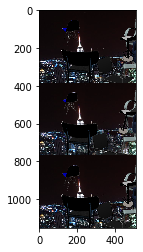

In [13]:
import cv2
img1 = cv2.imread('/local_data_2/dahye/UnOpticalFlow/Dataset/flying_release/data_s1/data/0000000001.png')

import matplotlib.pyplot as plt
plt.imshow(img1)

In [18]:
img1.shape[0]/3

384.0

In [22]:
import numpy as np

In [30]:
np.array_equal(img1[384*2:, :,: ],img2)

False

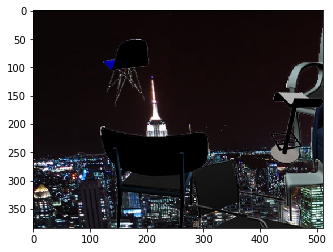

In [29]:
import cv2
img2 = cv2.imread('/data/FlyingChairs_release/data/00001_img2.ppm')
import matplotlib.pyplot as plt
plt.imshow(img2)

In [43]:
img1[:,23,:10]

array([[  0,   8,  16],
       [ 69,  80,  84],
       [226, 235, 238],
       ...,
       [ 25,  19,  24],
       [ 25,  18,  25],
       [ 24,  17,  24]], dtype=uint8)

In [44]:
img2[:,23,:10]

array([[  0,   8,  16],
       [ 69,  80,  84],
       [226, 235, 238],
       ...,
       [ 25,  19,  24],
       [ 25,  18,  25],
       [ 24,  17,  24]], dtype=uint8)

In [60]:
from IPython.display import Image
Image('/locla_/FlyingChairs_release/data/00001_img1.ppm')

ValueError: Cannot embed the 'ppm' image format

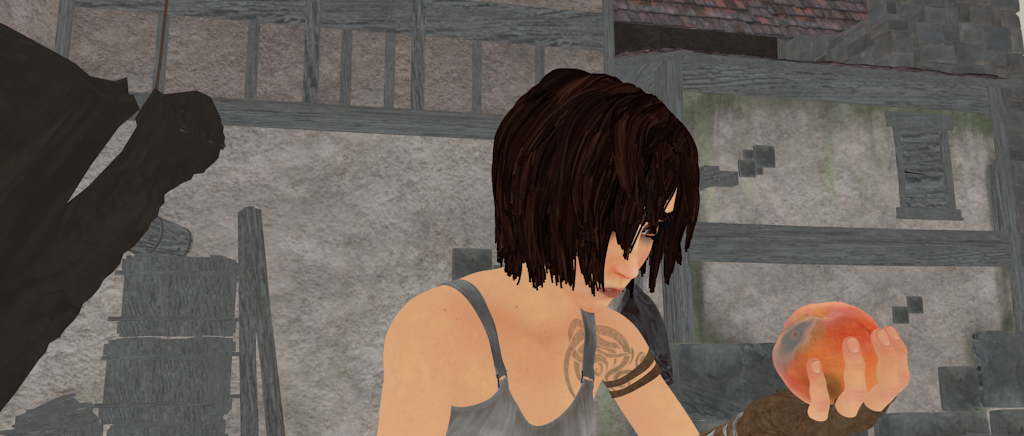

In [31]:
Image('/data/Sintel/training/albedo/alley_1/frame_0001.png')

In [19]:
cv2.imshow(img)

TypeError: Required argument 'mat' (pos 2) not found